In [146]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import random

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.style.use('seaborn')

import plotly.io as pio
import plotly.graph_objects as go

pio.templates.default = 'plotly'

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
import warnings
warnings.simplefilter('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import utils
import tstests

from tqdm import tqdm

In [147]:
def add_si_scores(train_res, valid_res, si_scores_df, name):
    for i in range(50):
        for s in range(10):
            train_actual = train_res.loc[
                (train_res.item==i+1) & (train_res.store==s+1),
                'sales'
            ]
            train_si = train_res.loc[
                (train_res.item==i+1) & (train_res.store==s+1),
                name
            ]

            valid_actual = valid_res.loc[
                (valid_res.item==i+1) & (valid_res.store==s+1),
                'sales'
            ]
            valid_si = valid_res.loc[
                (valid_res.item==i+1) & (valid_res.store==s+1),
                name
            ]

            si_scores_df.loc[
                (si_scores_df.item==i+1) & (si_scores_df.store==s+1),
                f'{name}_train'
            ] = utils.sMAPE(train_actual, train_si)

            si_scores_df.loc[
                (si_scores_df.item==i+1) & (si_scores_df.store==s+1),
                f'{name}_valid'
            ] = utils.sMAPE(valid_actual, valid_si)
            
def add_scores(train_res, valid_res, scores_df, name):
    train_smape = utils.sMAPE(train_res.sales, train_res[name])
    valid_smape = utils.sMAPE(valid_res.sales, valid_res[name])
    scores_df.loc[name] = [train_smape, valid_smape]

In [148]:
temporal_features = ['dayofweek', 'month', 'weekofyear', 'year']

def add_temporal_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week
    df['year'] = df.index.year
    
    return df

def get_prev_total(prev_df, df, curr_y, prev_y, feature='dayofweek'):
    grouped_df = prev_df.groupby([feature]).mean().sales
    grouped_df = grouped_df.reset_index()

    if feature == 'year':
        df.loc[
            (df.year==curr_y),
            f'lag1y_total_{feature}_mean'
        ] = grouped_df.sales.iloc[0]
    else:
        grouped_df['scaled'] = 0.1 + ((grouped_df.sales-grouped_df.sales.min())*(0.9-0.1))/(grouped_df.sales.max()-grouped_df.sales.min())
        for i, row in grouped_df.iterrows():
            df.loc[
                (df.year==curr_y) & (df[feature]==row[feature]),
                f'lag1y_total_{feature}_scaled'
            ] = row.scaled

def get_prev_si(prev_df, df, curr_y, prev_y, si, feature='dayofweek'):
    grouped_df = prev_df.groupby([si, feature]).mean().sales
    grouped_df = grouped_df.reset_index(level=[0,1])
    
    grouped_df_std = prev_df.groupby([si, feature]).std().sales
    grouped_df_std = grouped_df_std.reset_index(level=[0,1])
    
    if feature == 'year':
        for i, row in grouped_df.iterrows():
            df.loc[
                (df.year==curr_y) & (df[si]==row[si]),
                f'lag1y_{si}_{feature}_mean'
            ] = row.sales
    else:
        for i, row in grouped_df.iterrows():
            df.loc[
                (df.year==curr_y) & (df[si]==row[si]) & (df[feature]==row[feature]),
                f'lag1y_{si}_{feature}_mean'
            ] = row.sales
            
        for i, row in grouped_df_std.iterrows():    
            df.loc[
                (df.year==curr_y) & (df[si]==row[si]) & (df[feature]==row[feature]),
                f'lag1y_{si}_{feature}_std'
            ] = row.sales
    
def add_total_lag_sales(df):
    for i in range(1, len(df.year.unique())):
        curr_y = df.year.unique()[i]
        prev_y = df.year.unique()[i-1]
        prev_df = df.loc[df.year==prev_y]
        for t in temporal_features:
            get_prev_total(prev_df, df, curr_y, prev_y, feature=t)
            get_prev_si(prev_df, df, curr_y, prev_y, 'store', feature=t)
            get_prev_si(prev_df, df, curr_y, prev_y, 'item', feature=t)
            
    return df

def add_scaled_mean(df):
    for i in range(len(temporal_features)-1):
        tf = temporal_features[i]
        df[f'lag1y_store_{tf}_scaledmean'] = df[f'lag1y_total_{tf}_scaled'] * df[f'lag1y_store_{tf}_mean']
        df[f'lag1y_item_{tf}_scaledmean'] = df[f'lag1y_total_{tf}_scaled'] * df[f'lag1y_item_{tf}_mean']
        
    return df

def add_rolling_means(df):
    for lag in [90, 182, 365]:
        lag_col_name = f"lag_{lag}d"
        df[lag_col_name] = df.groupby(['item', 'store'])['sales'].shift(periods=lag)

    df['rolling_mean_90'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=90).mean())
    df['rolling_mean_182'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=182).mean())
    df['rolling_mean_365'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=365).mean())
    df['rolling_std_90'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=90).std())
    df['rolling_std_182'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=182).std())
    df['rolling_std_365'] = df.groupby(['item', 'store'])['sales'].transform(lambda x: x.rolling(window=365).std())

    return df

def feature_engineer(df):
    df['date'] = df['date'].astype('datetime64[ns]')
    df = df.set_index('date')
    df = add_temporal_features(df)
    df = add_total_lag_sales(df)
    df = add_scaled_mean(df)
    df = add_rolling_means(df)
    
    return df

# Feature Engineering

Features to use:
- Store-Item (captures store-item dependencies i.e each store-item has diff magnitude in terms of sales)
- dayofweek, month, weekofyear, year seem to have strongest differentiable trends. it's ok to leave them as ordinal variables (captures seasonality)
- sales 1 year ago to capture seasonality (captures relative strength based on seasonality)
    * calculate by taking total sales, grouped by temporal features for the last year e.g what is the mean sale for mondays 1 year ago?
- store-item features
    * store-wide mean/std
    * item-wide mean/std
- scaled features * average sales to guide model

In [149]:
all_train_data = pd.read_csv("demand-forecasting-kernels-only/train.csv")
all_train_data = feature_engineer(all_train_data)

In [150]:
all_train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   store                              913000 non-null  int64  
 1   item                               913000 non-null  int64  
 2   sales                              913000 non-null  int64  
 3   dayofweek                          913000 non-null  int64  
 4   month                              913000 non-null  int64  
 5   weekofyear                         913000 non-null  UInt32 
 6   year                               913000 non-null  int64  
 7   lag1y_total_dayofweek_scaled       730500 non-null  float64
 8   lag1y_store_dayofweek_mean         730500 non-null  float64
 9   lag1y_store_dayofweek_std          730500 non-null  float64
 10  lag1y_item_dayofweek_mean          730500 non-null  float64
 11  lag1y_item_dayofweek_st

In [151]:
split_date = pd.to_datetime('2017-10-01')
train_data = all_train_data[all_train_data.index < split_date]
valid_data = all_train_data[all_train_data.index >= split_date]
print(train_data.shape)
print(valid_data.shape)

(867000, 40)
(46000, 40)


# Correlation Matrix

In [152]:
features = [i for i in all_train_data.columns if i != 'sales']

In [153]:
df1_train = train_data.copy()
df1_valid = valid_data.copy()
df1_train.dropna(axis=0, inplace=True)
df1_valid.dropna(axis=0, inplace=True)

corr_df = df1_train[['sales']+features]
corr = corr_df.corr()

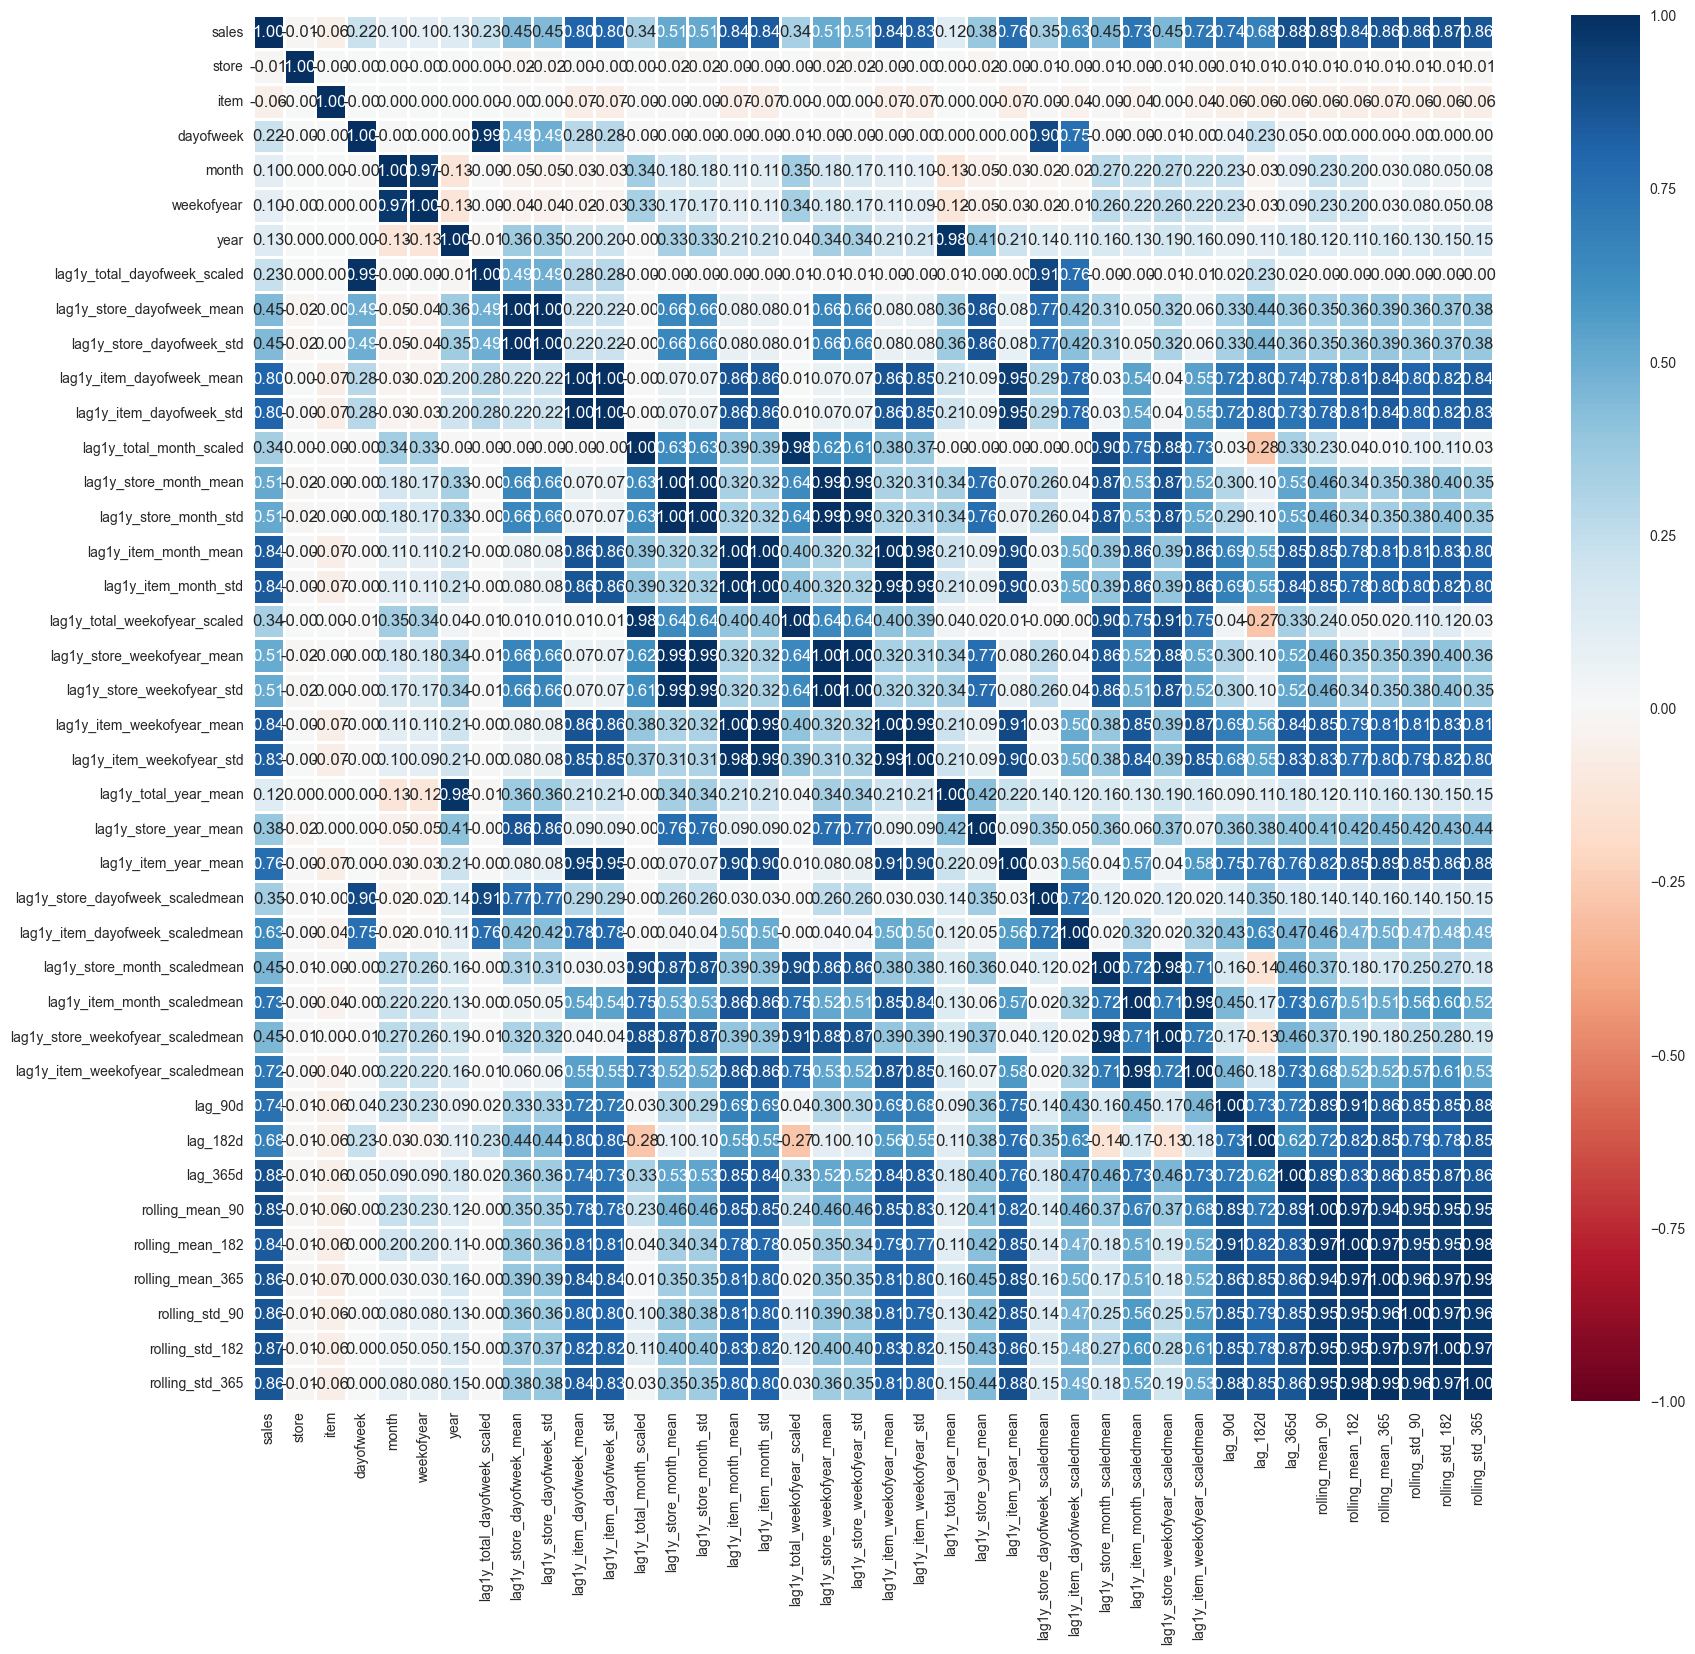

In [154]:
import seaborn as sb
f = plt.figure(figsize=(20, 18))
sb.heatmap(corr, vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 12}, cmap = "RdBu");

# ML Models

An alternative approach to using traditional time series models for forecasting problems, we can use machine learning models like XGBoost and treat it as a regression problem. In this manner, we can also feature engineer more features such lagged features, moving average features along with the features we were already using such as day and month variables

However, we have seen from our EDA that historical sales follow a very predictable pattern based on the day of the week, the month and the year, varying in magnitudes depending on which exact store-item combination we're forecasting. 

As such, models that can handle feature interactions and non-linear relationships would tend to perform well.

In [155]:
si_scores_dict = {}
for i in range(50):
    for s in range(10):
        si_scores_dict[f's{s+1}_i{i+1}'] = []
si_scores_df = pd.DataFrame.from_dict(si_scores_dict, orient='index')
scores_dict = {'train' : [], 'valid': []}
scores_df = pd.DataFrame.from_dict(scores_dict)

si_scores_df['si'] = si_scores_df.index
si_scores_df['store'] = si_scores_df.si.apply(lambda x: int(x.split('_')[0][1:]))
si_scores_df['item'] = si_scores_df.si.apply(lambda x: int(x.split('_')[1][1:]))
si_scores_df.drop('si', axis=1, inplace=True)
si_scores_df.head()

store  item
s1_i1      1     1
s2_i1      2     1
s3_i1      3     1
s4_i1      4     1
s5_i1      5     1

In [156]:
train_res = train_data.copy()
valid_res = valid_data.copy()
train_res.dropna(axis=0, inplace=True)
valid_res.dropna(axis=0, inplace=True)
X_train = train_res[features]
X_valid = valid_res[features]
y_train = train_res.sales
y_valid = valid_res.sales

## Decision Tree Regression

In [157]:
from sklearn.tree import DecisionTreeRegressor

In [158]:
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=12)
dt_regressor.fit(X_train, y_train)
train_res['dtree'] = dt_regressor.predict(X_train)
valid_res['dtree'] = dt_regressor.predict(X_valid)

In [159]:
add_si_scores(train_res, valid_res, si_scores_df, 'dtree')

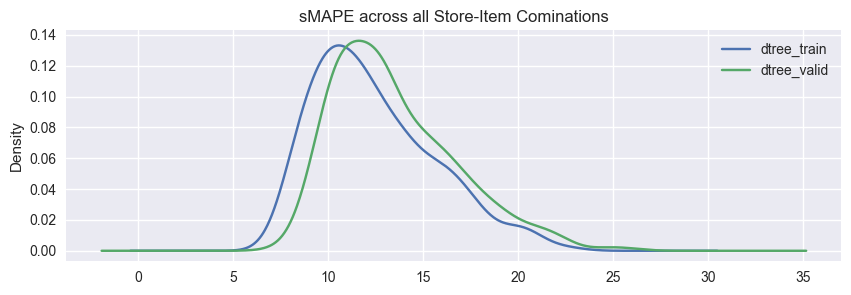

In [160]:
utils.plot_smape(si_scores_df, 'dtree')

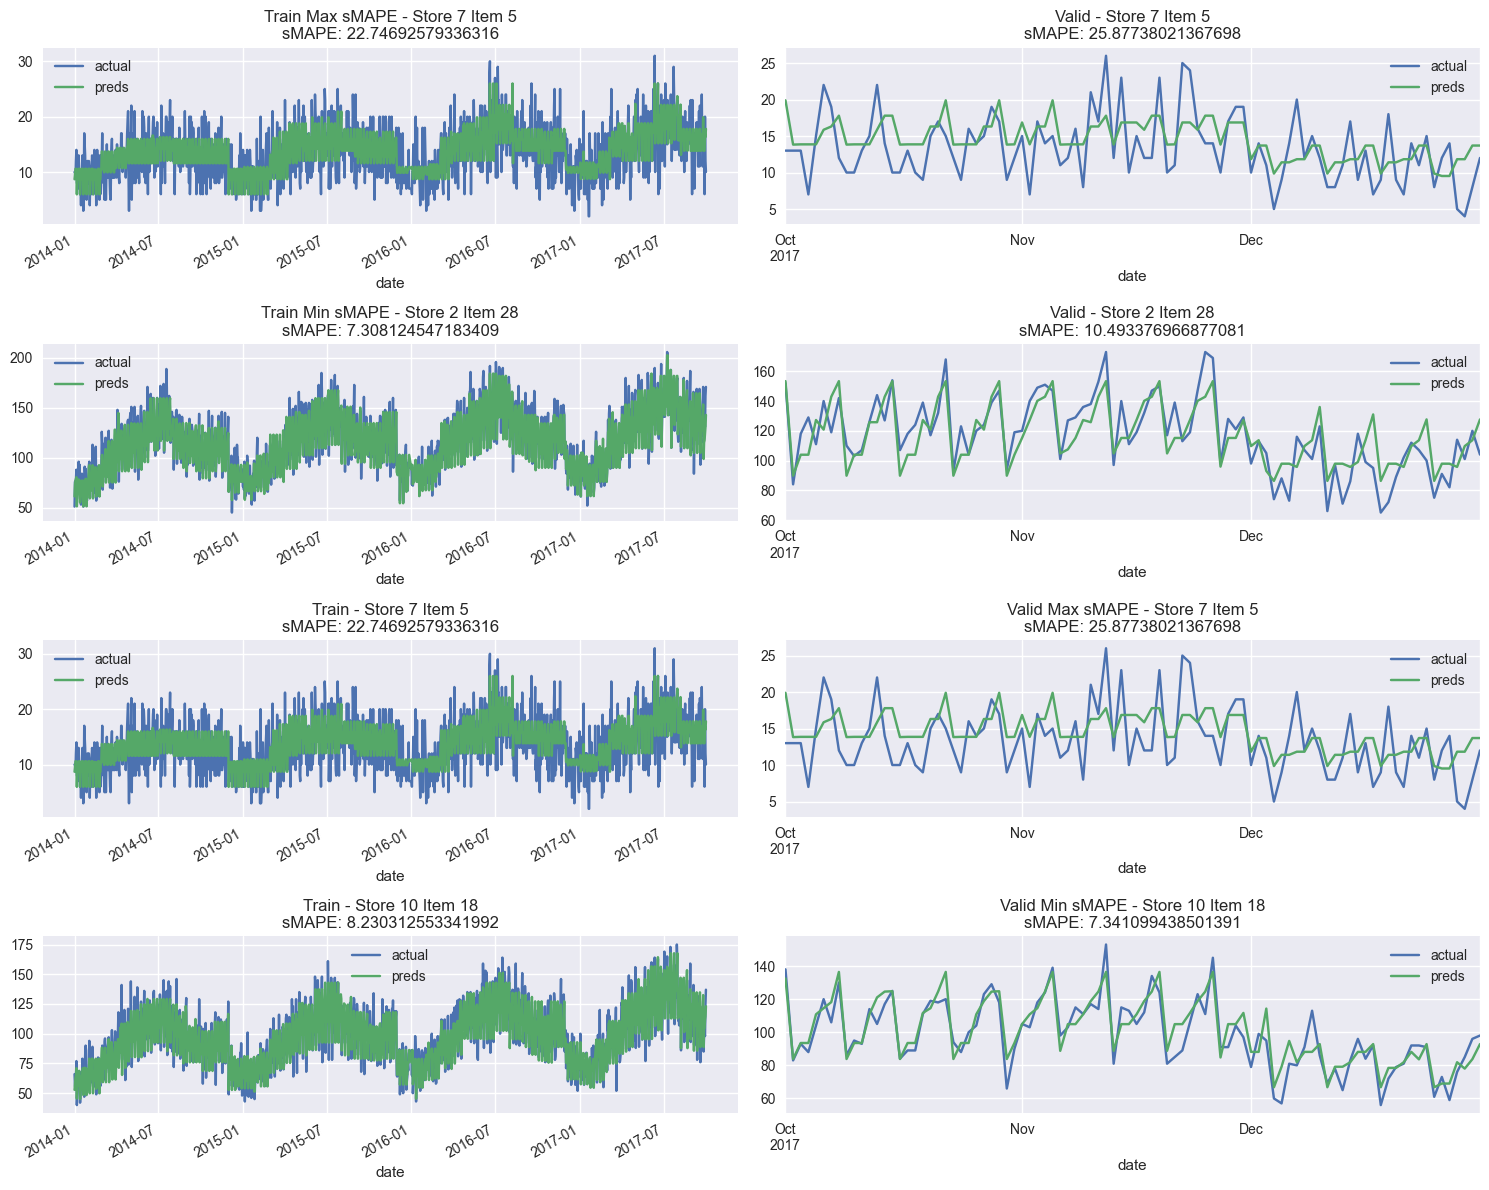

In [161]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'dtree')

In [162]:
add_scores(train_res, valid_res, scores_df, 'dtree')
scores_df

train     valid
dtree  12.437039  13.49378

### Decision Tree Regression for individual store-items

In [163]:
def get_dtree_forecast(train, valid, **f_kwargs):
    X_train = train[f_kwargs['features']]
    y_train = train[f_kwargs['target']]
    X_valid = valid[f_kwargs['features']]
    y_valid = valid[f_kwargs['target']]

    dt_regressor = DecisionTreeRegressor(**f_kwargs['dtree_params'])
    dt_regressor.fit(X_train, y_train)
    preds_train = dt_regressor.predict(X_train)
    preds_valid = dt_regressor.predict(X_valid)
    
    return preds_train, preds_valid

In [164]:
kwargs_dtree = {
    'name' : 'dtree_indiv',
    'f_kwargs' : {
        'features' : features[2:],
        'target' : 'sales',
        'dtree_params' : {
            'random_state' : 42,
            'max_depth' : 3
        }
    }
}

train_res, valid_res, si_scores_df, scores_df = utils.run_model(train_res, valid_res, 
                                               si_scores_df, scores_df,
                                               get_dtree_forecast, **kwargs_dtree)

(1,1)  train : 18.7362      valid : 22.4714
(1,2)  train : 15.8937      valid : 18.0061
(1,3)  train : 16.8514      valid : 15.8461
(1,4)  train : 17.7953      valid : 20.3628
(1,5)  train : 20.7386      valid : 20.5843
(1,6)  train : 20.0728      valid : 21.8109
(1,7)  train : 21.7112      valid : 22.0351
(1,8)  train : 17.4      valid : 15.13
(1,9)  train : 17.5363      valid : 20.37
(1,10)  train : 17.406      valid : 14.1269
-----------------------------------------------------
Item 1 Train sMAPE : 18.4141
Item 1 Valid sMAPE : 19.0744
-----------------------------------------------------

(2,1)  train : 12.7591      valid : 14.2272
(2,2)  train : 11.5429      valid : 13.0651
(2,3)  train : 12.1898      valid : 11.1287
(2,4)  train : 12.1567      valid : 14.2067
(2,5)  train : 13.8129      valid : 16.2507
(2,6)  train : 13.4945      valid : 14.079
(2,7)  train : 13.7999      valid : 16.1543
(2,8)  train : 11.7803      valid : 14.9811
(2,9)  train : 12.3629      valid : 10.8952
(2,10

(16,5)  train : 18.3154      valid : 18.9309
(16,6)  train : 18.8174      valid : 18.188
(16,7)  train : 19.7912      valid : 20.3543
(16,8)  train : 15.6614      valid : 16.1115
(16,9)  train : 16.6533      valid : 17.5519
(16,10)  train : 15.8983      valid : 20.5252
-----------------------------------------------------
Item 16 Train sMAPE : 16.9698
Item 16 Valid sMAPE : 18.3583
-----------------------------------------------------

(17,1)  train : 15.886      valid : 15.0667
(17,2)  train : 13.7149      valid : 19.4919
(17,3)  train : 14.8383      valid : 15.4347
(17,4)  train : 14.9381      valid : 15.1894
(17,5)  train : 17.5294      valid : 17.2027
(17,6)  train : 17.3558      valid : 19.8048
(17,7)  train : 17.496      valid : 21.6908
(17,8)  train : 13.9115      valid : 20.4858
(17,9)  train : 14.9123      valid : 20.23
(17,10)  train : 15.0613      valid : 13.1927
-----------------------------------------------------
Item 17 Train sMAPE : 15.5644
Item 17 Valid sMAPE : 17.7789


(30,5)  train : 15.9092      valid : 16.5987
(30,6)  train : 15.7072      valid : 16.097
(30,7)  train : 16.6722      valid : 15.5545
(30,8)  train : 13.43      valid : 12.9385
(30,9)  train : 13.9544      valid : 16.7001
(30,10)  train : 13.7559      valid : 14.0232
-----------------------------------------------------
Item 30 Train sMAPE : 14.5676
Item 30 Valid sMAPE : 14.9638
-----------------------------------------------------

(31,1)  train : 12.8206      valid : 12.029
(31,2)  train : 11.3004      valid : 14.1327
(31,3)  train : 12.0793      valid : 12.5363
(31,4)  train : 11.9364      valid : 11.7707
(31,5)  train : 13.4756      valid : 15.4905
(31,6)  train : 13.4201      valid : 16.2763
(31,7)  train : 14.1641      valid : 14.9137
(31,8)  train : 11.8079      valid : 9.7026
(31,9)  train : 12.058      valid : 13.1463
(31,10)  train : 11.961      valid : 12.1668
-----------------------------------------------------
Item 31 Train sMAPE : 12.5023
Item 31 Valid sMAPE : 13.2165
--

(44,10)  train : 14.4975      valid : 13.3388
-----------------------------------------------------
Item 44 Train sMAPE : 16.2619
Item 44 Valid sMAPE : 16.7644
-----------------------------------------------------

(45,1)  train : 11.8863      valid : 12.2674
(45,2)  train : 10.3945      valid : 10.6664
(45,3)  train : 10.5265      valid : 10.9824
(45,4)  train : 11.2552      valid : 16.4719
(45,5)  train : 11.8103      valid : 12.5811
(45,6)  train : 12.1286      valid : 14.4372
(45,7)  train : 12.8827      valid : 12.6913
(45,8)  train : 10.6729      valid : 11.3582
(45,9)  train : 11.2405      valid : 11.146
(45,10)  train : 10.6428      valid : 11.9804
-----------------------------------------------------
Item 45 Train sMAPE : 11.344
Item 45 Valid sMAPE : 12.4582
-----------------------------------------------------

(46,1)  train : 12.591      valid : 13.3944
(46,2)  train : 11.4209      valid : 11.9419
(46,3)  train : 11.9824      valid : 11.3229
(46,4)  train : 12.3792      vali

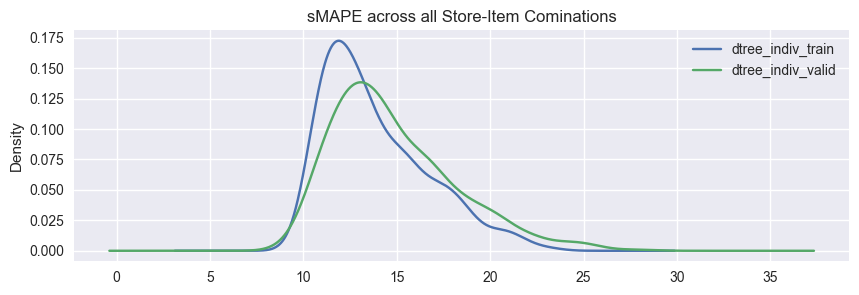

In [165]:
utils.plot_smape(si_scores_df, 'dtree_indiv')

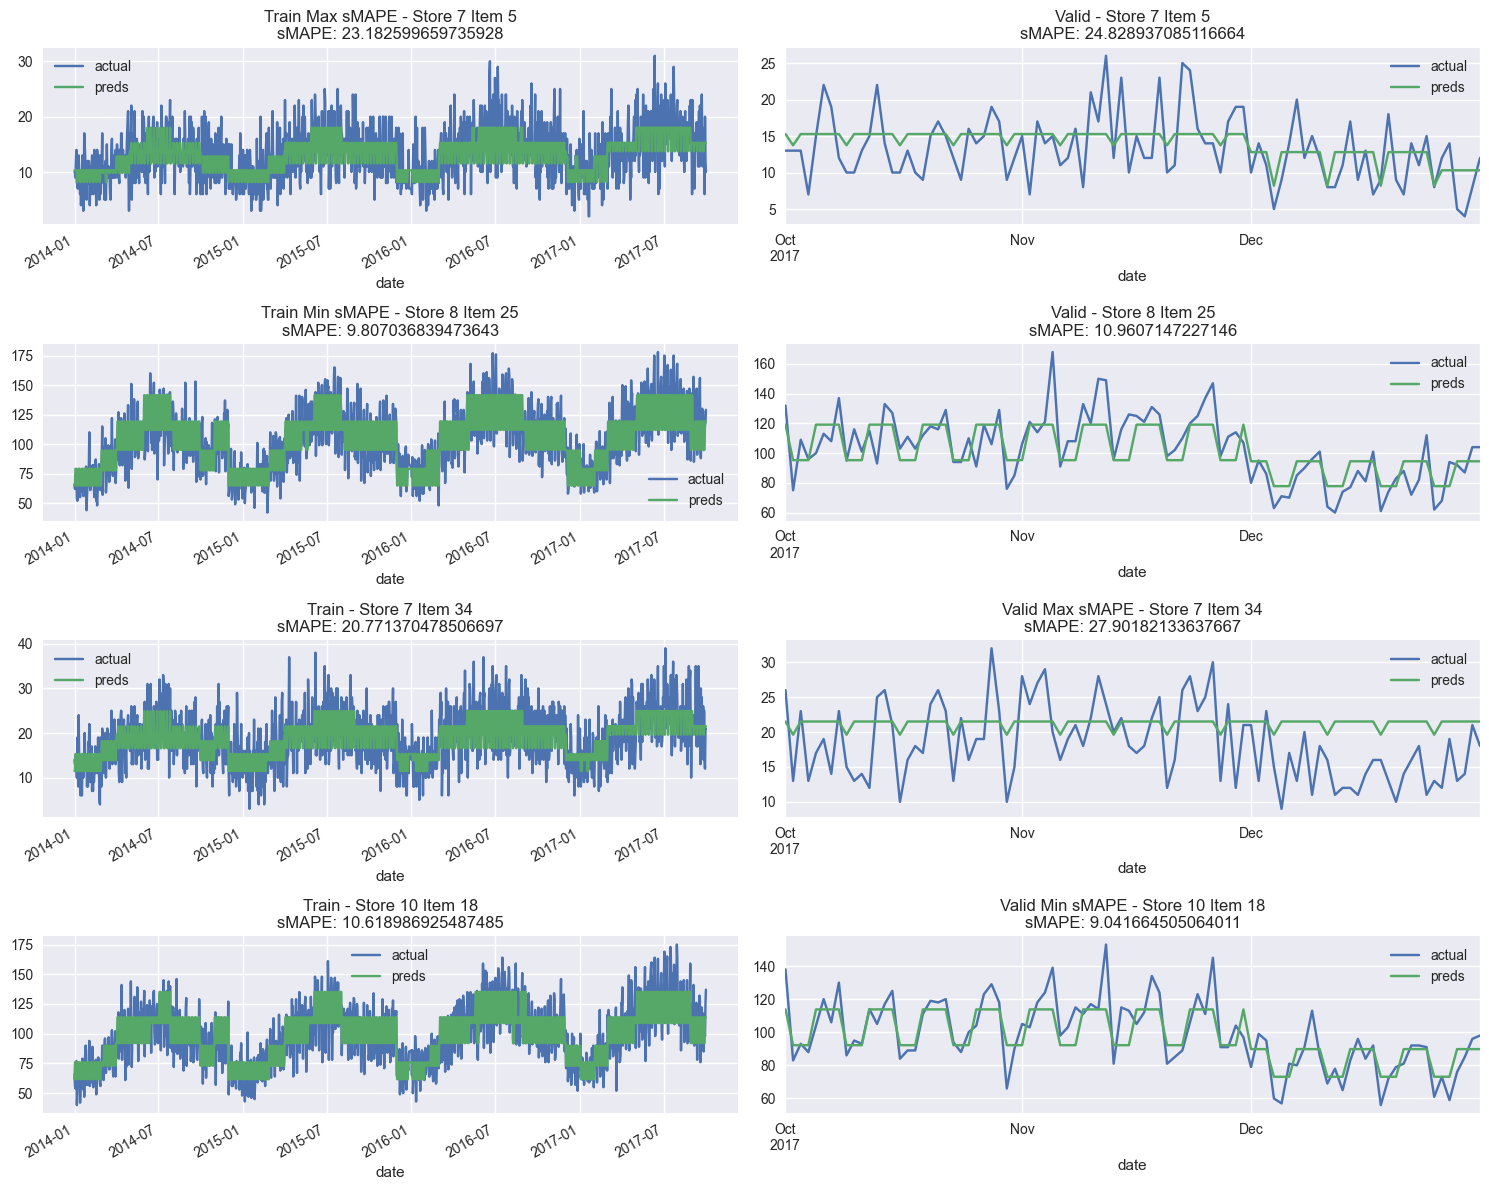

In [166]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'dtree_indiv')

In [167]:
scores_df

train      valid
dtree        12.437039  13.493780
dtree_indiv  13.871189  14.834892

We can see that fitting the model as a whole works better but the problem of variance still exists

## Random Forest

Decision trees are prone to overfitting. So we use random forests which offers bagging and random subspaces of features

In [168]:
from sklearn.ensemble import RandomForestRegressor

In [169]:
rf_regressor = RandomForestRegressor(random_state=42,
                                     n_jobs=-1,
                                     max_depth=6,
                                     n_estimators=8000,
                                     max_features=0.33,
                                     verbose=0
                                    )
rf_regressor.fit(X_train, y_train)
train_res['rf'] = rf_regressor.predict(X_train)
valid_res['rf'] = rf_regressor.predict(X_valid)

In [170]:
add_si_scores(train_res, valid_res, si_scores_df, 'rf')

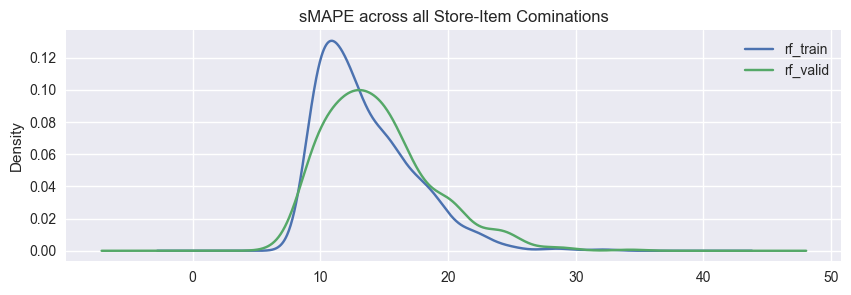

In [171]:
utils.plot_smape(si_scores_df, 'rf')

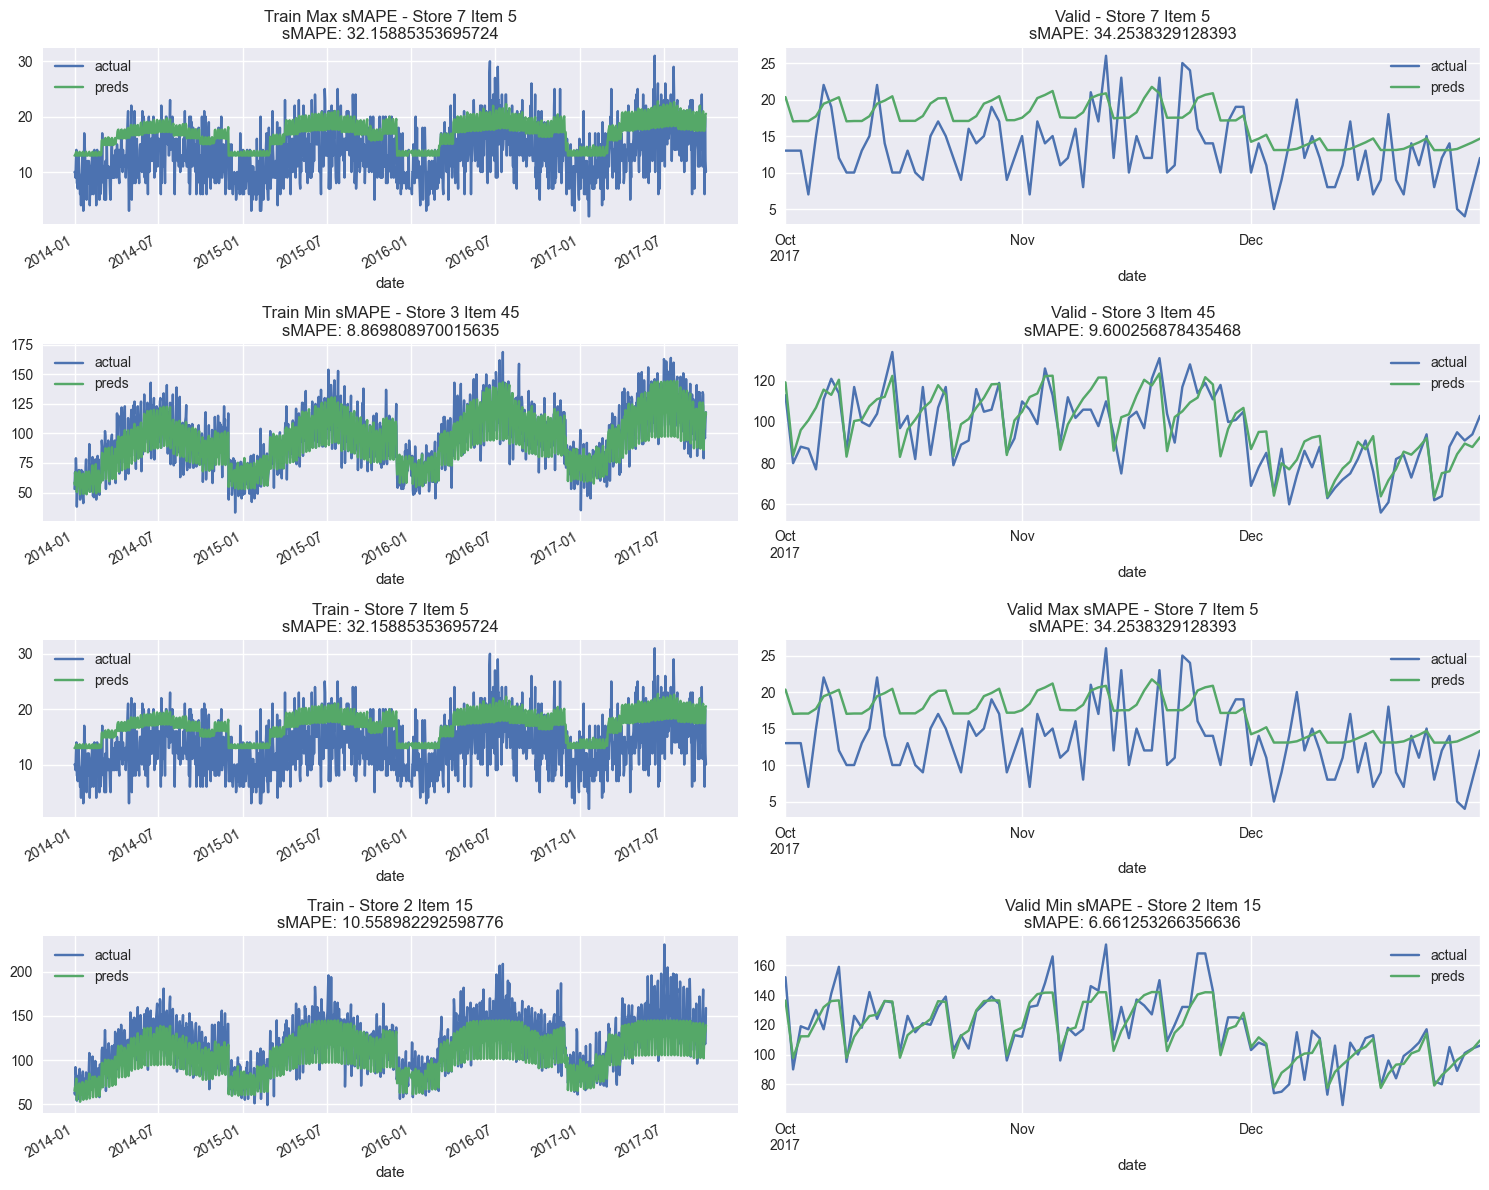

In [172]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'rf')

In [173]:
add_scores(train_res, valid_res, scores_df, 'rf')
scores_df

train      valid
dtree        12.437039  13.493780
dtree_indiv  13.871189  14.834892
rf           13.558214  14.490352

### Random Forest for individual store items

In [174]:
def get_rf_forecast(train, valid, **f_kwargs):
    X_train = train[f_kwargs['features']]
    y_train = train[f_kwargs['target']]
    X_valid = valid[f_kwargs['features']]
    y_valid = valid[f_kwargs['target']]
    
    rf_regressor = RandomForestRegressor(**f_kwargs['rf_params'])
    rf_regressor.fit(X_train, y_train)
    preds_train = rf_regressor.predict(X_train)
    preds_valid = rf_regressor.predict(X_valid)

    return preds_train, preds_valid

In [175]:
kwargs_dtree = {
    'name' : 'rf_indiv',
    'f_kwargs' : {
        'features' : features[2:],
        'target' : 'sales',
        'rf_params' : {
            'random_state':42,
            'n_jobs': -1,
            'max_depth': 6,
            'n_estimators': 1000,
            'max_features': 0.33,
            'verbose': 0
        }
    }
}

train_res, valid_res, si_scores_df, scores_df = utils.run_model(train_res, valid_res, 
                                               si_scores_df, scores_df,
                                               get_rf_forecast, **kwargs_dtree)

(1,1)  train : 15.2374      valid : 21.5196
(1,2)  train : 12.8774      valid : 18.0751
(1,3)  train : 13.7784      valid : 14.0236
(1,4)  train : 14.49      valid : 17.5139
(1,5)  train : 17.4887      valid : 19.9094
(1,6)  train : 16.8386      valid : 19.9496
(1,7)  train : 18.0897      valid : 21.1489
(1,8)  train : 13.8529      valid : 15.2443
(1,9)  train : 14.2368      valid : 16.3163
(1,10)  train : 14.022      valid : 13.7492
-----------------------------------------------------
Item 1 Train sMAPE : 15.0912
Item 1 Valid sMAPE : 17.745
-----------------------------------------------------

(2,1)  train : 9.3945      valid : 11.0052
(2,2)  train : 8.0584      valid : 9.5952
(2,3)  train : 8.6832      valid : 9.0742
(2,4)  train : 8.7093      valid : 10.4765
(2,5)  train : 10.2205      valid : 13.9372
(2,6)  train : 10.1819      valid : 12.7742
(2,7)  train : 10.6168      valid : 13.6212
(2,8)  train : 8.064      valid : 9.795
(2,9)  train : 9.0096      valid : 9.7807
(2,10)  trai

(15,1)  train : 7.9353      valid : 9.0705
(15,2)  train : 6.4883      valid : 7.2989
(15,3)  train : 6.9571      valid : 8.7379
(15,4)  train : 7.0005      valid : 8.4806
(15,5)  train : 8.6927      valid : 10.4199
(15,6)  train : 8.5536      valid : 11.7414
(15,7)  train : 8.9283      valid : 9.4803
(15,8)  train : 6.602      valid : 8.5768
(15,9)  train : 7.1248      valid : 8.8736
(15,10)  train : 6.8576      valid : 8.9377
-----------------------------------------------------
Item 15 Train sMAPE : 7.514
Item 15 Valid sMAPE : 9.1618
-----------------------------------------------------

(16,1)  train : 14.1818      valid : 21.084
(16,2)  train : 11.9664      valid : 16.0465
(16,3)  train : 12.2767      valid : 13.7657
(16,4)  train : 13.1153      valid : 15.8397
(16,5)  train : 15.1737      valid : 18.154
(16,6)  train : 15.5036      valid : 16.4356
(16,7)  train : 16.5397      valid : 19.016
(16,8)  train : 12.1558      valid : 13.7903
(16,9)  train : 13.3493      valid : 15.626
(

(28,8)  train : 6.5206      valid : 8.74
(28,9)  train : 7.4473      valid : 8.6493
(28,10)  train : 6.9284      valid : 7.5667
-----------------------------------------------------
Item 28 Train sMAPE : 7.4949
Item 28 Valid sMAPE : 9.2615
-----------------------------------------------------

(29,1)  train : 8.5188      valid : 10.2269
(29,2)  train : 7.1917      valid : 8.8513
(29,3)  train : 7.72      valid : 10.1316
(29,4)  train : 8.3322      valid : 9.718
(29,5)  train : 9.5871      valid : 12.273
(29,6)  train : 9.4417      valid : 13.0061
(29,7)  train : 9.916      valid : 12.0079
(29,8)  train : 7.4833      valid : 8.5752
(29,9)  train : 8.0903      valid : 11.2533
(29,10)  train : 7.4872      valid : 10.2939
-----------------------------------------------------
Item 29 Train sMAPE : 8.3768
Item 29 Valid sMAPE : 10.6337
-----------------------------------------------------

(30,1)  train : 11.6846      valid : 12.396
(30,2)  train : 9.7223      valid : 13.5396
(30,3)  train : 

(42,1)  train : 11.4621      valid : 15.6464
(42,2)  train : 10.0247      valid : 11.1384
(42,3)  train : 10.7053      valid : 14.6338
(42,4)  train : 11.1549      valid : 13.3392
(42,5)  train : 13.02      valid : 13.9971
(42,6)  train : 13.1157      valid : 17.1378
(42,7)  train : 13.8396      valid : 17.037
(42,8)  train : 10.5429      valid : 13.3374
(42,9)  train : 11.1316      valid : 14.7333
(42,10)  train : 10.7754      valid : 11.9068
-----------------------------------------------------
Item 42 Train sMAPE : 11.5772
Item 42 Valid sMAPE : 14.2907
-----------------------------------------------------

(43,1)  train : 9.8196      valid : 13.3656
(43,2)  train : 8.4307      valid : 9.894
(43,3)  train : 8.8635      valid : 11.0241
(43,4)  train : 9.5685      valid : 11.4108
(43,5)  train : 10.6916      valid : 11.8142
(43,6)  train : 10.7255      valid : 12.0272
(43,7)  train : 11.5795      valid : 14.7838
(43,8)  train : 8.7054      valid : 10.4132
(43,9)  train : 9.5206      va

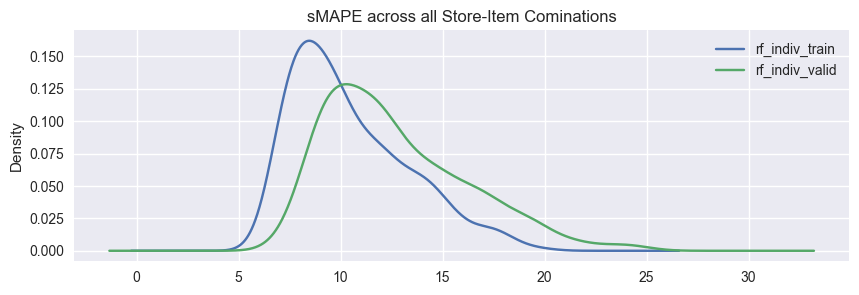

In [176]:
utils.plot_smape(si_scores_df, 'rf_indiv')

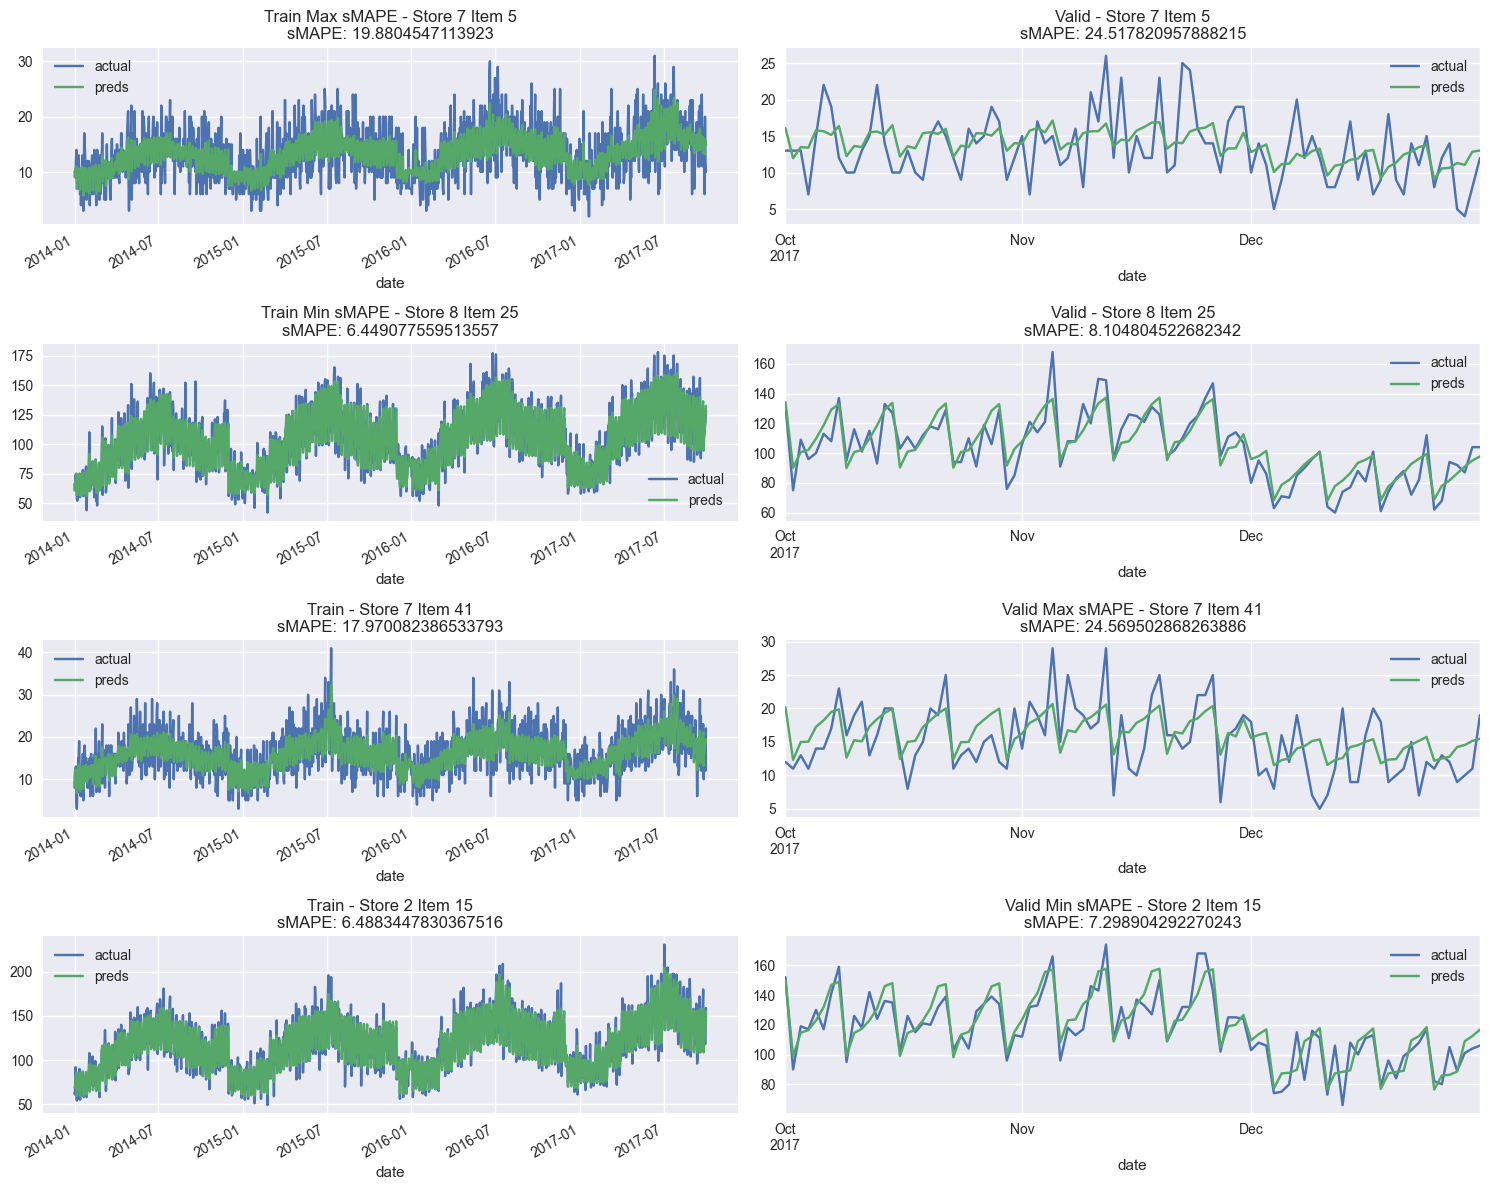

In [177]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'rf_indiv')

In [178]:
scores_df

train      valid
dtree        12.437039  13.493780
dtree_indiv  13.871189  14.834892
rf           13.558214  14.490352
rf_indiv     10.470880  12.712571

## XGBoost
* Scalable, efficient. It utilizes parallel computing, cache-aware access, blocks for out-of-core computation (optimizations that take into account computer hardware) and tree pruning strategies, which makes the computation faster and more efficient.
* Uses approximately greedy algorithm to determine threshold to split tree -- only use quantiles as thresholds to divide data.
* Best algo amongst many kaggle competition winning submissions, high accuracy
* Regularization boosting to combat overfitting. XGBoost introduces additional regularization terms in the objective function, which helps to control overfitting, making the model more generalizable.
* XGBoost has an in-built routine to perform cross-validation at each iteration of the boosting process, making it easy to get the most optimal model.
* Interpretability with feature importance scores

### Gradient Boosting Recap
1. Input: Data $\{(x_i, y_i)\}_{i=1}^n$ and a differentiable Loss function $L(y_i, F(x))$
2. Initialize model with a constant value: $F_0(x) = \arg \min_{\gamma}\sum_{i=1}^{n}{L(y_i, \gamma)}$. $\gamma$ refers to predicted values. This is usually a leaf with the initial predicted value $F_0(x)$ = average. i.e the leaf would predict all samples would be average
3. For trees $m=1$ to $M$:
    - Compute pseudo residuals or gradient, $ r_{im} = -[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]_{F(x)=F_{m-1}(x)} $ for all samples $ i = 1,...,n $
    - Fit a regression tree to the $r_{im}$ values and create terminal regions $R_{jm}$ for $j=1,...,J_m$. Terminal regions are leaves and $J_m$ represents the number of leaves
    - Determine output values for each leaf. For $ j = 1,...,J_m$, compute $ \gamma_{jm} = \arg \min_{\gamma}\sum_{x_i\in R_{ij}}{L(y_i, F_{m-1}(x_i) + \gamma)}$ for samples in each  leaf node $j$. We are thus solving for the $\gamma$ or predicted value that minimizes the loss function, $L$.
    - Update $F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m}{\gamma_{jm}I(x \in R_{jm}})$. Adding up all output values, $\gamma_{j,m}$ for all the leaves, $R_{j,m}$ for which a sample $x$ can be found in. $\nu$ is the learning rate
4. Output $F_M(x)$

### XGBoost Algorithm
1. Just like gradient boost, xgboost also fits a regression tree to residuals. But they use xgboost trees. 
    * Each tree starts out as a single leaf and all residuals go to that leaf
    * Calculate similarity score for each node = $\frac {(\sum{r_i})^2}{n + \lambda} $ where $r_i$ = residual and $n$ = num residuals and $\lambda$ is a regularization parameter. Higher values of $\lambda$ would prevent overfitting training data.
    * Similarity score refers to how similar the residuals are. More similar, higher, less similar, smaller. Question is now whether we can split the residuals better and cluster them better. Split tree with threshold
    * Quantify how much better split clusters residuals by Gain of parent = Sum of similarity scores of leaves - Similarity score of parent
    * Choose the threshold that gives the split that maximizes gain
    * Repeat this until the max depth of tree is reached which is usually 6
2. Prune the tree
    * Prune based on gain values. Compare gain with $\gamma$. Calculate diff between gain associated with lowest branch in the tree and the value for $\gamma$ as Gain - $\gamma$. If this value < 0, we prune the branch. Parents of an unpruned branch will also not be pruned.
    * Note that setting $\gamma$ = 0 does not turn off pruning. 
3. Output value = $ \frac {\sum{r_i}}{n + \lambda} $ for each leaf.
    * When $\lambda > 0$, it will reduce the amount an individual observation adds to the overall prediction. Thus $\lambda$ will reduce prediction's sensitivity to individual observation.
4. First tree is complete. Make new predictions with $ F_1(x) = F_0(x) + \varepsilon f_0(x)$ where $\varepsilon$ is the learning rate
5. Keep building trees until residuals are super small or when we have reached max number of trees

In [179]:
import xgboost as xgb

booster_params = {
        'booster' : 'gbtree', 
        'n_estimators' : 8000,
        'early_stopping_rounds' : 500,
        'objective' : 'reg:linear',
        'max_depth' : 3,
        'learning_rate' : 0.01
}

xgbreg = xgb.XGBRegressor(**booster_params)
xgbreg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=100)
train_res['xgb'] = xgbreg.predict(X_train)
valid_res['xgb'] = xgbreg.predict(X_valid)

[0]	validation_0-rmse:29.40126	validation_1-rmse:28.23684
[100]	validation_0-rmse:14.95651	validation_1-rmse:13.96830
[200]	validation_0-rmse:10.17205	validation_1-rmse:9.97739
[300]	validation_0-rmse:8.71732	validation_1-rmse:8.97280
[400]	validation_0-rmse:8.19544	validation_1-rmse:8.54873
[500]	validation_0-rmse:7.96305	validation_1-rmse:8.34540
[600]	validation_0-rmse:7.85013	validation_1-rmse:8.17252
[700]	validation_0-rmse:7.78267	validation_1-rmse:8.08355
[800]	validation_0-rmse:7.73254	validation_1-rmse:8.02544
[900]	validation_0-rmse:7.69432	validation_1-rmse:7.98558
[1000]	validation_0-rmse:7.66420	validation_1-rmse:7.95244
[1100]	validation_0-rmse:7.63838	validation_1-rmse:7.92999
[1200]	validation_0-rmse:7.61661	validation_1-rmse:7.90912
[1300]	validation_0-rmse:7.59748	validation_1-rmse:7.89309
[1400]	validation_0-rmse:7.58074	validation_1-rmse:7.87527
[1500]	validation_0-rmse:7.56561	validation_1-rmse:7.85919
[1600]	validation_0-rmse:7.55201	validation_1-rmse:7.84562
[170

In [180]:
add_si_scores(train_res, valid_res, si_scores_df, 'xgb')

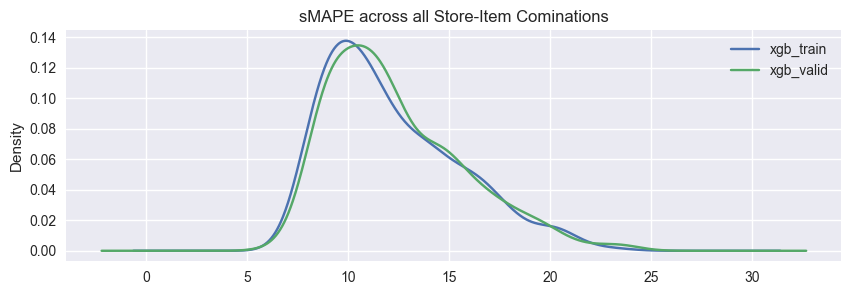

In [181]:
utils.plot_smape(si_scores_df, 'xgb')

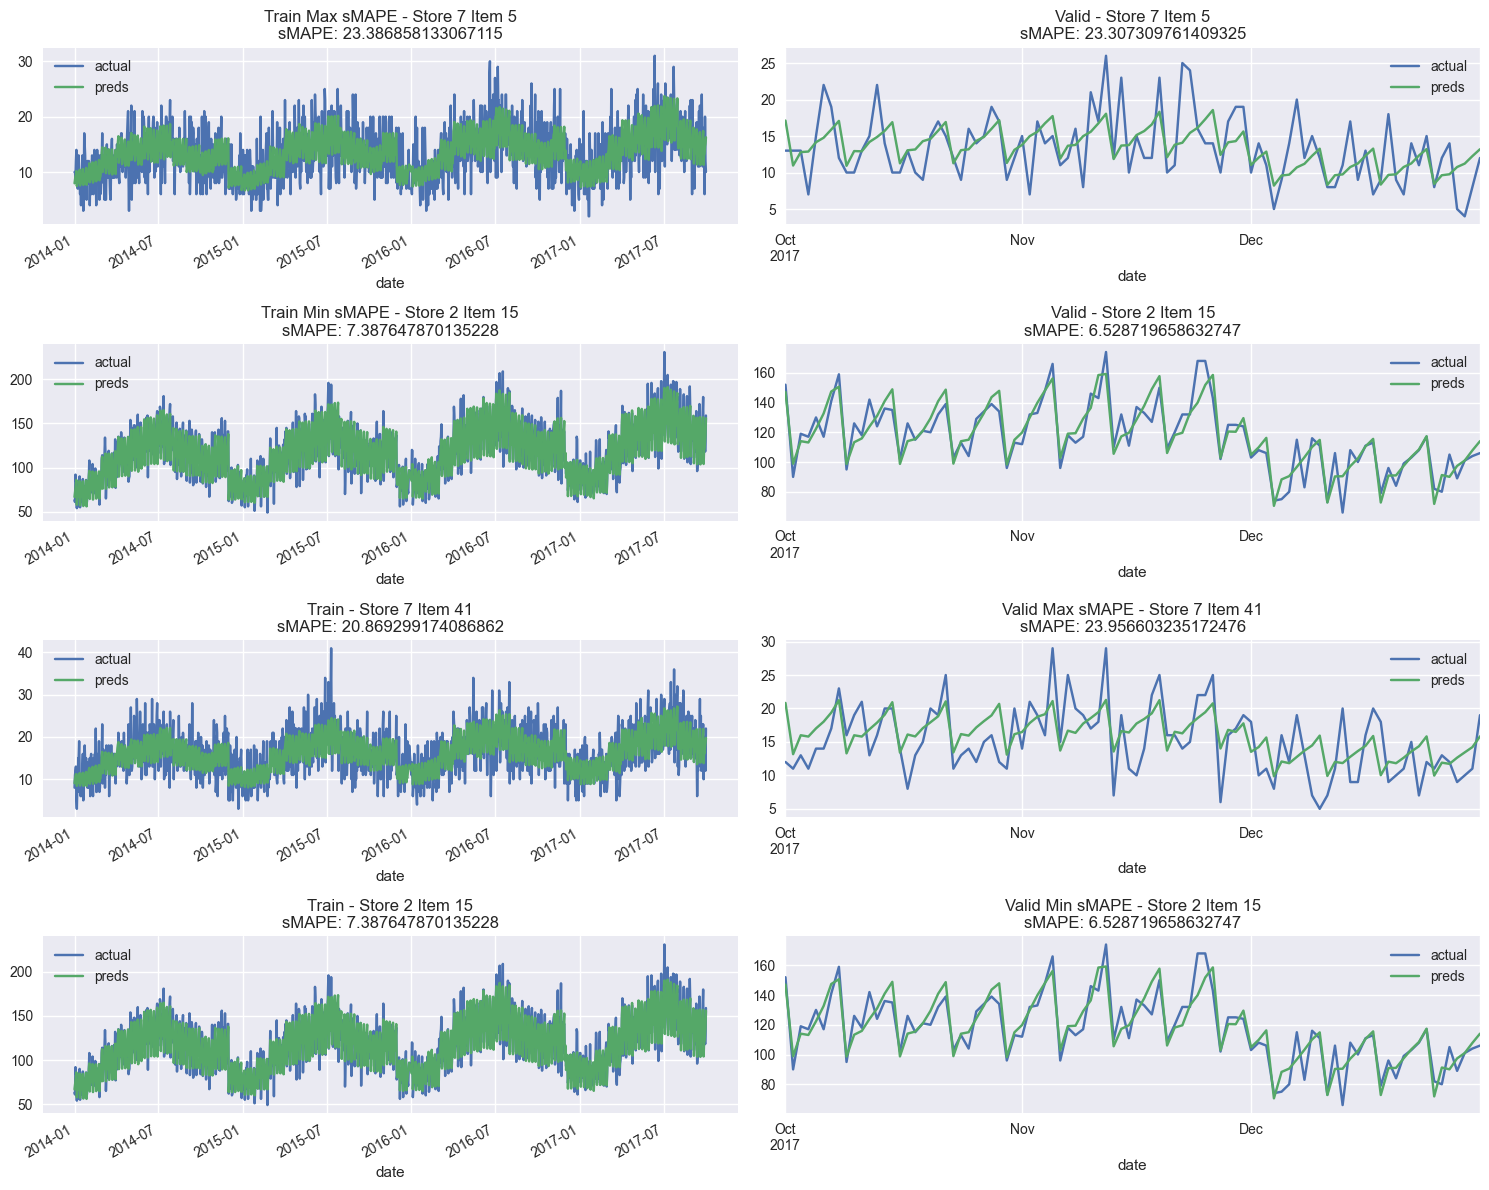

In [182]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'xgb')

In [183]:
add_scores(train_res, valid_res, scores_df, 'xgb')
scores_df

train      valid
dtree        12.437039  13.493780
dtree_indiv  13.871189  14.834892
rf           13.558214  14.490352
rf_indiv     10.470880  12.712571
xgb          12.190373  12.385719

In [184]:
res = train_res.sales - train_res.xgb

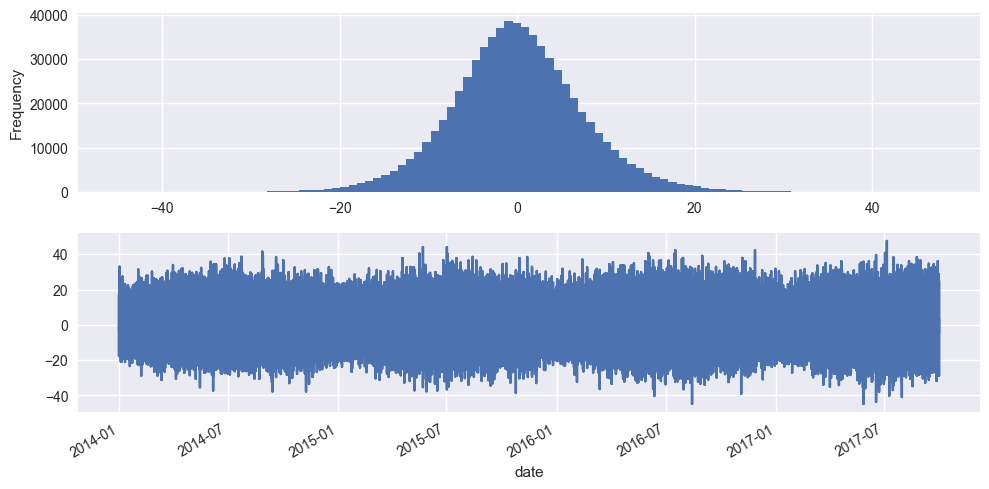

In [185]:
f, ax = plt.subplots(2,1, figsize=(10,5))
res.plot.hist(ax=ax[0], bins=100)
res.plot(ax=ax[1])
plt.tight_layout()
plt.show();

### xgb for individual store-items

In [186]:
def get_xgb_forecast(train, valid, **f_kwargs):
    X_train = train[f_kwargs['features']]
    y_train = train[f_kwargs['target']]
    X_valid = valid[f_kwargs['features']]
    y_valid = valid[f_kwargs['target']]

    reg = xgb.XGBRegressor(**f_kwargs['booster_params'])
    
    if f_kwargs['validation']:
        reg.fit(X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                verbose=100)
    else:
        reg.fit(X_train,
                y_train,
                eval_set=[(X_train, y_train)],
                verbose=100)
    
    preds_train = reg.predict(X_train)
    preds_valid = reg.predict(X_valid)
    
    return preds_train, preds_valid

In [187]:
kwargs_xgb = {
    'name' : 'xgb_indiv',
    'f_kwargs' : {
        'features' : features[2:],
        'target' : 'sales',
        'booster_params' : {
            'booster' : 'gbtree', 
            'n_estimators' : 1000,
            'early_stopping_rounds' : 500,
            'objective' : 'reg:linear',
            'max_depth' : 3,
            'learning_rate' : 0.01
        },
        'validation' : True
    }
}

train_res, valid_res, si_scores_df, scores_df = utils.run_model(train_res, valid_res, 
                                               si_scores_df, scores_df,
                                               get_xgb_forecast, **kwargs_xgb)

[0]	validation_0-rmse:6.73739	validation_1-rmse:5.84664
[100]	validation_0-rmse:4.83072	validation_1-rmse:4.88587
[200]	validation_0-rmse:4.32941	validation_1-rmse:4.64240
[300]	validation_0-rmse:4.15612	validation_1-rmse:4.59580
[400]	validation_0-rmse:4.06613	validation_1-rmse:4.59368
[500]	validation_0-rmse:4.01191	validation_1-rmse:4.61340
[600]	validation_0-rmse:3.96769	validation_1-rmse:4.67664
[700]	validation_0-rmse:3.92076	validation_1-rmse:4.72330
[800]	validation_0-rmse:3.86728	validation_1-rmse:4.78043
[830]	validation_0-rmse:3.85229	validation_1-rmse:4.79942
(1,1)  train : 16.6979      valid : 19.9942
[0]	validation_0-rmse:8.59805	validation_1-rmse:8.51537
[100]	validation_0-rmse:5.89922	validation_1-rmse:7.13012
[200]	validation_0-rmse:5.19204	validation_1-rmse:6.73268
[300]	validation_0-rmse:4.97382	validation_1-rmse:6.88106
[400]	validation_0-rmse:4.87029	validation_1-rmse:6.89905
[500]	validation_0-rmse:4.81265	validation_1-rmse:6.89866
[600]	validation_0-rmse:4.76211	

(2,3)  train : 9.3093      valid : 8.6955
[0]	validation_0-rmse:17.12777	validation_1-rmse:13.28165
[100]	validation_0-rmse:10.22011	validation_1-rmse:8.62434
[200]	validation_0-rmse:8.25276	validation_1-rmse:7.84256
[300]	validation_0-rmse:7.67366	validation_1-rmse:7.78592
[400]	validation_0-rmse:7.42665	validation_1-rmse:7.89336
[500]	validation_0-rmse:7.29508	validation_1-rmse:7.91122
[600]	validation_0-rmse:7.17485	validation_1-rmse:8.00276
[700]	validation_0-rmse:7.07014	validation_1-rmse:8.16798
[773]	validation_0-rmse:6.99330	validation_1-rmse:8.28107
(2,4)  train : 10.0402      valid : 10.0665
[0]	validation_0-rmse:12.52565	validation_1-rmse:11.08204
[100]	validation_0-rmse:8.08616	validation_1-rmse:8.52421
[200]	validation_0-rmse:6.85778	validation_1-rmse:7.84448
[300]	validation_0-rmse:6.47493	validation_1-rmse:7.68521
[400]	validation_0-rmse:6.33013	validation_1-rmse:7.72130
[500]	validation_0-rmse:6.20982	validation_1-rmse:7.83646
[600]	validation_0-rmse:6.10217	validation_

[400]	validation_0-rmse:4.92856	validation_1-rmse:6.04537
[500]	validation_0-rmse:4.84635	validation_1-rmse:6.17805
[600]	validation_0-rmse:4.78141	validation_1-rmse:6.27791
[700]	validation_0-rmse:4.71422	validation_1-rmse:6.32422
[749]	validation_0-rmse:4.68547	validation_1-rmse:6.34178
(3,6)  train : 15.008      valid : 17.6365
[0]	validation_0-rmse:8.12719	validation_1-rmse:8.04913
[100]	validation_0-rmse:5.72757	validation_1-rmse:6.44899
[200]	validation_0-rmse:5.07283	validation_1-rmse:6.03592
[300]	validation_0-rmse:4.84730	validation_1-rmse:5.87341
[400]	validation_0-rmse:4.73419	validation_1-rmse:5.83653
[500]	validation_0-rmse:4.65253	validation_1-rmse:5.75272
[600]	validation_0-rmse:4.59229	validation_1-rmse:5.68334
[700]	validation_0-rmse:4.53763	validation_1-rmse:5.64518
[800]	validation_0-rmse:4.48816	validation_1-rmse:5.61499
[900]	validation_0-rmse:4.44274	validation_1-rmse:5.59314
[999]	validation_0-rmse:4.39273	validation_1-rmse:5.57862
(3,7)  train : 13.6682      val

[200]	validation_0-rmse:4.84041	validation_1-rmse:5.71481
[300]	validation_0-rmse:4.63726	validation_1-rmse:5.68300
[400]	validation_0-rmse:4.52792	validation_1-rmse:5.67855
[500]	validation_0-rmse:4.45106	validation_1-rmse:5.65134
[600]	validation_0-rmse:4.38804	validation_1-rmse:5.65071
[700]	validation_0-rmse:4.32727	validation_1-rmse:5.67537
[800]	validation_0-rmse:4.26985	validation_1-rmse:5.67720
[900]	validation_0-rmse:4.21010	validation_1-rmse:5.69746
[999]	validation_0-rmse:4.15507	validation_1-rmse:5.73603
(4,9)  train : 15.7496      valid : 18.4364
[0]	validation_0-rmse:7.68829	validation_1-rmse:7.32035
[100]	validation_0-rmse:5.50017	validation_1-rmse:6.41958
[200]	validation_0-rmse:4.91342	validation_1-rmse:6.22768
[300]	validation_0-rmse:4.71501	validation_1-rmse:6.16152
[400]	validation_0-rmse:4.61260	validation_1-rmse:6.18197
[500]	validation_0-rmse:4.55465	validation_1-rmse:6.19573
[600]	validation_0-rmse:4.50902	validation_1-rmse:6.20236
[700]	validation_0-rmse:4.4632

[700]	validation_0-rmse:6.59165	validation_1-rmse:7.88270
[800]	validation_0-rmse:6.51425	validation_1-rmse:7.81014
[900]	validation_0-rmse:6.43963	validation_1-rmse:7.74351
[999]	validation_0-rmse:6.36354	validation_1-rmse:7.68585
(6,1)  train : 9.5698      valid : 11.0061
[0]	validation_0-rmse:20.29092	validation_1-rmse:16.03061
[100]	validation_0-rmse:11.73132	validation_1-rmse:10.71473
[200]	validation_0-rmse:9.18595	validation_1-rmse:10.02981
[300]	validation_0-rmse:8.39512	validation_1-rmse:9.96825
[400]	validation_0-rmse:8.08978	validation_1-rmse:9.99555
[500]	validation_0-rmse:7.92248	validation_1-rmse:10.04890
[600]	validation_0-rmse:7.81698	validation_1-rmse:10.06313
[700]	validation_0-rmse:7.73324	validation_1-rmse:10.12119
[800]	validation_0-rmse:7.65175	validation_1-rmse:10.17937
[832]	validation_0-rmse:7.62172	validation_1-rmse:10.20056
(6,2)  train : 8.637      valid : 10.3835
[0]	validation_0-rmse:18.39347	validation_1-rmse:14.25671
[100]	validation_0-rmse:10.80454	vali

[100]	validation_0-rmse:10.45469	validation_1-rmse:10.15425
[200]	validation_0-rmse:8.50999	validation_1-rmse:8.96768
[300]	validation_0-rmse:7.92653	validation_1-rmse:8.69212
[400]	validation_0-rmse:7.68608	validation_1-rmse:8.67196
[500]	validation_0-rmse:7.53860	validation_1-rmse:8.63393
[600]	validation_0-rmse:7.44610	validation_1-rmse:8.61759
[700]	validation_0-rmse:7.36627	validation_1-rmse:8.58911
[800]	validation_0-rmse:7.27834	validation_1-rmse:8.58263
[900]	validation_0-rmse:7.20262	validation_1-rmse:8.59363
[999]	validation_0-rmse:7.12335	validation_1-rmse:8.62556
(7,4)  train : 9.4253      valid : 10.8663
[0]	validation_0-rmse:12.77640	validation_1-rmse:11.60859
[100]	validation_0-rmse:8.10410	validation_1-rmse:8.16618
[200]	validation_0-rmse:6.81297	validation_1-rmse:6.89345
[300]	validation_0-rmse:6.41291	validation_1-rmse:6.67498
[400]	validation_0-rmse:6.22571	validation_1-rmse:6.76849
[500]	validation_0-rmse:6.12224	validation_1-rmse:6.75857
[600]	validation_0-rmse:6.0

[700]	validation_0-rmse:6.88149	validation_1-rmse:8.04977
[800]	validation_0-rmse:6.77888	validation_1-rmse:8.08715
[900]	validation_0-rmse:6.67837	validation_1-rmse:8.13091
[912]	validation_0-rmse:6.66694	validation_1-rmse:8.13599
(8,6)  train : 9.9267      valid : 10.4128
[0]	validation_0-rmse:14.63748	validation_1-rmse:12.30955
[100]	validation_0-rmse:8.93657	validation_1-rmse:9.39954
[200]	validation_0-rmse:7.32800	validation_1-rmse:8.51025
[300]	validation_0-rmse:6.83670	validation_1-rmse:8.24607
[400]	validation_0-rmse:6.62487	validation_1-rmse:8.15392
[500]	validation_0-rmse:6.50984	validation_1-rmse:8.13649
[600]	validation_0-rmse:6.41783	validation_1-rmse:8.10608
[700]	validation_0-rmse:6.32102	validation_1-rmse:8.09015
[800]	validation_0-rmse:6.22922	validation_1-rmse:8.03291
[900]	validation_0-rmse:6.14826	validation_1-rmse:8.02182
[999]	validation_0-rmse:6.06812	validation_1-rmse:8.01894
(8,7)  train : 9.0165      valid : 12.3386
[0]	validation_0-rmse:24.95764	validation_1-

[800]	validation_0-rmse:7.06936	validation_1-rmse:9.00157
[900]	validation_0-rmse:6.98728	validation_1-rmse:9.02583
[999]	validation_0-rmse:6.91057	validation_1-rmse:9.02572
(9,8)  train : 8.9886      valid : 11.0487
[0]	validation_0-rmse:15.05861	validation_1-rmse:12.95430
[100]	validation_0-rmse:9.25007	validation_1-rmse:9.29162
[200]	validation_0-rmse:7.54214	validation_1-rmse:8.17249
[300]	validation_0-rmse:7.00001	validation_1-rmse:7.97093
[400]	validation_0-rmse:6.77528	validation_1-rmse:7.85322
[500]	validation_0-rmse:6.63918	validation_1-rmse:7.75333
[600]	validation_0-rmse:6.53651	validation_1-rmse:7.70679
[700]	validation_0-rmse:6.44500	validation_1-rmse:7.66672
[800]	validation_0-rmse:6.35615	validation_1-rmse:7.64571
[900]	validation_0-rmse:6.27976	validation_1-rmse:7.62800
[999]	validation_0-rmse:6.21112	validation_1-rmse:7.62023
(9,9)  train : 9.13      valid : 11.5495
[0]	validation_0-rmse:16.01884	validation_1-rmse:14.09161
[100]	validation_0-rmse:9.55226	validation_1-r

[700]	validation_0-rmse:8.15466	validation_1-rmse:11.08748
[768]	validation_0-rmse:8.08606	validation_1-rmse:11.12650
(10,10)  train : 8.8455      valid : 11.0531
-----------------------------------------------------
Item 10 Train sMAPE : 8.7606
Item 10 Valid sMAPE : 10.2891
-----------------------------------------------------

[0]	validation_0-rmse:17.11001	validation_1-rmse:15.49148
[100]	validation_0-rmse:10.22338	validation_1-rmse:10.56673
[200]	validation_0-rmse:8.22480	validation_1-rmse:9.30627
[300]	validation_0-rmse:7.62352	validation_1-rmse:8.90763
[400]	validation_0-rmse:7.39330	validation_1-rmse:8.84377
[500]	validation_0-rmse:7.25121	validation_1-rmse:8.82820
[600]	validation_0-rmse:7.14568	validation_1-rmse:8.84040
[700]	validation_0-rmse:7.03300	validation_1-rmse:8.83443
[800]	validation_0-rmse:6.92808	validation_1-rmse:8.89283
[900]	validation_0-rmse:6.83064	validation_1-rmse:8.93796
[999]	validation_0-rmse:6.74746	validation_1-rmse:8.98191
(11,1)  train : 8.8126      v

[900]	validation_0-rmse:8.59525	validation_1-rmse:11.30817
[999]	validation_0-rmse:8.51051	validation_1-rmse:11.42139
(12,2)  train : 7.9609      valid : 9.6071
[0]	validation_0-rmse:21.08080	validation_1-rmse:17.81944
[100]	validation_0-rmse:12.14990	validation_1-rmse:12.13499
[200]	validation_0-rmse:9.43843	validation_1-rmse:10.38768
[300]	validation_0-rmse:8.65617	validation_1-rmse:9.93705
[400]	validation_0-rmse:8.33912	validation_1-rmse:9.85798
[500]	validation_0-rmse:8.14299	validation_1-rmse:9.87512
[600]	validation_0-rmse:8.00846	validation_1-rmse:9.84668
[700]	validation_0-rmse:7.90806	validation_1-rmse:9.85462
[800]	validation_0-rmse:7.81299	validation_1-rmse:9.85394
[880]	validation_0-rmse:7.73629	validation_1-rmse:9.85887
(12,3)  train : 8.5249      valid : 10.1656
[0]	validation_0-rmse:19.81703	validation_1-rmse:16.07469
[100]	validation_0-rmse:11.55225	validation_1-rmse:11.20781
[200]	validation_0-rmse:9.08326	validation_1-rmse:9.84902
[300]	validation_0-rmse:8.34551	vali

[900]	validation_0-rmse:7.94448	validation_1-rmse:11.00269
[999]	validation_0-rmse:7.85051	validation_1-rmse:11.03922
(13,4)  train : 7.3958      valid : 9.185
[0]	validation_0-rmse:17.42047	validation_1-rmse:16.66154
[100]	validation_0-rmse:10.36811	validation_1-rmse:11.51119
[200]	validation_0-rmse:8.34342	validation_1-rmse:10.19777
[300]	validation_0-rmse:7.73542	validation_1-rmse:9.79519
[400]	validation_0-rmse:7.48589	validation_1-rmse:9.73555
[500]	validation_0-rmse:7.34513	validation_1-rmse:9.73124
[600]	validation_0-rmse:7.25261	validation_1-rmse:9.73240
[700]	validation_0-rmse:7.16944	validation_1-rmse:9.71779
[800]	validation_0-rmse:7.08738	validation_1-rmse:9.69330
[900]	validation_0-rmse:7.00843	validation_1-rmse:9.69277
[999]	validation_0-rmse:6.94332	validation_1-rmse:9.70143
(13,5)  train : 8.7431      valid : 12.1161
[0]	validation_0-rmse:17.64076	validation_1-rmse:16.79487
[100]	validation_0-rmse:10.43809	validation_1-rmse:11.93549
[200]	validation_0-rmse:8.32378	valid

(14,6)  train : 11.6294      valid : 12.9074
[0]	validation_0-rmse:11.61499	validation_1-rmse:9.69134
[100]	validation_0-rmse:7.61866	validation_1-rmse:7.11640
[200]	validation_0-rmse:6.52412	validation_1-rmse:6.48194
[300]	validation_0-rmse:6.16636	validation_1-rmse:6.34240
[400]	validation_0-rmse:5.99410	validation_1-rmse:6.36766
[500]	validation_0-rmse:5.88529	validation_1-rmse:6.40527
[600]	validation_0-rmse:5.80612	validation_1-rmse:6.49522
[700]	validation_0-rmse:5.74293	validation_1-rmse:6.60387
[800]	validation_0-rmse:5.67292	validation_1-rmse:6.62733
[833]	validation_0-rmse:5.64520	validation_1-rmse:6.65048
(14,7)  train : 11.7908      valid : 11.5349
[0]	validation_0-rmse:19.39285	validation_1-rmse:15.62902
[100]	validation_0-rmse:11.55062	validation_1-rmse:10.56809
[200]	validation_0-rmse:9.21440	validation_1-rmse:9.44108
[300]	validation_0-rmse:8.52374	validation_1-rmse:9.25469
[400]	validation_0-rmse:8.25380	validation_1-rmse:9.34022
[500]	validation_0-rmse:8.12360	validat

[300]	validation_0-rmse:9.46384	validation_1-rmse:11.72162
[400]	validation_0-rmse:9.12902	validation_1-rmse:11.59976
[500]	validation_0-rmse:8.93993	validation_1-rmse:11.57545
[600]	validation_0-rmse:8.79909	validation_1-rmse:11.60637
[700]	validation_0-rmse:8.67967	validation_1-rmse:11.62800
[800]	validation_0-rmse:8.57135	validation_1-rmse:11.71394
[900]	validation_0-rmse:8.46763	validation_1-rmse:11.84400
[964]	validation_0-rmse:8.40105	validation_1-rmse:11.93293
(15,9)  train : 7.5953      valid : 9.6315
[0]	validation_0-rmse:25.55469	validation_1-rmse:21.00298
[100]	validation_0-rmse:14.22991	validation_1-rmse:14.41020
[200]	validation_0-rmse:10.75923	validation_1-rmse:12.43106
[300]	validation_0-rmse:9.73315	validation_1-rmse:11.94398
[400]	validation_0-rmse:9.35521	validation_1-rmse:11.81526
[500]	validation_0-rmse:9.18091	validation_1-rmse:11.77199
[600]	validation_0-rmse:9.07158	validation_1-rmse:11.77292
[700]	validation_0-rmse:8.97353	validation_1-rmse:11.75771
[800]	valida

[500]	validation_0-rmse:4.98553	validation_1-rmse:5.56733
[600]	validation_0-rmse:4.91384	validation_1-rmse:5.58528
[700]	validation_0-rmse:4.85403	validation_1-rmse:5.58568
[800]	validation_0-rmse:4.80061	validation_1-rmse:5.58963
[900]	validation_0-rmse:4.74467	validation_1-rmse:5.59382
[902]	validation_0-rmse:4.74376	validation_1-rmse:5.59384
(17,1)  train : 13.7582      valid : 15.4025
[0]	validation_0-rmse:12.15028	validation_1-rmse:10.59916
[100]	validation_0-rmse:7.93776	validation_1-rmse:8.64908
[200]	validation_0-rmse:6.79292	validation_1-rmse:7.88192
[300]	validation_0-rmse:6.41595	validation_1-rmse:7.73260
[400]	validation_0-rmse:6.23930	validation_1-rmse:7.70788
[500]	validation_0-rmse:6.14096	validation_1-rmse:7.67935
[600]	validation_0-rmse:6.07341	validation_1-rmse:7.70403
[700]	validation_0-rmse:6.00567	validation_1-rmse:7.75404
[800]	validation_0-rmse:5.93731	validation_1-rmse:7.79569
[900]	validation_0-rmse:5.87148	validation_1-rmse:7.79686
[999]	validation_0-rmse:5.8

[100]	validation_0-rmse:13.35996	validation_1-rmse:13.77867
[200]	validation_0-rmse:10.35357	validation_1-rmse:11.92087
[300]	validation_0-rmse:9.47340	validation_1-rmse:11.22176
[400]	validation_0-rmse:9.14484	validation_1-rmse:10.97975
[500]	validation_0-rmse:8.95207	validation_1-rmse:10.79143
[600]	validation_0-rmse:8.80121	validation_1-rmse:10.67823
[700]	validation_0-rmse:8.68079	validation_1-rmse:10.71394
[800]	validation_0-rmse:8.56004	validation_1-rmse:10.72458
[900]	validation_0-rmse:8.45587	validation_1-rmse:10.81261
[999]	validation_0-rmse:8.34449	validation_1-rmse:10.94504
(18,4)  train : 7.8543      valid : 9.5818
[0]	validation_0-rmse:17.33078	validation_1-rmse:13.50973
[100]	validation_0-rmse:10.42549	validation_1-rmse:9.46551
[200]	validation_0-rmse:8.40677	validation_1-rmse:8.48259
[300]	validation_0-rmse:7.79566	validation_1-rmse:8.24341
[400]	validation_0-rmse:7.54633	validation_1-rmse:8.23713
[500]	validation_0-rmse:7.40328	validation_1-rmse:8.28688
[600]	validation

[400]	validation_0-rmse:5.31750	validation_1-rmse:6.21526
[500]	validation_0-rmse:5.22584	validation_1-rmse:6.28548
[600]	validation_0-rmse:5.15061	validation_1-rmse:6.31754
[700]	validation_0-rmse:5.09119	validation_1-rmse:6.33894
[782]	validation_0-rmse:5.04475	validation_1-rmse:6.35594
(19,6)  train : 14.265      valid : 15.06
[0]	validation_0-rmse:8.83880	validation_1-rmse:8.41369
[100]	validation_0-rmse:6.12731	validation_1-rmse:6.75490
[200]	validation_0-rmse:5.41097	validation_1-rmse:6.30175
[300]	validation_0-rmse:5.17042	validation_1-rmse:6.14317
[400]	validation_0-rmse:5.04068	validation_1-rmse:6.08960
[500]	validation_0-rmse:4.95077	validation_1-rmse:6.07705
[600]	validation_0-rmse:4.89018	validation_1-rmse:6.07853
[700]	validation_0-rmse:4.83739	validation_1-rmse:6.07925
[800]	validation_0-rmse:4.78207	validation_1-rmse:6.09537
[900]	validation_0-rmse:4.72979	validation_1-rmse:6.10893
[999]	validation_0-rmse:4.68010	validation_1-rmse:6.12874
(19,7)  train : 14.088      vali

[500]	validation_0-rmse:6.36411	validation_1-rmse:7.67359
[600]	validation_0-rmse:6.27354	validation_1-rmse:7.69891
[700]	validation_0-rmse:6.18636	validation_1-rmse:7.67922
[800]	validation_0-rmse:6.09679	validation_1-rmse:7.68781
[900]	validation_0-rmse:6.00917	validation_1-rmse:7.70030
[999]	validation_0-rmse:5.92749	validation_1-rmse:7.70014
(20,9)  train : 10.1591      valid : 11.3519
[0]	validation_0-rmse:14.88834	validation_1-rmse:11.72271
[100]	validation_0-rmse:9.15011	validation_1-rmse:8.68841
[200]	validation_0-rmse:7.51449	validation_1-rmse:7.88215
[300]	validation_0-rmse:7.01378	validation_1-rmse:7.66717
[400]	validation_0-rmse:6.80735	validation_1-rmse:7.63826
[500]	validation_0-rmse:6.68092	validation_1-rmse:7.63402
[600]	validation_0-rmse:6.60944	validation_1-rmse:7.68721
[700]	validation_0-rmse:6.54347	validation_1-rmse:7.73553
[800]	validation_0-rmse:6.47216	validation_1-rmse:7.75696
[900]	validation_0-rmse:6.40032	validation_1-rmse:7.78807
[966]	validation_0-rmse:6.3

(22,1)  train : 9.0516      valid : 9.1342
[0]	validation_0-rmse:26.66034	validation_1-rmse:21.09792
[100]	validation_0-rmse:14.81057	validation_1-rmse:12.82380
[200]	validation_0-rmse:11.16590	validation_1-rmse:10.65244
[300]	validation_0-rmse:10.08569	validation_1-rmse:9.92410
[400]	validation_0-rmse:9.67600	validation_1-rmse:9.72551
[500]	validation_0-rmse:9.46513	validation_1-rmse:9.62400
[600]	validation_0-rmse:9.30759	validation_1-rmse:9.66187
[700]	validation_0-rmse:9.18701	validation_1-rmse:9.69339
[800]	validation_0-rmse:9.07965	validation_1-rmse:9.72281
[900]	validation_0-rmse:8.96647	validation_1-rmse:9.77226
[989]	validation_0-rmse:8.88022	validation_1-rmse:9.82784
(22,2)  train : 7.2325      valid : 7.1627
[0]	validation_0-rmse:24.27317	validation_1-rmse:20.71268
[100]	validation_0-rmse:13.57939	validation_1-rmse:13.52172
[200]	validation_0-rmse:10.32340	validation_1-rmse:11.37691
[300]	validation_0-rmse:9.33983	validation_1-rmse:10.55216
[400]	validation_0-rmse:8.98243	va

[200]	validation_0-rmse:5.53985	validation_1-rmse:6.82312
[300]	validation_0-rmse:5.28312	validation_1-rmse:6.76896
[400]	validation_0-rmse:5.16532	validation_1-rmse:6.75229
[500]	validation_0-rmse:5.08429	validation_1-rmse:6.73510
[600]	validation_0-rmse:5.00681	validation_1-rmse:6.70936
[700]	validation_0-rmse:4.93761	validation_1-rmse:6.71048
[800]	validation_0-rmse:4.87218	validation_1-rmse:6.74065
[900]	validation_0-rmse:4.81393	validation_1-rmse:6.77377
[999]	validation_0-rmse:4.75605	validation_1-rmse:6.79630
(23,4)  train : 12.7843      valid : 17.7071
[0]	validation_0-rmse:7.20267	validation_1-rmse:6.18877
[100]	validation_0-rmse:5.26409	validation_1-rmse:5.28702
[200]	validation_0-rmse:4.75196	validation_1-rmse:5.19796
[300]	validation_0-rmse:4.55590	validation_1-rmse:5.19731
[400]	validation_0-rmse:4.44841	validation_1-rmse:5.22611
[500]	validation_0-rmse:4.37137	validation_1-rmse:5.22466
[600]	validation_0-rmse:4.30773	validation_1-rmse:5.22031
[700]	validation_0-rmse:4.250

[100]	validation_0-rmse:8.08333	validation_1-rmse:8.39222
[200]	validation_0-rmse:6.77326	validation_1-rmse:7.77315
[300]	validation_0-rmse:6.37647	validation_1-rmse:7.62292
[400]	validation_0-rmse:6.19702	validation_1-rmse:7.63297
[500]	validation_0-rmse:6.08638	validation_1-rmse:7.68820
[600]	validation_0-rmse:5.98847	validation_1-rmse:7.72200
[700]	validation_0-rmse:5.90325	validation_1-rmse:7.74055
[800]	validation_0-rmse:5.82572	validation_1-rmse:7.77658
[820]	validation_0-rmse:5.80883	validation_1-rmse:7.77924
(24,7)  train : 10.9934      valid : 12.2864
[0]	validation_0-rmse:21.82615	validation_1-rmse:17.87145
[100]	validation_0-rmse:12.58606	validation_1-rmse:12.29752
[200]	validation_0-rmse:9.87768	validation_1-rmse:10.77117
[300]	validation_0-rmse:9.07432	validation_1-rmse:10.32245
[400]	validation_0-rmse:8.75894	validation_1-rmse:10.25414
[500]	validation_0-rmse:8.60578	validation_1-rmse:10.14076
[600]	validation_0-rmse:8.50182	validation_1-rmse:10.06500
[700]	validation_0-r

[100]	validation_0-rmse:13.13852	validation_1-rmse:12.77125
[200]	validation_0-rmse:10.22523	validation_1-rmse:11.02213
[300]	validation_0-rmse:9.32432	validation_1-rmse:10.66700
[400]	validation_0-rmse:8.99071	validation_1-rmse:10.47150
[500]	validation_0-rmse:8.80791	validation_1-rmse:10.39988
[600]	validation_0-rmse:8.69175	validation_1-rmse:10.46244
[700]	validation_0-rmse:8.57745	validation_1-rmse:10.49826
[800]	validation_0-rmse:8.48525	validation_1-rmse:10.54070
[900]	validation_0-rmse:8.38962	validation_1-rmse:10.58437
[999]	validation_0-rmse:8.29964	validation_1-rmse:10.64313
(25,9)  train : 8.0842      valid : 8.9947
[0]	validation_0-rmse:23.92642	validation_1-rmse:20.74691
[100]	validation_0-rmse:13.42894	validation_1-rmse:12.99396
[200]	validation_0-rmse:10.20980	validation_1-rmse:11.10743
[300]	validation_0-rmse:9.24882	validation_1-rmse:10.66301
[400]	validation_0-rmse:8.87348	validation_1-rmse:10.52411
[500]	validation_0-rmse:8.68093	validation_1-rmse:10.49843
[600]	vali

[100]	validation_0-rmse:4.93836	validation_1-rmse:4.14351
[200]	validation_0-rmse:4.49235	validation_1-rmse:4.00634
[300]	validation_0-rmse:4.33443	validation_1-rmse:3.99395
[400]	validation_0-rmse:4.22989	validation_1-rmse:4.09957
[500]	validation_0-rmse:4.15885	validation_1-rmse:4.12265
[600]	validation_0-rmse:4.09371	validation_1-rmse:4.10459
[700]	validation_0-rmse:4.03124	validation_1-rmse:4.11554
[771]	validation_0-rmse:3.98812	validation_1-rmse:4.11144
(27,1)  train : 17.8491      valid : 15.892
[0]	validation_0-rmse:8.83907	validation_1-rmse:7.22091
[100]	validation_0-rmse:6.19048	validation_1-rmse:5.61570
[200]	validation_0-rmse:5.49179	validation_1-rmse:5.37754
[300]	validation_0-rmse:5.24975	validation_1-rmse:5.30979
[400]	validation_0-rmse:5.13252	validation_1-rmse:5.28205
[500]	validation_0-rmse:5.04798	validation_1-rmse:5.28532
[600]	validation_0-rmse:4.96500	validation_1-rmse:5.27565
[700]	validation_0-rmse:4.89245	validation_1-rmse:5.28013
[800]	validation_0-rmse:4.8279

[800]	validation_0-rmse:8.94888	validation_1-rmse:12.23123
[869]	validation_0-rmse:8.87375	validation_1-rmse:12.30615
(28,3)  train : 7.5609      valid : 9.6614
[0]	validation_0-rmse:24.55139	validation_1-rmse:19.69828
[100]	validation_0-rmse:14.11846	validation_1-rmse:13.40030
[200]	validation_0-rmse:10.95601	validation_1-rmse:11.97972
[300]	validation_0-rmse:9.97465	validation_1-rmse:11.74727
[400]	validation_0-rmse:9.59380	validation_1-rmse:11.76282
[500]	validation_0-rmse:9.39796	validation_1-rmse:11.90052
[600]	validation_0-rmse:9.25600	validation_1-rmse:12.01712
[700]	validation_0-rmse:9.13119	validation_1-rmse:12.16896
[800]	validation_0-rmse:9.02532	validation_1-rmse:12.24807
[830]	validation_0-rmse:8.99132	validation_1-rmse:12.26951
(28,4)  train : 8.226      valid : 10.2388
[0]	validation_0-rmse:17.94413	validation_1-rmse:13.92711
[100]	validation_0-rmse:10.48565	validation_1-rmse:9.78024
[200]	validation_0-rmse:8.28067	validation_1-rmse:8.97191
[300]	validation_0-rmse:7.6237

[999]	validation_0-rmse:6.45865	validation_1-rmse:8.65082
(29,5)  train : 10.0508      valid : 12.8656
[0]	validation_0-rmse:14.70100	validation_1-rmse:12.58319
[100]	validation_0-rmse:9.11129	validation_1-rmse:9.96209
[200]	validation_0-rmse:7.52093	validation_1-rmse:8.97561
[300]	validation_0-rmse:7.03377	validation_1-rmse:8.48409
[400]	validation_0-rmse:6.82119	validation_1-rmse:8.40419
[500]	validation_0-rmse:6.70401	validation_1-rmse:8.43936
[600]	validation_0-rmse:6.60657	validation_1-rmse:8.53768
[700]	validation_0-rmse:6.51717	validation_1-rmse:8.55159
[800]	validation_0-rmse:6.43964	validation_1-rmse:8.62454
[900]	validation_0-rmse:6.36577	validation_1-rmse:8.74040
[938]	validation_0-rmse:6.33779	validation_1-rmse:8.79299
(29,6)  train : 10.1201      valid : 13.3143
[0]	validation_0-rmse:13.42437	validation_1-rmse:11.22985
[100]	validation_0-rmse:8.51133	validation_1-rmse:8.29884
[200]	validation_0-rmse:7.21335	validation_1-rmse:7.56969
[300]	validation_0-rmse:6.81676	validati

[100]	validation_0-rmse:8.83535	validation_1-rmse:7.81027
[200]	validation_0-rmse:7.35905	validation_1-rmse:6.77855
[300]	validation_0-rmse:6.88756	validation_1-rmse:6.44811
[400]	validation_0-rmse:6.66544	validation_1-rmse:6.44816
[500]	validation_0-rmse:6.54507	validation_1-rmse:6.52606
[600]	validation_0-rmse:6.46105	validation_1-rmse:6.56638
[700]	validation_0-rmse:6.36602	validation_1-rmse:6.63693
[800]	validation_0-rmse:6.27050	validation_1-rmse:6.76778
[853]	validation_0-rmse:6.22985	validation_1-rmse:6.79316
(30,8)  train : 10.9258      valid : 10.6565
[0]	validation_0-rmse:12.28854	validation_1-rmse:11.02264
[100]	validation_0-rmse:7.98227	validation_1-rmse:8.33453
[200]	validation_0-rmse:6.80651	validation_1-rmse:7.72222
[300]	validation_0-rmse:6.45664	validation_1-rmse:7.58713
[400]	validation_0-rmse:6.30549	validation_1-rmse:7.56050
[500]	validation_0-rmse:6.20724	validation_1-rmse:7.57110
[600]	validation_0-rmse:6.14365	validation_1-rmse:7.56912
[700]	validation_0-rmse:6.0

[800]	validation_0-rmse:7.42068	validation_1-rmse:8.36056
[900]	validation_0-rmse:7.32280	validation_1-rmse:8.35521
[999]	validation_0-rmse:7.23785	validation_1-rmse:8.36272
(31,10)  train : 8.7429      valid : 10.3389
-----------------------------------------------------
Item 31 Train sMAPE : 9.8523
Item 31 Valid sMAPE : 10.9472
-----------------------------------------------------

[0]	validation_0-rmse:11.32567	validation_1-rmse:9.76510
[100]	validation_0-rmse:7.48016	validation_1-rmse:7.12344
[200]	validation_0-rmse:6.45447	validation_1-rmse:6.68023
[300]	validation_0-rmse:6.12597	validation_1-rmse:6.55587
[400]	validation_0-rmse:5.97332	validation_1-rmse:6.53698
[500]	validation_0-rmse:5.89525	validation_1-rmse:6.50624
[600]	validation_0-rmse:5.82887	validation_1-rmse:6.50498
[700]	validation_0-rmse:5.76349	validation_1-rmse:6.55027
[800]	validation_0-rmse:5.69602	validation_1-rmse:6.62545
[900]	validation_0-rmse:5.63504	validation_1-rmse:6.78880
[999]	validation_0-rmse:5.57253	va

[900]	validation_0-rmse:8.16034	validation_1-rmse:11.67244
[999]	validation_0-rmse:8.04295	validation_1-rmse:11.64628
(33,2)  train : 7.5797      valid : 9.868
[0]	validation_0-rmse:20.90874	validation_1-rmse:16.63164
[100]	validation_0-rmse:12.06058	validation_1-rmse:10.20693
[200]	validation_0-rmse:9.42982	validation_1-rmse:8.99034
[300]	validation_0-rmse:8.62450	validation_1-rmse:8.57077
[400]	validation_0-rmse:8.31982	validation_1-rmse:8.36308
[500]	validation_0-rmse:8.13517	validation_1-rmse:8.27996
[600]	validation_0-rmse:7.99876	validation_1-rmse:8.26846
[700]	validation_0-rmse:7.87310	validation_1-rmse:8.27148
[800]	validation_0-rmse:7.76822	validation_1-rmse:8.26179
[900]	validation_0-rmse:7.66342	validation_1-rmse:8.25917
[999]	validation_0-rmse:7.56927	validation_1-rmse:8.25568
(33,3)  train : 7.7213      valid : 8.3373
[0]	validation_0-rmse:19.30236	validation_1-rmse:17.02314
[100]	validation_0-rmse:11.25636	validation_1-rmse:11.54675
[200]	validation_0-rmse:8.86549	validat

[100]	validation_0-rmse:4.84896	validation_1-rmse:5.03299
[200]	validation_0-rmse:4.38558	validation_1-rmse:4.92437
[300]	validation_0-rmse:4.20877	validation_1-rmse:5.00030
[400]	validation_0-rmse:4.11630	validation_1-rmse:5.07554
[500]	validation_0-rmse:4.05277	validation_1-rmse:5.13669
[600]	validation_0-rmse:4.00335	validation_1-rmse:5.21767
[700]	validation_0-rmse:3.95738	validation_1-rmse:5.40727
[720]	validation_0-rmse:3.94852	validation_1-rmse:5.46930
(34,5)  train : 17.3795      valid : 19.5112
[0]	validation_0-rmse:6.57983	validation_1-rmse:5.28920
[100]	validation_0-rmse:4.83621	validation_1-rmse:4.29067
[200]	validation_0-rmse:4.37897	validation_1-rmse:4.04439
[300]	validation_0-rmse:4.19975	validation_1-rmse:4.14418
[400]	validation_0-rmse:4.09034	validation_1-rmse:4.41133
[500]	validation_0-rmse:4.01140	validation_1-rmse:4.54441
[600]	validation_0-rmse:3.94670	validation_1-rmse:4.63083
[682]	validation_0-rmse:3.90009	validation_1-rmse:4.67295
(34,6)  train : 18.156      v

[600]	validation_0-rmse:6.00317	validation_1-rmse:7.08386
[700]	validation_0-rmse:5.91510	validation_1-rmse:7.13339
[800]	validation_0-rmse:5.84198	validation_1-rmse:7.20070
[870]	validation_0-rmse:5.79587	validation_1-rmse:7.25185
(35,7)  train : 11.1365      valid : 11.5196
[0]	validation_0-rmse:21.32973	validation_1-rmse:19.17873
[100]	validation_0-rmse:12.19137	validation_1-rmse:14.21257
[200]	validation_0-rmse:9.43439	validation_1-rmse:12.59245
[300]	validation_0-rmse:8.60566	validation_1-rmse:12.10449
[400]	validation_0-rmse:8.28033	validation_1-rmse:11.91992
[500]	validation_0-rmse:8.09040	validation_1-rmse:12.04877
[600]	validation_0-rmse:7.96475	validation_1-rmse:12.22688
[700]	validation_0-rmse:7.86038	validation_1-rmse:12.39819
[800]	validation_0-rmse:7.75838	validation_1-rmse:12.46857
[900]	validation_0-rmse:7.65526	validation_1-rmse:12.49661
[913]	validation_0-rmse:7.64230	validation_1-rmse:12.49919
(35,8)  train : 8.1111      valid : 11.9764
[0]	validation_0-rmse:18.61462

[600]	validation_0-rmse:8.18807	validation_1-rmse:10.04172
[700]	validation_0-rmse:8.07547	validation_1-rmse:10.04992
[800]	validation_0-rmse:7.96551	validation_1-rmse:10.08399
[900]	validation_0-rmse:7.85337	validation_1-rmse:10.02172
[947]	validation_0-rmse:7.80291	validation_1-rmse:9.99369
(36,9)  train : 8.1393      valid : 9.2162
[0]	validation_0-rmse:22.92879	validation_1-rmse:19.55698
[100]	validation_0-rmse:12.98468	validation_1-rmse:12.64878
[200]	validation_0-rmse:9.95170	validation_1-rmse:10.59354
[300]	validation_0-rmse:9.02969	validation_1-rmse:10.05748
[400]	validation_0-rmse:8.68469	validation_1-rmse:10.12997
[500]	validation_0-rmse:8.49734	validation_1-rmse:10.37966
[600]	validation_0-rmse:8.36297	validation_1-rmse:10.52509
[700]	validation_0-rmse:8.25276	validation_1-rmse:10.63188
[800]	validation_0-rmse:8.15769	validation_1-rmse:10.70202
[845]	validation_0-rmse:8.11858	validation_1-rmse:10.75099
(36,10)  train : 8.1241      valid : 9.0662
-----------------------------

[800]	validation_0-rmse:7.69346	validation_1-rmse:10.60388
[826]	validation_0-rmse:7.66800	validation_1-rmse:10.60703
(38,1)  train : 9.0524      valid : 10.2193
[0]	validation_0-rmse:26.80667	validation_1-rmse:22.17188
[100]	validation_0-rmse:14.65978	validation_1-rmse:13.30546
[200]	validation_0-rmse:10.88363	validation_1-rmse:11.34541
[300]	validation_0-rmse:9.77775	validation_1-rmse:10.90149
[400]	validation_0-rmse:9.36755	validation_1-rmse:10.81801
[500]	validation_0-rmse:9.14326	validation_1-rmse:10.92783
[600]	validation_0-rmse:8.97067	validation_1-rmse:11.01998
[700]	validation_0-rmse:8.82672	validation_1-rmse:11.25273
[800]	validation_0-rmse:8.69953	validation_1-rmse:11.49259
[900]	validation_0-rmse:8.58807	validation_1-rmse:11.63270
(38,2)  train : 7.2827      valid : 8.2727
[0]	validation_0-rmse:24.55545	validation_1-rmse:21.07254
[100]	validation_0-rmse:13.81864	validation_1-rmse:14.36591
[200]	validation_0-rmse:10.54390	validation_1-rmse:12.39956
[300]	validation_0-rmse:9.

[100]	validation_0-rmse:8.37059	validation_1-rmse:8.47271
[200]	validation_0-rmse:7.05512	validation_1-rmse:7.83527
[300]	validation_0-rmse:6.63874	validation_1-rmse:7.69177
[400]	validation_0-rmse:6.44428	validation_1-rmse:7.65362
[500]	validation_0-rmse:6.32033	validation_1-rmse:7.65422
[600]	validation_0-rmse:6.22942	validation_1-rmse:7.66234
[700]	validation_0-rmse:6.14494	validation_1-rmse:7.67009
[800]	validation_0-rmse:6.05911	validation_1-rmse:7.68765
[900]	validation_0-rmse:5.97687	validation_1-rmse:7.68854
[946]	validation_0-rmse:5.93712	validation_1-rmse:7.68438
(39,4)  train : 10.8957      valid : 12.6389
[0]	validation_0-rmse:10.06123	validation_1-rmse:9.59837
[100]	validation_0-rmse:6.74265	validation_1-rmse:7.41633
[200]	validation_0-rmse:5.86844	validation_1-rmse:6.97279
[300]	validation_0-rmse:5.57518	validation_1-rmse:6.91308
[400]	validation_0-rmse:5.41240	validation_1-rmse:7.03330
[500]	validation_0-rmse:5.32092	validation_1-rmse:7.24977
[600]	validation_0-rmse:5.25

[800]	validation_0-rmse:4.40473	validation_1-rmse:5.31657
[869]	validation_0-rmse:4.37472	validation_1-rmse:5.35421
(40,6)  train : 16.9649      valid : 17.1806
[0]	validation_0-rmse:6.77137	validation_1-rmse:5.94922
[100]	validation_0-rmse:4.95420	validation_1-rmse:4.73913
[200]	validation_0-rmse:4.45291	validation_1-rmse:4.52734
[300]	validation_0-rmse:4.27594	validation_1-rmse:4.50977
[400]	validation_0-rmse:4.17646	validation_1-rmse:4.55965
[500]	validation_0-rmse:4.10155	validation_1-rmse:4.59202
[600]	validation_0-rmse:4.04434	validation_1-rmse:4.62171
[700]	validation_0-rmse:4.00093	validation_1-rmse:4.63761
[763]	validation_0-rmse:3.97542	validation_1-rmse:4.64398
(40,7)  train : 16.945      valid : 17.3311
[0]	validation_0-rmse:10.47791	validation_1-rmse:9.41722
[100]	validation_0-rmse:6.96758	validation_1-rmse:7.02938
[200]	validation_0-rmse:6.01962	validation_1-rmse:6.36504
[300]	validation_0-rmse:5.72692	validation_1-rmse:6.36186
[400]	validation_0-rmse:5.58107	validation_1

[500]	validation_0-rmse:4.60469	validation_1-rmse:4.75865
[600]	validation_0-rmse:4.53341	validation_1-rmse:4.80246
[700]	validation_0-rmse:4.47010	validation_1-rmse:4.84508
[800]	validation_0-rmse:4.40896	validation_1-rmse:4.88474
[892]	validation_0-rmse:4.34810	validation_1-rmse:4.92618
(41,10)  train : 15.3129      valid : 14.8541
-----------------------------------------------------
Item 41 Train sMAPE : 16.989
Item 41 Valid sMAPE : 19.0508
-----------------------------------------------------

[0]	validation_0-rmse:9.48467	validation_1-rmse:8.85449
[100]	validation_0-rmse:6.46518	validation_1-rmse:6.62883
[200]	validation_0-rmse:5.65665	validation_1-rmse:6.19489
[300]	validation_0-rmse:5.39873	validation_1-rmse:6.18440
[400]	validation_0-rmse:5.26924	validation_1-rmse:6.31636
[500]	validation_0-rmse:5.17530	validation_1-rmse:6.34490
[600]	validation_0-rmse:5.09278	validation_1-rmse:6.38498
[700]	validation_0-rmse:5.01407	validation_1-rmse:6.43951
[760]	validation_0-rmse:4.96802	va

[999]	validation_0-rmse:7.01585	validation_1-rmse:9.46440
(43,2)  train : 8.9111      valid : 10.0687
[0]	validation_0-rmse:15.92405	validation_1-rmse:12.59917
[100]	validation_0-rmse:9.62449	validation_1-rmse:8.52334
[200]	validation_0-rmse:7.79756	validation_1-rmse:7.65259
[300]	validation_0-rmse:7.23950	validation_1-rmse:7.55378
[400]	validation_0-rmse:7.00782	validation_1-rmse:7.56574
[500]	validation_0-rmse:6.87155	validation_1-rmse:7.58730
[600]	validation_0-rmse:6.75982	validation_1-rmse:7.63900
[700]	validation_0-rmse:6.65867	validation_1-rmse:7.66255
[800]	validation_0-rmse:6.56244	validation_1-rmse:7.72571
[815]	validation_0-rmse:6.54905	validation_1-rmse:7.73313
(43,3)  train : 9.9069      valid : 10.5454
[0]	validation_0-rmse:14.92096	validation_1-rmse:13.24277
[100]	validation_0-rmse:9.26153	validation_1-rmse:9.08754
[200]	validation_0-rmse:7.67851	validation_1-rmse:8.20230
[300]	validation_0-rmse:7.19384	validation_1-rmse:8.00759
[400]	validation_0-rmse:6.99523	validation

[300]	validation_0-rmse:4.60674	validation_1-rmse:4.98159
[400]	validation_0-rmse:4.51053	validation_1-rmse:4.99682
[500]	validation_0-rmse:4.43516	validation_1-rmse:5.00298
[600]	validation_0-rmse:4.37461	validation_1-rmse:5.01370
[700]	validation_0-rmse:4.31331	validation_1-rmse:5.02405
[800]	validation_0-rmse:4.26111	validation_1-rmse:5.03569
[821]	validation_0-rmse:4.25001	validation_1-rmse:5.03860
(44,5)  train : 16.2327      valid : 16.9096
[0]	validation_0-rmse:7.20930	validation_1-rmse:6.37743
[100]	validation_0-rmse:5.24510	validation_1-rmse:5.42311
[200]	validation_0-rmse:4.70733	validation_1-rmse:5.25329
[300]	validation_0-rmse:4.51273	validation_1-rmse:5.25248
[400]	validation_0-rmse:4.41130	validation_1-rmse:5.26335
[500]	validation_0-rmse:4.33872	validation_1-rmse:5.28976
[600]	validation_0-rmse:4.27902	validation_1-rmse:5.31410
[700]	validation_0-rmse:4.22875	validation_1-rmse:5.36028
[778]	validation_0-rmse:4.19006	validation_1-rmse:5.39503
(44,6)  train : 16.1504      

[962]	validation_0-rmse:6.44123	validation_1-rmse:8.77699
(45,7)  train : 9.7178      valid : 11.7877
[0]	validation_0-rmse:26.04806	validation_1-rmse:20.85339
[100]	validation_0-rmse:14.56441	validation_1-rmse:15.12277
[200]	validation_0-rmse:11.03300	validation_1-rmse:12.74517
[300]	validation_0-rmse:9.97440	validation_1-rmse:12.37804
[400]	validation_0-rmse:9.58665	validation_1-rmse:12.38292
[500]	validation_0-rmse:9.36498	validation_1-rmse:12.35302
[600]	validation_0-rmse:9.20371	validation_1-rmse:12.40888
[700]	validation_0-rmse:9.07028	validation_1-rmse:12.42829
[800]	validation_0-rmse:8.94014	validation_1-rmse:12.44043
[900]	validation_0-rmse:8.80414	validation_1-rmse:12.44556
[999]	validation_0-rmse:8.67988	validation_1-rmse:12.39525
(45,8)  train : 7.4103      valid : 10.167
[0]	validation_0-rmse:23.05620	validation_1-rmse:18.62120
[100]	validation_0-rmse:13.01667	validation_1-rmse:12.42569
[200]	validation_0-rmse:10.04616	validation_1-rmse:10.83686
[300]	validation_0-rmse:9.1

[800]	validation_0-rmse:7.05350	validation_1-rmse:8.56664
[900]	validation_0-rmse:6.96061	validation_1-rmse:8.57404
[999]	validation_0-rmse:6.87487	validation_1-rmse:8.60257
(46,9)  train : 8.9899      valid : 10.2653
[0]	validation_0-rmse:18.10241	validation_1-rmse:16.10178
[100]	validation_0-rmse:10.69213	validation_1-rmse:11.04402
[200]	validation_0-rmse:8.59679	validation_1-rmse:9.72546
[300]	validation_0-rmse:7.96042	validation_1-rmse:9.33263
[400]	validation_0-rmse:7.70642	validation_1-rmse:9.21400
[500]	validation_0-rmse:7.54847	validation_1-rmse:9.15508
[600]	validation_0-rmse:7.43784	validation_1-rmse:9.16551
[700]	validation_0-rmse:7.32844	validation_1-rmse:9.17942
[800]	validation_0-rmse:7.22654	validation_1-rmse:9.18389
[900]	validation_0-rmse:7.12143	validation_1-rmse:9.22327
[999]	validation_0-rmse:7.01505	validation_1-rmse:9.28253
(46,10)  train : 9.1925      valid : 10.562
-----------------------------------------------------
Item 46 Train sMAPE : 9.7037
Item 46 Valid s

[700]	validation_0-rmse:7.17054	validation_1-rmse:8.33522
[800]	validation_0-rmse:7.09248	validation_1-rmse:8.35679
[830]	validation_0-rmse:7.07124	validation_1-rmse:8.34932
(48,2)  train : 9.1628      valid : 9.6644
[0]	validation_0-rmse:16.26398	validation_1-rmse:13.43247
[100]	validation_0-rmse:9.84192	validation_1-rmse:9.84948
[200]	validation_0-rmse:8.01545	validation_1-rmse:8.88873
[300]	validation_0-rmse:7.45641	validation_1-rmse:8.67056
[400]	validation_0-rmse:7.22744	validation_1-rmse:8.64121
[500]	validation_0-rmse:7.07980	validation_1-rmse:8.60876
[600]	validation_0-rmse:6.95621	validation_1-rmse:8.60599
[700]	validation_0-rmse:6.84547	validation_1-rmse:8.58006
[800]	validation_0-rmse:6.75336	validation_1-rmse:8.53781
[900]	validation_0-rmse:6.67271	validation_1-rmse:8.53151
[999]	validation_0-rmse:6.59667	validation_1-rmse:8.55662
(48,3)  train : 8.9687      valid : 11.4469
[0]	validation_0-rmse:15.15647	validation_1-rmse:12.68780
[100]	validation_0-rmse:9.41894	validation_

[100]	validation_0-rmse:5.42711	validation_1-rmse:4.29008
[200]	validation_0-rmse:4.89773	validation_1-rmse:4.03441
[300]	validation_0-rmse:4.71131	validation_1-rmse:4.02213
[400]	validation_0-rmse:4.61671	validation_1-rmse:4.03283
[500]	validation_0-rmse:4.55801	validation_1-rmse:4.07427
[600]	validation_0-rmse:4.51267	validation_1-rmse:4.31601
[700]	validation_0-rmse:4.46839	validation_1-rmse:4.46153
[800]	validation_0-rmse:4.41782	validation_1-rmse:4.59248
[805]	validation_0-rmse:4.41563	validation_1-rmse:4.59189
(49,5)  train : 16.8351      valid : 13.753
[0]	validation_0-rmse:7.08547	validation_1-rmse:6.62553
[100]	validation_0-rmse:5.06590	validation_1-rmse:5.43604
[200]	validation_0-rmse:4.54707	validation_1-rmse:5.15878
[300]	validation_0-rmse:4.36317	validation_1-rmse:5.17783
[400]	validation_0-rmse:4.27471	validation_1-rmse:5.50821
[500]	validation_0-rmse:4.20064	validation_1-rmse:5.66986
[600]	validation_0-rmse:4.13293	validation_1-rmse:5.78929
[700]	validation_0-rmse:4.0656

[800]	validation_0-rmse:6.03768	validation_1-rmse:7.46686
[900]	validation_0-rmse:5.97195	validation_1-rmse:7.49913
[999]	validation_0-rmse:5.89200	validation_1-rmse:7.53809
(50,7)  train : 10.6604      valid : 11.8541
[0]	validation_0-rmse:21.49217	validation_1-rmse:17.42881
[100]	validation_0-rmse:12.40227	validation_1-rmse:11.56229
[200]	validation_0-rmse:9.72809	validation_1-rmse:9.96990
[300]	validation_0-rmse:8.94769	validation_1-rmse:9.74486
[400]	validation_0-rmse:8.63885	validation_1-rmse:9.59887
[500]	validation_0-rmse:8.46459	validation_1-rmse:9.59603
[600]	validation_0-rmse:8.33318	validation_1-rmse:9.72027
[700]	validation_0-rmse:8.22130	validation_1-rmse:9.78270
[800]	validation_0-rmse:8.12177	validation_1-rmse:9.80764
[900]	validation_0-rmse:8.02279	validation_1-rmse:9.84600
[938]	validation_0-rmse:7.98687	validation_1-rmse:9.87102
(50,8)  train : 8.2502      valid : 9.2979
[0]	validation_0-rmse:18.80706	validation_1-rmse:14.54706
[100]	validation_0-rmse:10.78181	validat

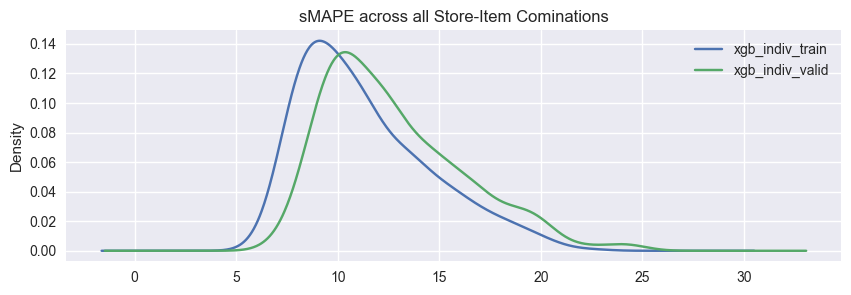

In [188]:
utils.plot_smape(si_scores_df, 'xgb_indiv')

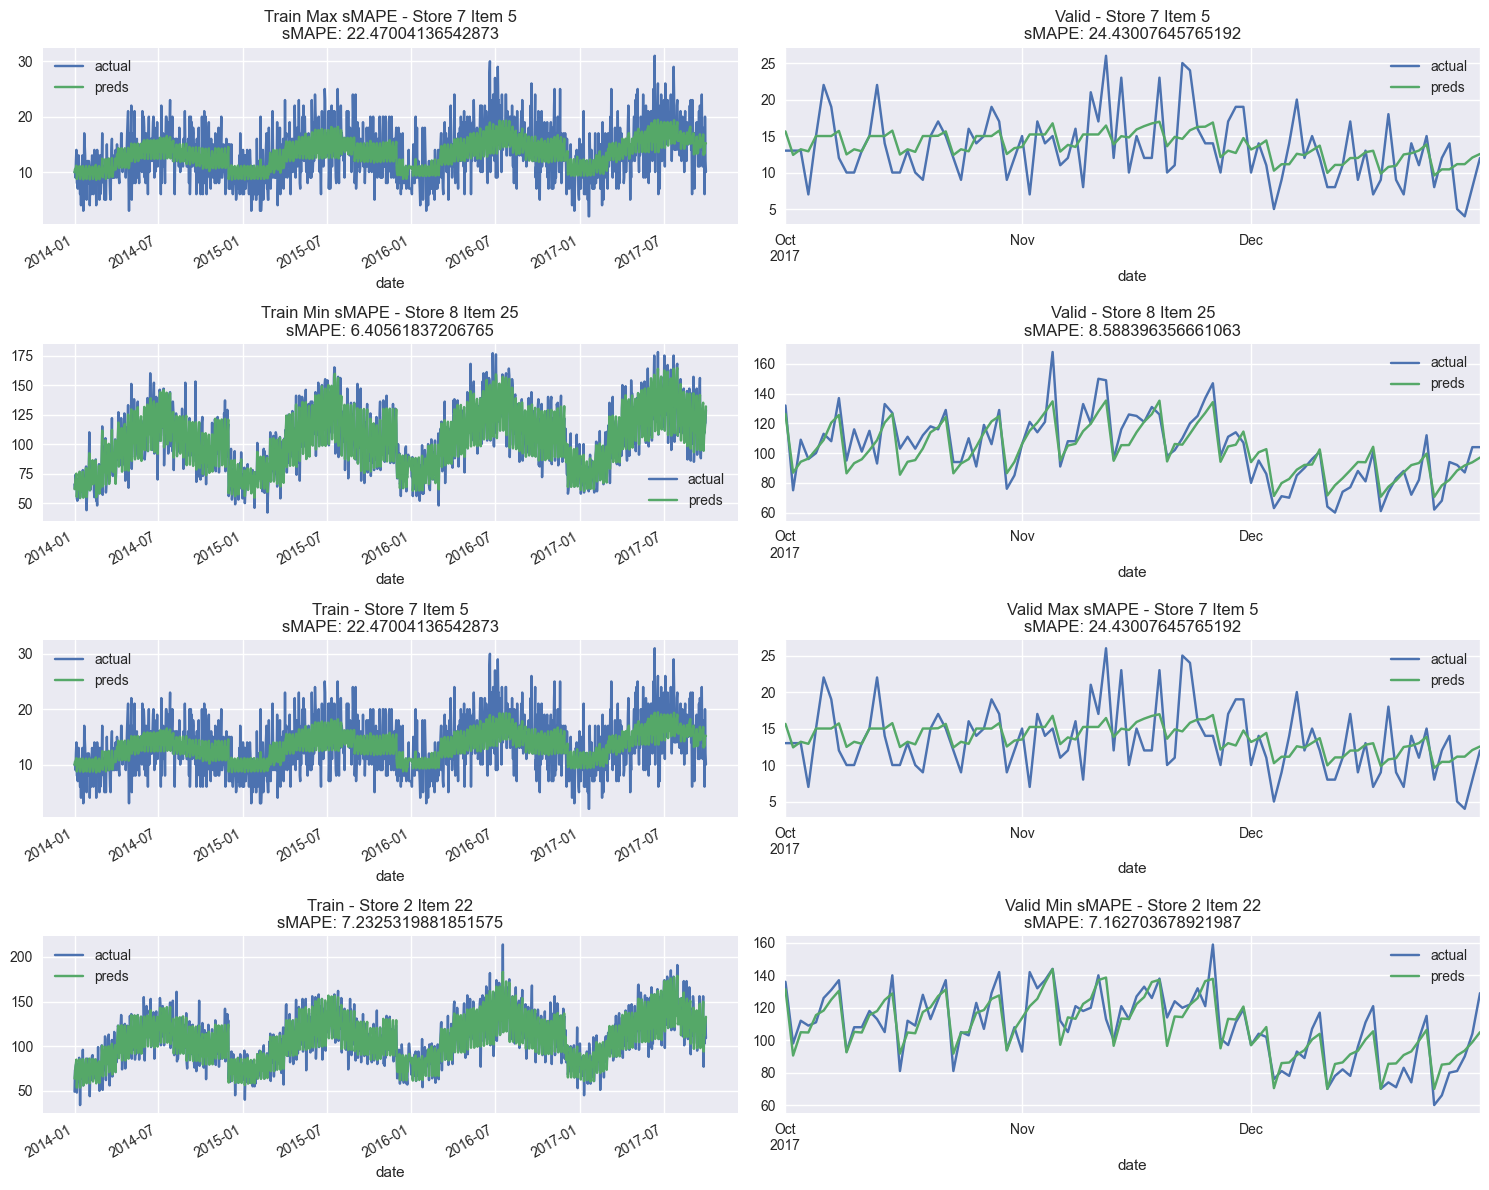

In [189]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'xgb_indiv')

In [190]:
scores_df

train      valid
dtree        12.437039  13.493780
dtree_indiv  13.871189  14.834892
rf           13.558214  14.490352
rf_indiv     10.470880  12.712571
xgb          12.190373  12.385719
xgb_indiv    11.348260  12.764159

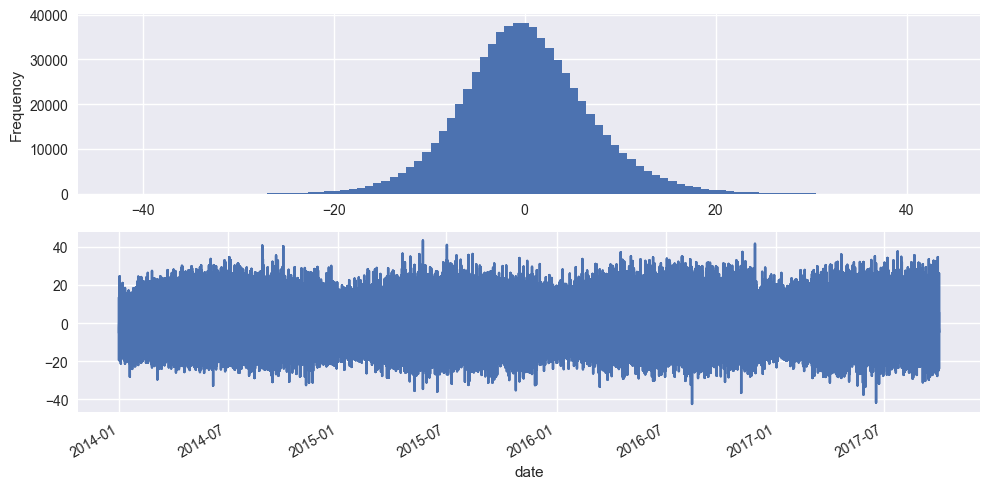

In [191]:
res = train_res.sales - train_res.xgb_indiv

f, ax = plt.subplots(2,1, figsize=(10,5))
res.plot.hist(ax=ax[0], bins=100)
res.plot(ax=ax[1])
plt.tight_layout()
plt.show();

#  Feature Selection

## Permutation Importance 

- Permutation importance is calculated after a model has been fitted. So we won't change the model or change what predictions we'd get. 
- Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?
- Intuitively if a feature is not important, this will not change the accuracy of predictions. However, if a feature is very important, there will be drastic changes.

With this insight, the process is as follows:

1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

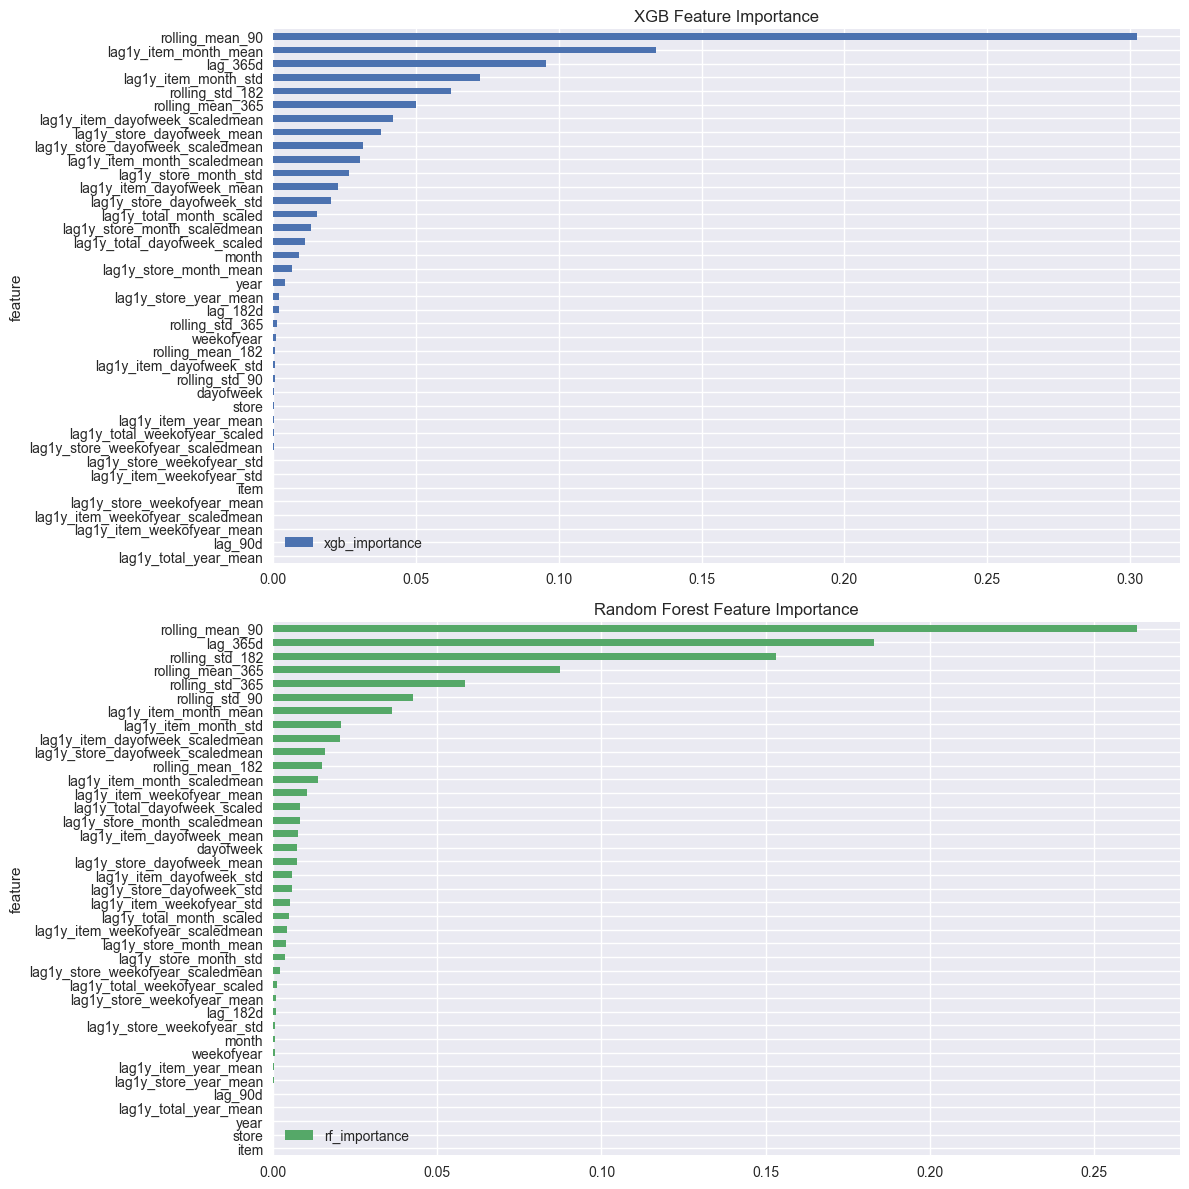

In [192]:
imp_df_xgb = pd.DataFrame({
    "feature": X_train.columns,
    "xgb_importance": xgbreg.feature_importances_
})

imp_df_rf = pd.DataFrame({
    "feature": X_train.columns,
    "rf_importance": rf_regressor.feature_importances_
})

f, ax = plt.subplots(2,1, figsize=(12,12))
imp_df_xgb.sort_values(by="xgb_importance", ascending=True).plot.barh(y='xgb_importance', x='feature', ax=ax[0])
imp_df_rf.sort_values(by="rf_importance", ascending=True).plot.barh(y='rf_importance', x='feature', ax=ax[1], color='C1')
ax[0].set_title('XGB Feature Importance')
ax[1].set_title('Random Forest Feature Importance')
plt.tight_layout()
plt.show();

In [193]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

def calculate_permutation_importance(model, X_val, y_val, feature_names):
    results = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    importance_dict = {feature_names[i]: value for i, value in enumerate(results.importances_mean)}
    sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_importance

In [194]:
feature_importances_xgb = calculate_permutation_importance(xgbreg, X_valid, y_valid, feature_names=X_train.columns.tolist())
feature_importances_rf = calculate_permutation_importance(rf_regressor, X_valid, y_valid, feature_names=X_train.columns.tolist())

In [195]:
importance_threshold = 0.001

important_features_xgb = [feature for feature, importance in feature_importances_xgb if importance > importance_threshold]
important_features_rf = [feature for feature, importance in feature_importances_rf if importance > importance_threshold]

In [196]:
important_features_xgb

['rolling_mean_90',
 'rolling_mean_365',
 'lag1y_item_dayofweek_scaledmean',
 'lag1y_item_month_mean',
 'lag1y_store_dayofweek_scaledmean',
 'lag1y_item_month_scaledmean',
 'lag1y_total_month_scaled',
 'rolling_std_182',
 'lag1y_store_month_scaledmean',
 'lag1y_store_month_std',
 'lag1y_store_dayofweek_mean',
 'lag_365d',
 'lag1y_item_month_std',
 'rolling_std_90',
 'lag1y_store_month_mean',
 'month',
 'rolling_mean_182']

In [197]:
important_features_rf

['rolling_mean_90',
 'lag_365d',
 'rolling_std_182',
 'rolling_mean_365',
 'lag1y_item_dayofweek_scaledmean',
 'lag1y_store_dayofweek_scaledmean',
 'lag1y_item_month_mean',
 'lag1y_item_month_scaledmean',
 'rolling_std_365',
 'lag1y_store_month_scaledmean',
 'lag1y_total_dayofweek_scaled',
 'lag1y_total_month_scaled',
 'dayofweek',
 'lag1y_store_dayofweek_mean',
 'rolling_std_90',
 'lag1y_store_dayofweek_std',
 'lag1y_item_month_std',
 'lag1y_store_month_mean',
 'lag1y_store_month_std',
 'lag1y_item_weekofyear_scaledmean']

## Selected Features

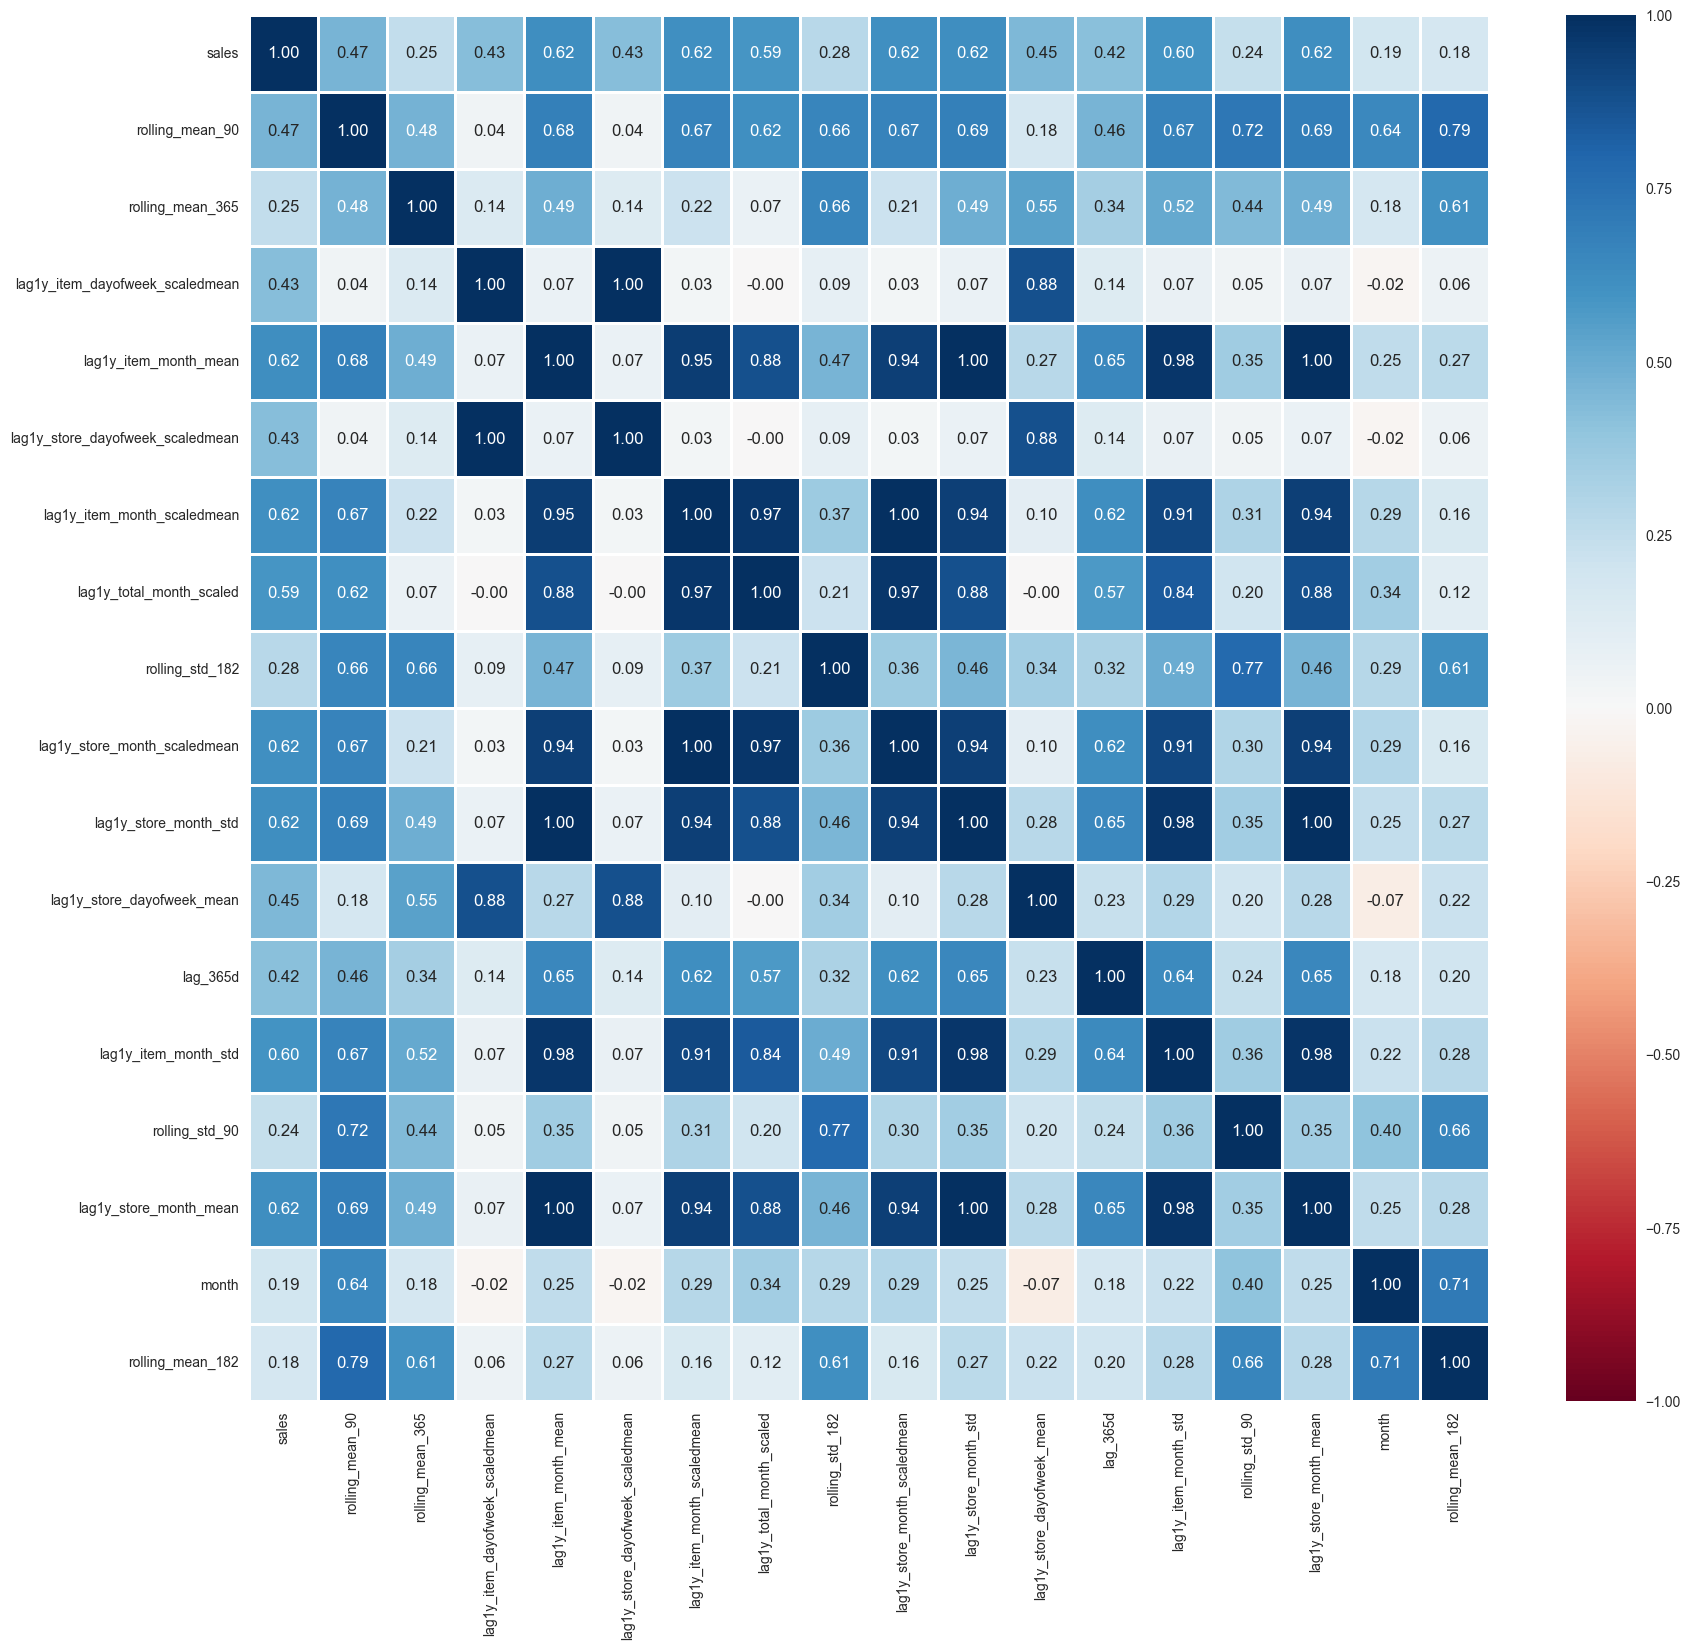

In [198]:
selected_features = important_features_xgb
corr_si_df = df1_train.loc[
    (df1_train.store==1) & (df1_train.item==1),
    ['sales']+selected_features
]
corr_si = corr_si_df.corr()

f = plt.figure(figsize=(20, 18))
sb.heatmap(corr_si, vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 12}, cmap = "RdBu");

### Retraining with Decision Tree

In [199]:
X_train_new_f = X_train[selected_features]
X_valid_new_f = X_valid[selected_features]

In [200]:
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=12)
dt_regressor.fit(X_train_new_f, y_train)
train_res['dtree_selected_features'] = dt_regressor.predict(X_train_new_f)
valid_res['dtree_selected_features'] = dt_regressor.predict(X_valid_new_f)

In [201]:
add_si_scores(train_res, valid_res, si_scores_df, 'dtree_selected_features')

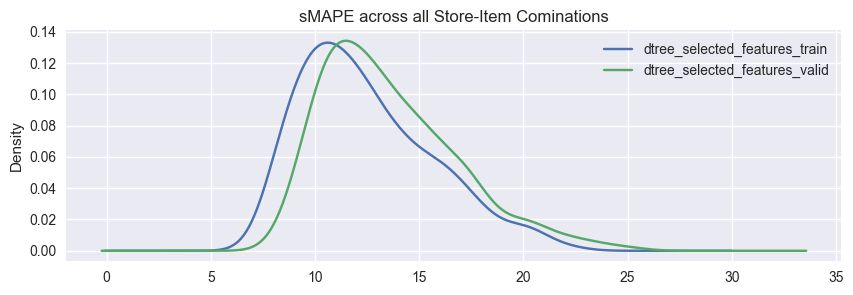

In [202]:
utils.plot_smape(si_scores_df, 'dtree_selected_features')

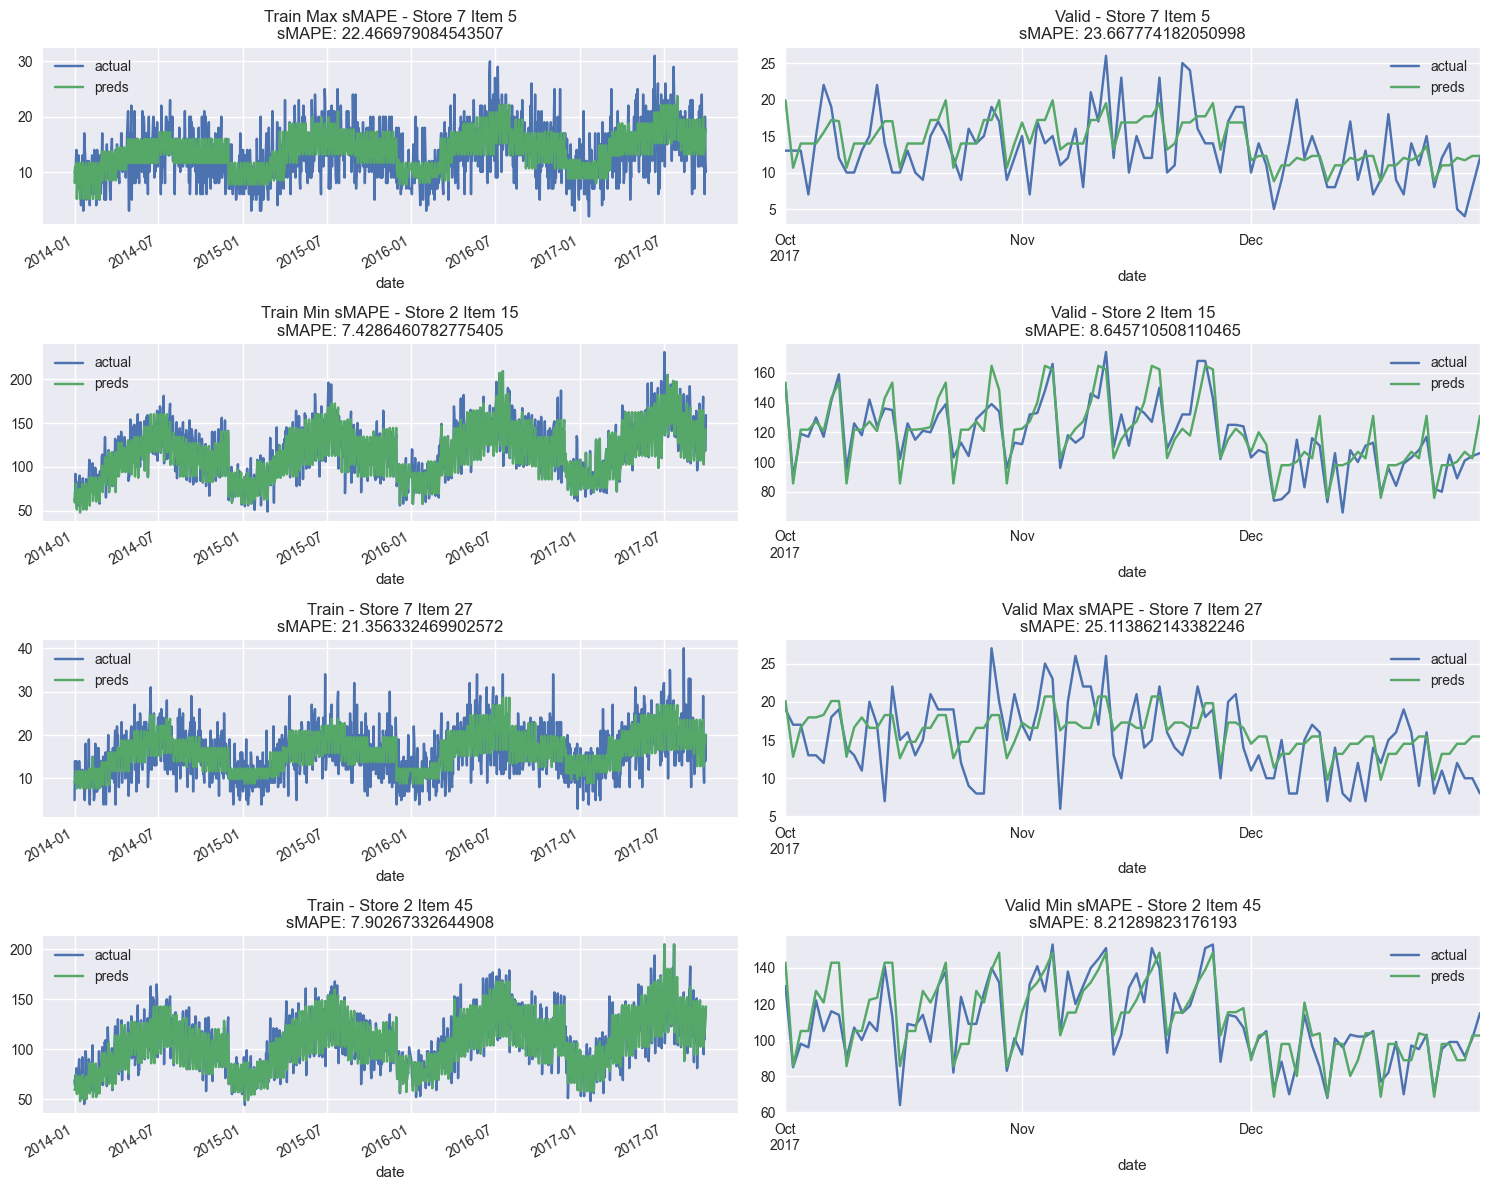

In [203]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'dtree_selected_features')

In [204]:
add_scores(train_res, valid_res, scores_df, 'dtree_selected_features')
scores_df

train      valid
dtree                    12.437039  13.493780
dtree_indiv              13.871189  14.834892
rf                       13.558214  14.490352
rf_indiv                 10.470880  12.712571
xgb                      12.190373  12.385719
xgb_indiv                11.348260  12.764159
dtree_selected_features  12.485182  13.600973

### Random Forest

In [205]:
rf_regressor = RandomForestRegressor(random_state=42,
                                     n_jobs=-1,
                                     max_depth=6,
                                     n_estimators=8000,
                                     max_features=0.33,
                                     verbose=0
                                    )
rf_regressor.fit(X_train_new_f, y_train)
train_res['rf_selected_features'] = rf_regressor.predict(X_train_new_f)
valid_res['rf_selected_features'] = rf_regressor.predict(X_valid_new_f)

In [206]:
add_si_scores(train_res, valid_res, si_scores_df, 'rf_selected_features')

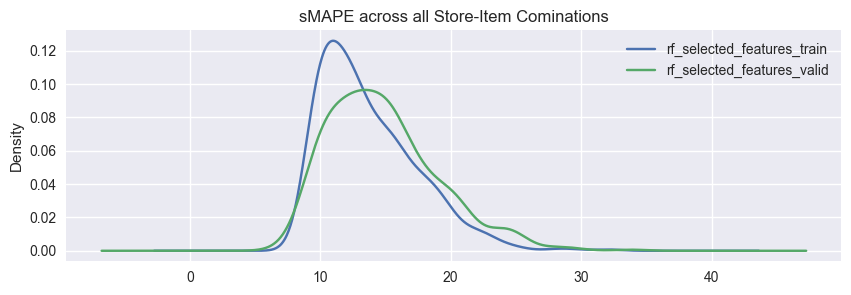

In [207]:
utils.plot_smape(si_scores_df, 'rf_selected_features')

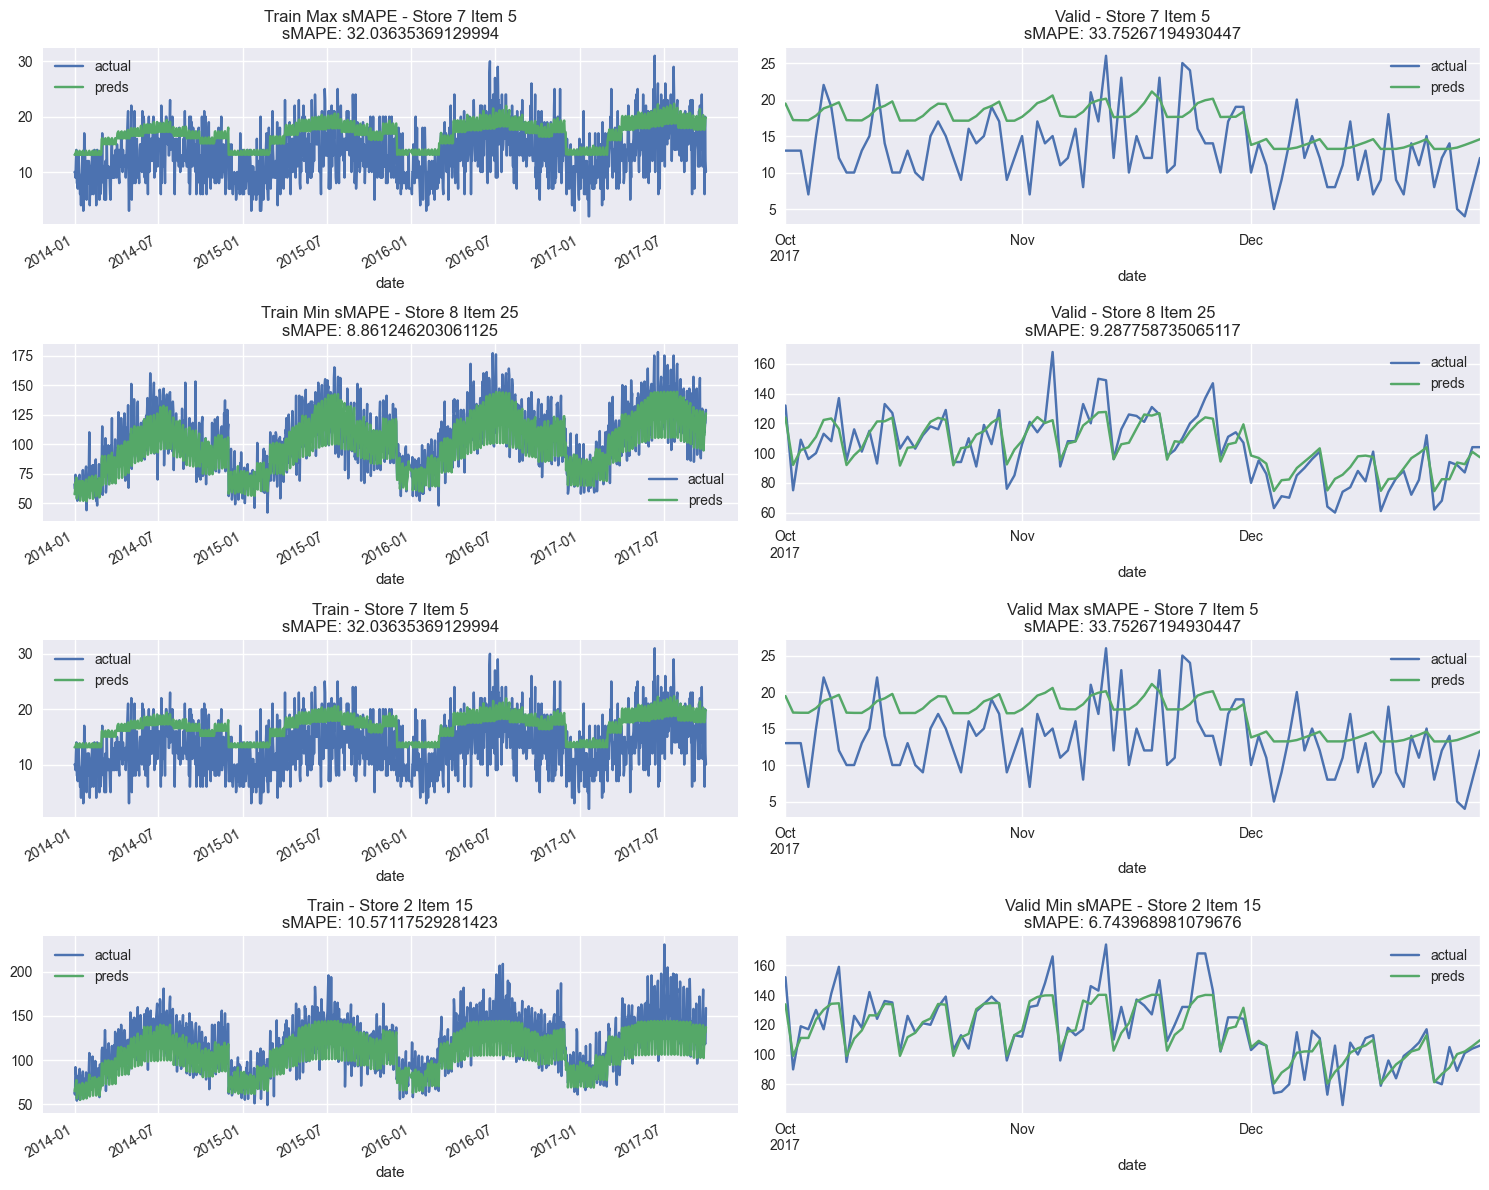

In [208]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'rf_selected_features')

In [209]:
add_scores(train_res, valid_res, scores_df, 'rf_selected_features')
scores_df

train      valid
dtree                    12.437039  13.493780
dtree_indiv              13.871189  14.834892
rf                       13.558214  14.490352
rf_indiv                 10.470880  12.712571
xgb                      12.190373  12.385719
xgb_indiv                11.348260  12.764159
dtree_selected_features  12.485182  13.600973
rf_selected_features     13.732469  14.813128

### XGBoost

In [210]:
booster_params = {
        'booster' : 'gbtree', 
        'n_estimators' : 8000,
        'early_stopping_rounds' : 500,
        'objective' : 'reg:linear',
        'max_depth' : 3,
        'learning_rate' : 0.01
}

xgbreg2 = xgb.XGBRegressor(**booster_params)
xgbreg2.fit(X_train_new_f,
            y_train,
            eval_set=[(X_train_new_f, y_train), (X_valid_new_f, y_valid)],
            verbose=100)
train_res['xgb_selected_features'] = xgbreg2.predict(X_train_new_f)
valid_res['xgb_selected_features'] = xgbreg2.predict(X_valid_new_f)

[0]	validation_0-rmse:29.40126	validation_1-rmse:28.23684
[100]	validation_0-rmse:14.95589	validation_1-rmse:13.96618
[200]	validation_0-rmse:10.17595	validation_1-rmse:9.97667
[300]	validation_0-rmse:8.72288	validation_1-rmse:8.96669
[400]	validation_0-rmse:8.23143	validation_1-rmse:8.56776
[500]	validation_0-rmse:8.04346	validation_1-rmse:8.37131
[600]	validation_0-rmse:7.95672	validation_1-rmse:8.27775
[700]	validation_0-rmse:7.89626	validation_1-rmse:8.22225
[800]	validation_0-rmse:7.84794	validation_1-rmse:8.20086
[900]	validation_0-rmse:7.80930	validation_1-rmse:8.20372
[1000]	validation_0-rmse:7.77831	validation_1-rmse:8.20250
[1100]	validation_0-rmse:7.75258	validation_1-rmse:8.20514
[1200]	validation_0-rmse:7.72953	validation_1-rmse:8.20073
[1300]	validation_0-rmse:7.70839	validation_1-rmse:8.20538
[1334]	validation_0-rmse:7.70180	validation_1-rmse:8.20567


In [211]:
add_si_scores(train_res, valid_res, si_scores_df, 'xgb_selected_features')

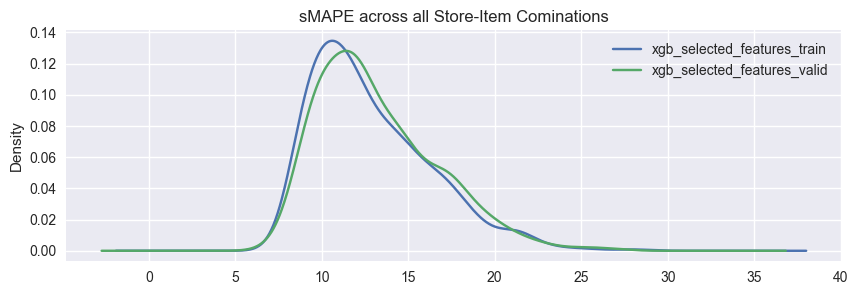

In [212]:
utils.plot_smape(si_scores_df, 'xgb_selected_features')

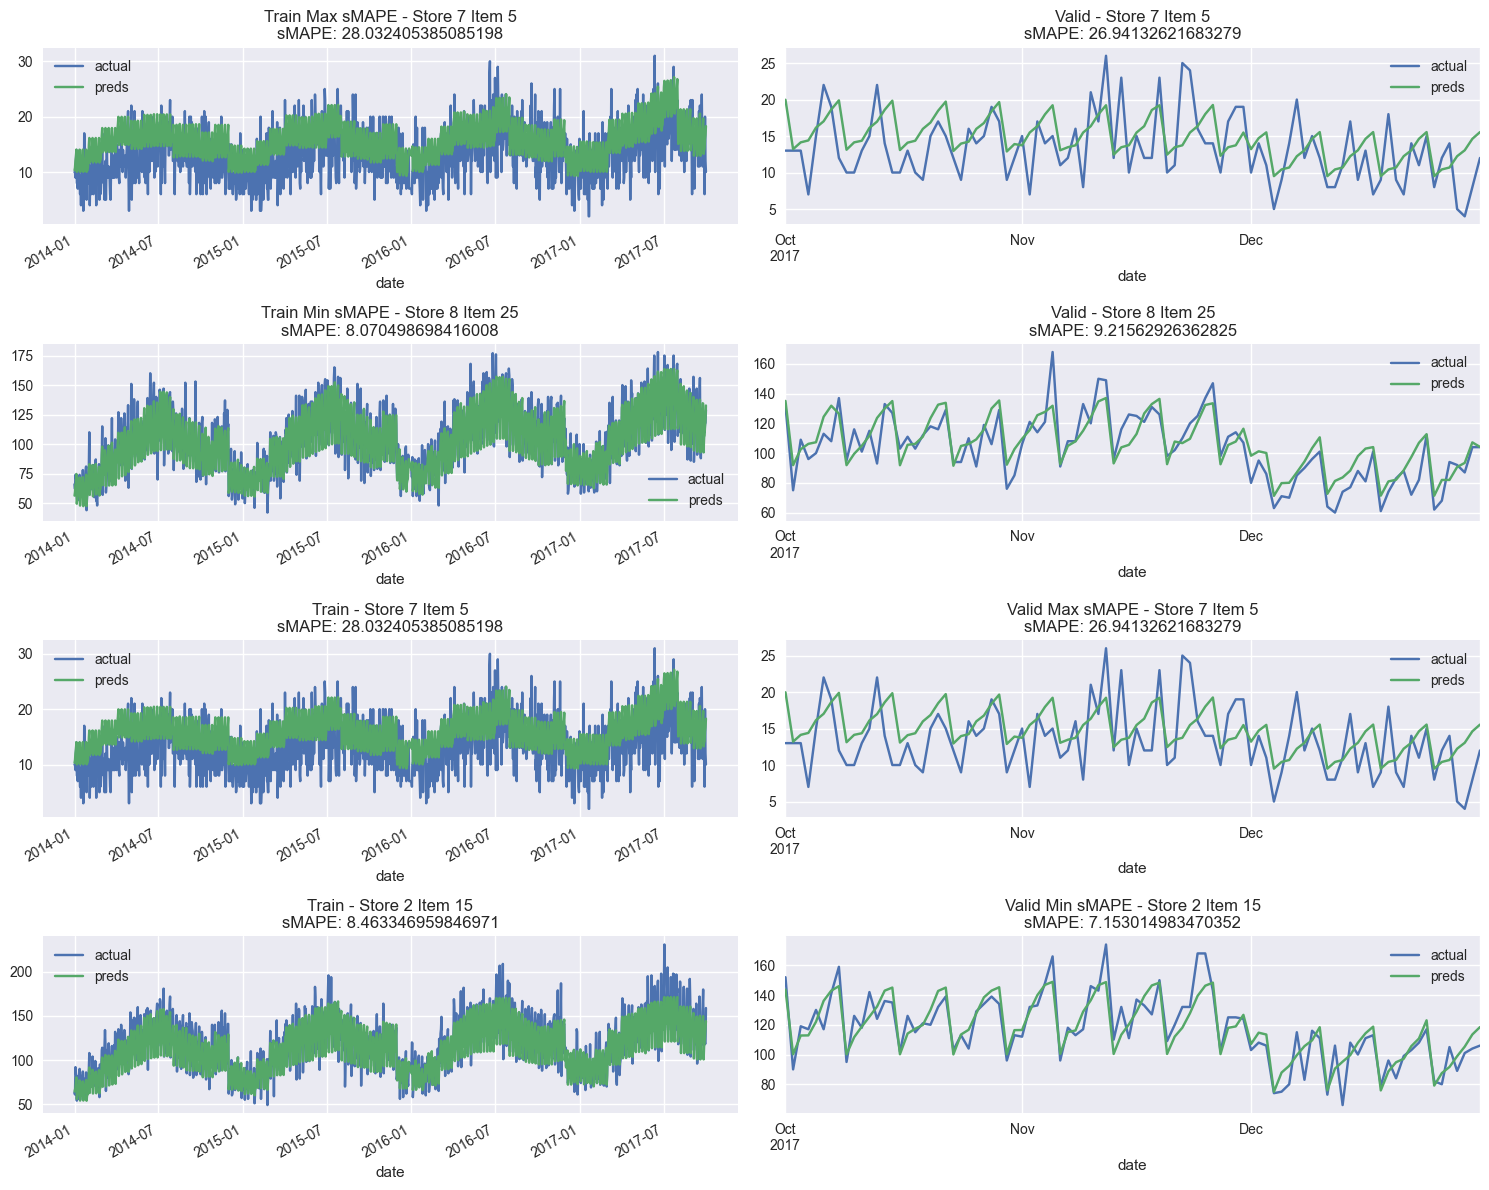

In [213]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'xgb_selected_features')

In [214]:
add_scores(train_res, valid_res, scores_df, 'xgb_selected_features')

In [215]:
scores_df

train      valid
dtree                    12.437039  13.493780
dtree_indiv              13.871189  14.834892
rf                       13.558214  14.490352
rf_indiv                 10.470880  12.712571
xgb                      12.190373  12.385719
xgb_indiv                11.348260  12.764159
dtree_selected_features  12.485182  13.600973
rf_selected_features     13.732469  14.813128
xgb_selected_features    12.869439  13.205482

# Hyperparameter Tuning

https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

In [260]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def objective(trial, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=2, test_size=90)
    param = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'booster' : 'gbtree', 
        'early_stopping_rounds' : trial.suggest_categorical('early_stopping_rounds', [50, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 6, 8]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000, 5000]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0.1, 1, 3]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1, 1.5]),
    }

    model = xgb.XGBRegressor(**param)
    
    rmse_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X_train.index.unique())):
        X_train_fold, X_test_fold = X_train.loc[X_train.index.unique()[train_idx]], X_train.loc[X_train.index.unique()[test_idx]]
        y_train_fold, y_test_fold = y_train.loc[X_train.index.unique()[train_idx]], y_train.loc[X_train.index.unique()[test_idx]]
    
        model.fit(X_train_fold, y_train_fold,
                 eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                  verbose=500)
        
        preds = model.predict(X_test_fold)
        rmse = np.sqrt(mean_squared_error(y_test_fold, preds))
        rmse_list.append(rmse)
        
        trial.report(rmse, step=fold_idx)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    average_rmse = np.mean(rmse_list)
    print(f"Trial {trial.number} Average RMSE across TS folds: {average_rmse}")
    print()
    
    return average_rmse
    

def tune_xgb_hyperparameters(X, y, n_trials=100):
    X = X.sort_index()
    y = y.sort_index()
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    trial = study.best_trial
    
    print(f"Best trial: RMSE {trial.value}")
    print("Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
    
    best_params = trial.params
    best_model == xgb.XGBRegressor(**best_params)
    
    return best_model, best_params

In [261]:
train_hp = all_train_data.dropna()
X = train_hp[features]
y = train_hp.sales

In [262]:
best_xgb_model, best_xgb_params = tune_xgb_hyperparameters(X, y)

[I 2023-11-22 15:01:56,184] A new study created in memory with name: no-name-c583f103-cc0a-41c1-a2a7-2805235b3ebf


[0]	validation_0-rmse:28.82055	validation_1-rmse:36.39920
[500]	validation_0-rmse:7.22354	validation_1-rmse:8.41309
[999]	validation_0-rmse:7.08621	validation_1-rmse:8.37550
[0]	validation_0-rmse:29.36588	validation_1-rmse:28.18151
[500]	validation_0-rmse:7.29268	validation_1-rmse:7.78324
[931]	validation_0-rmse:7.17119	validation_1-rmse:7.74222


[I 2023-11-22 15:04:48,282] Trial 0 finished with value: 8.057531948586258 and parameters: {'early_stopping_rounds': 50, 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1}. Best is trial 0 with value: 8.057531948586258.


Trial 0 Average RMSE across TS folds: 8.057531948586258

[0]	validation_0-rmse:28.82055	validation_1-rmse:36.39920
[500]	validation_0-rmse:7.22354	validation_1-rmse:8.41306
[999]	validation_0-rmse:7.08654	validation_1-rmse:8.37145
[0]	validation_0-rmse:29.36588	validation_1-rmse:28.18151
[500]	validation_0-rmse:7.29268	validation_1-rmse:7.78325
[999]	validation_0-rmse:7.15804	validation_1-rmse:7.74466


[I 2023-11-22 15:07:45,917] Trial 1 finished with value: 8.055753762860185 and parameters: {'early_stopping_rounds': 500, 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1}. Best is trial 1 with value: 8.055753762860185.


Trial 1 Average RMSE across TS folds: 8.055753762860185

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[999]	validation_0-rmse:7.28504	validation_1-rmse:8.37727
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:09:47,367] Trial 2 finished with value: 8.040187781523185 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.8, 'gamma': 3, 'reg_lambda': 1.5}. Best is trial 2 with value: 8.040187781523185.


Trial 2 Average RMSE across TS folds: 8.040187781523185

[0]	validation_0-rmse:27.76428	validation_1-rmse:35.01459
[246]	validation_0-rmse:7.05701	validation_1-rmse:8.37792
[0]	validation_0-rmse:28.28744	validation_1-rmse:27.11630
[191]	validation_0-rmse:7.17476	validation_1-rmse:7.84019


[I 2023-11-22 15:10:27,961] Trial 3 finished with value: 8.097828122966227 and parameters: {'early_stopping_rounds': 50, 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.05, 'n_estimators': 1000, 'subsample': 1.0, 'gamma': 3, 'reg_lambda': 1}. Best is trial 2 with value: 8.040187781523185.


Trial 3 Average RMSE across TS folds: 8.097828122966227

[0]	validation_0-rmse:28.82038	validation_1-rmse:36.39828
[500]	validation_0-rmse:7.22513	validation_1-rmse:8.42127
[1000]	validation_0-rmse:7.09013	validation_1-rmse:8.36879
[1500]	validation_0-rmse:7.01404	validation_1-rmse:8.36507
[1910]	validation_0-rmse:6.96562	validation_1-rmse:8.36672
[0]	validation_0-rmse:29.36581	validation_1-rmse:28.18107
[500]	validation_0-rmse:7.29656	validation_1-rmse:7.84807
[1000]	validation_0-rmse:7.16325	validation_1-rmse:7.84348
[1198]	validation_0-rmse:7.13039	validation_1-rmse:7.83713


[I 2023-11-22 15:14:37,874] Trial 4 finished with value: 8.086789324069102 and parameters: {'early_stopping_rounds': 500, 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.01, 'n_estimators': 5000, 'subsample': 1.0, 'gamma': 3, 'reg_lambda': 1.5}. Best is trial 2 with value: 8.040187781523185.


Trial 4 Average RMSE across TS folds: 8.086789324069102

[0]	validation_0-rmse:26.44982	validation_1-rmse:33.29030
[500]	validation_0-rmse:6.68169	validation_1-rmse:8.48217
[578]	validation_0-rmse:6.61786	validation_1-rmse:8.49662


[I 2023-11-22 15:15:21,106] Trial 5 pruned. 


[0]	validation_0-rmse:27.93146	validation_1-rmse:35.35964
[500]	validation_0-rmse:7.41323	validation_1-rmse:8.56199
[1000]	validation_0-rmse:7.32665	validation_1-rmse:8.45348
[1500]	validation_0-rmse:7.29147	validation_1-rmse:8.40543
[1935]	validation_0-rmse:7.27090	validation_1-rmse:8.39356


[I 2023-11-22 15:17:29,538] Trial 6 pruned. 


[0]	validation_0-rmse:28.82705	validation_1-rmse:36.41216
[500]	validation_0-rmse:7.38534	validation_1-rmse:8.52223
[999]	validation_0-rmse:7.26639	validation_1-rmse:8.40614


[I 2023-11-22 15:18:46,546] Trial 7 pruned. 


[0]	validation_0-rmse:28.82705	validation_1-rmse:36.41216
[500]	validation_0-rmse:7.38533	validation_1-rmse:8.52220
[1000]	validation_0-rmse:7.26612	validation_1-rmse:8.40419
[1500]	validation_0-rmse:7.21546	validation_1-rmse:8.36135
[2000]	validation_0-rmse:7.18105	validation_1-rmse:8.34413
[2500]	validation_0-rmse:7.15265	validation_1-rmse:8.33928
[3000]	validation_0-rmse:7.12752	validation_1-rmse:8.33605
[3500]	validation_0-rmse:7.10383	validation_1-rmse:8.33529
[4000]	validation_0-rmse:7.08139	validation_1-rmse:8.33408
[4500]	validation_0-rmse:7.06018	validation_1-rmse:8.33531
[4726]	validation_0-rmse:7.05078	validation_1-rmse:8.33531
[0]	validation_0-rmse:29.37214	validation_1-rmse:28.19148
[500]	validation_0-rmse:7.45322	validation_1-rmse:7.88594
[1000]	validation_0-rmse:7.33453	validation_1-rmse:7.81713
[1500]	validation_0-rmse:7.28397	validation_1-rmse:7.80645
[2000]	validation_0-rmse:7.24974	validation_1-rmse:7.80146
[2500]	validation_0-rmse:7.22085	validation_1-rmse:7.79640
[

[I 2023-11-22 15:28:18,218] Trial 8 pruned. 


[0]	validation_0-rmse:28.82063	validation_1-rmse:36.39936
[500]	validation_0-rmse:7.22418	validation_1-rmse:8.41537
[1000]	validation_0-rmse:7.08871	validation_1-rmse:8.37841
[1500]	validation_0-rmse:7.01109	validation_1-rmse:8.36998
[2000]	validation_0-rmse:6.94779	validation_1-rmse:8.36889
[2323]	validation_0-rmse:6.90980	validation_1-rmse:8.37123
[0]	validation_0-rmse:29.36596	validation_1-rmse:28.18166
[500]	validation_0-rmse:7.29378	validation_1-rmse:7.78112
[1000]	validation_0-rmse:7.16085	validation_1-rmse:7.73877
[1500]	validation_0-rmse:7.08394	validation_1-rmse:7.74211
[1630]	validation_0-rmse:7.06719	validation_1-rmse:7.74279


[I 2023-11-22 15:33:27,784] Trial 9 finished with value: 8.05130237211303 and parameters: {'early_stopping_rounds': 500, 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.01, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 2 with value: 8.040187781523185.


Trial 9 Average RMSE across TS folds: 8.05130237211303

[0]	validation_0-rmse:26.79082	validation_1-rmse:33.98478
[500]	validation_0-rmse:7.35211	validation_1-rmse:8.49122
[999]	validation_0-rmse:7.28675	validation_1-rmse:8.42732


[I 2023-11-22 15:34:35,810] Trial 10 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 15:36:59,867] Trial 11 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 11 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:39:29,166] Trial 12 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 12 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:41:57,308] Trial 13 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 13 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 15:44:19,104] Trial 14 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 14 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 15:46:39,042] Trial 15 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 15 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:49:05,170] Trial 16 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 16 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:51:27,263] Trial 17 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 11 with value: 8.032071995851602.


Trial 17 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:27.79774	validation_1-rmse:35.08937
[500]	validation_0-rmse:7.16859	validation_1-rmse:8.38078
[647]	validation_0-rmse:7.13338	validation_1-rmse:8.37711


[I 2023-11-22 15:52:17,440] Trial 18 pruned. 


[0]	validation_0-rmse:26.79123	validation_1-rmse:33.98859
[500]	validation_0-rmse:7.35006	validation_1-rmse:8.44600
[1000]	validation_0-rmse:7.28526	validation_1-rmse:8.38276
[1199]	validation_0-rmse:7.27014	validation_1-rmse:8.37402


[I 2023-11-22 15:53:40,064] Trial 19 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:55:49,910] Trial 20 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 20 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 15:58:15,049] Trial 21 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 21 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:00:35,076] Trial 22 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 22 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:03:02,697] Trial 23 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 23 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:05:38,722] Trial 24 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 24 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:27.79866	validation_1-rmse:35.08537
[488]	validation_0-rmse:7.16944	validation_1-rmse:8.40933


[I 2023-11-22 16:06:22,070] Trial 25 pruned. 


[0]	validation_0-rmse:26.79082	validation_1-rmse:33.98478
[500]	validation_0-rmse:7.35211	validation_1-rmse:8.49122
[1000]	validation_0-rmse:7.28703	validation_1-rmse:8.42639
[1500]	validation_0-rmse:7.25156	validation_1-rmse:8.39525
[2000]	validation_0-rmse:7.22578	validation_1-rmse:8.37421
[2038]	validation_0-rmse:7.22396	validation_1-rmse:8.37445


[I 2023-11-22 16:08:46,956] Trial 26 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:11:08,209] Trial 27 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 27 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79123	validation_1-rmse:33.98859
[500]	validation_0-rmse:7.35006	validation_1-rmse:8.44600
[1000]	validation_0-rmse:7.28526	validation_1-rmse:8.38276
[1199]	validation_0-rmse:7.27014	validation_1-rmse:8.37402


[I 2023-11-22 16:12:29,375] Trial 28 pruned. 


[0]	validation_0-rmse:27.79857	validation_1-rmse:35.08523
[500]	validation_0-rmse:7.16458	validation_1-rmse:8.38867
[544]	validation_0-rmse:7.15336	validation_1-rmse:8.38988


[I 2023-11-22 16:13:11,649] Trial 29 pruned. 


[0]	validation_0-rmse:26.79124	validation_1-rmse:33.98861
[500]	validation_0-rmse:7.35039	validation_1-rmse:8.44432
[1000]	validation_0-rmse:7.28512	validation_1-rmse:8.38739
[1184]	validation_0-rmse:7.27101	validation_1-rmse:8.37865


[I 2023-11-22 16:14:27,040] Trial 30 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:16:50,319] Trial 31 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 31 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:19:11,445] Trial 32 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 32 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:21:31,616] Trial 33 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 33 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[999]	validation_0-rmse:7.28504	validation_1-rmse:8.37727


[I 2023-11-22 16:22:33,093] Trial 34 pruned. 


[0]	validation_0-rmse:26.45267	validation_1-rmse:33.30235
[500]	validation_0-rmse:6.66022	validation_1-rmse:8.50175
[584]	validation_0-rmse:6.58390	validation_1-rmse:8.50799


[I 2023-11-22 16:23:22,705] Trial 35 pruned. 


[0]	validation_0-rmse:28.85323	validation_1-rmse:36.46629
[500]	validation_0-rmse:7.90176	validation_1-rmse:9.39829
[999]	validation_0-rmse:7.60675	validation_1-rmse:8.86356


[I 2023-11-22 16:24:31,172] Trial 36 pruned. 


[0]	validation_0-rmse:26.45346	validation_1-rmse:33.30390
[205]	validation_0-rmse:6.97227	validation_1-rmse:8.39520


[I 2023-11-22 16:24:50,277] Trial 37 pruned. 


[0]	validation_0-rmse:27.93125	validation_1-rmse:35.35771
[500]	validation_0-rmse:7.42402	validation_1-rmse:8.58515
[999]	validation_0-rmse:7.33220	validation_1-rmse:8.47117


[I 2023-11-22 16:25:57,010] Trial 38 pruned. 


[0]	validation_0-rmse:28.85327	validation_1-rmse:36.46668
[500]	validation_0-rmse:7.88108	validation_1-rmse:9.37002
[1000]	validation_0-rmse:7.59026	validation_1-rmse:8.82636
[1500]	validation_0-rmse:7.49048	validation_1-rmse:8.66268
[2000]	validation_0-rmse:7.43521	validation_1-rmse:8.57610
[2500]	validation_0-rmse:7.39888	validation_1-rmse:8.52573
[3000]	validation_0-rmse:7.37296	validation_1-rmse:8.48787
[3500]	validation_0-rmse:7.35338	validation_1-rmse:8.46081
[4000]	validation_0-rmse:7.33744	validation_1-rmse:8.43945
[4500]	validation_0-rmse:7.32498	validation_1-rmse:8.42865
[4999]	validation_0-rmse:7.31475	validation_1-rmse:8.41455


[I 2023-11-22 16:31:31,823] Trial 39 pruned. 


[0]	validation_0-rmse:26.45193	validation_1-rmse:33.30051
[500]	validation_0-rmse:6.66753	validation_1-rmse:8.50832
[605]	validation_0-rmse:6.57058	validation_1-rmse:8.52090


[I 2023-11-22 16:32:23,779] Trial 40 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:34:48,172] Trial 41 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 41 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:37:04,058] Trial 42 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 42 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:39:39,482] Trial 43 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 43 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:42:08,319] Trial 44 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 3, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 44 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.52066	validation_1-rmse:33.43493
[339]	validation_0-rmse:7.14085	validation_1-rmse:8.36744


[I 2023-11-22 16:42:37,800] Trial 45 pruned. 


[0]	validation_0-rmse:28.85328	validation_1-rmse:36.46668
[500]	validation_0-rmse:7.88138	validation_1-rmse:9.37354
[1000]	validation_0-rmse:7.58985	validation_1-rmse:8.83162
[1500]	validation_0-rmse:7.49018	validation_1-rmse:8.66488
[2000]	validation_0-rmse:7.43512	validation_1-rmse:8.58364
[2500]	validation_0-rmse:7.39876	validation_1-rmse:8.53209
[3000]	validation_0-rmse:7.37268	validation_1-rmse:8.49810
[3500]	validation_0-rmse:7.35316	validation_1-rmse:8.47038
[4000]	validation_0-rmse:7.33735	validation_1-rmse:8.44908
[4500]	validation_0-rmse:7.32494	validation_1-rmse:8.43818
[4999]	validation_0-rmse:7.31464	validation_1-rmse:8.42456


[I 2023-11-22 16:48:43,072] Trial 46 pruned. 


[0]	validation_0-rmse:26.79079	validation_1-rmse:33.98474
[500]	validation_0-rmse:7.35334	validation_1-rmse:8.50882
[1000]	validation_0-rmse:7.28779	validation_1-rmse:8.42595
[1500]	validation_0-rmse:7.25244	validation_1-rmse:8.39057
[1838]	validation_0-rmse:7.23398	validation_1-rmse:8.38634


[I 2023-11-22 16:50:52,839] Trial 47 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1354]	validation_0-rmse:7.25989	validation_1-rmse:8.36179
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 16:53:21,962] Trial 48 finished with value: 8.032071995851602 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 3, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 48 Average RMSE across TS folds: 8.032071995851602

[0]	validation_0-rmse:26.45346	validation_1-rmse:33.30390
[205]	validation_0-rmse:6.97227	validation_1-rmse:8.39520


[I 2023-11-22 16:53:44,337] Trial 49 pruned. 


[0]	validation_0-rmse:27.93147	validation_1-rmse:35.35965
[500]	validation_0-rmse:7.41762	validation_1-rmse:8.57152
[1000]	validation_0-rmse:7.32893	validation_1-rmse:8.45396
[1500]	validation_0-rmse:7.29250	validation_1-rmse:8.40203
[1626]	validation_0-rmse:7.28616	validation_1-rmse:8.39626


[I 2023-11-22 16:55:44,854] Trial 50 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 16:58:19,301] Trial 51 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 51 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:00:51,387] Trial 52 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 52 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:03:21,736] Trial 53 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 53 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:06:03,754] Trial 54 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 54 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:08:37,914] Trial 55 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 55 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.52066	validation_1-rmse:33.43493
[339]	validation_0-rmse:7.14085	validation_1-rmse:8.36744


[I 2023-11-22 17:09:05,253] Trial 56 pruned. 


[0]	validation_0-rmse:28.85323	validation_1-rmse:36.46629
[500]	validation_0-rmse:7.90238	validation_1-rmse:9.40361
[1000]	validation_0-rmse:7.60698	validation_1-rmse:8.85731
[1500]	validation_0-rmse:7.50610	validation_1-rmse:8.69125
[2000]	validation_0-rmse:7.44903	validation_1-rmse:8.61439
[2500]	validation_0-rmse:7.40995	validation_1-rmse:8.56185
[3000]	validation_0-rmse:7.38146	validation_1-rmse:8.52456
[3500]	validation_0-rmse:7.36069	validation_1-rmse:8.50079
[4000]	validation_0-rmse:7.34427	validation_1-rmse:8.48290
[4500]	validation_0-rmse:7.33182	validation_1-rmse:8.47259
[4999]	validation_0-rmse:7.32142	validation_1-rmse:8.46338


[I 2023-11-22 17:14:36,890] Trial 57 pruned. 


[0]	validation_0-rmse:26.79123	validation_1-rmse:33.98859
[500]	validation_0-rmse:7.35006	validation_1-rmse:8.44600
[1000]	validation_0-rmse:7.28526	validation_1-rmse:8.38276
[1199]	validation_0-rmse:7.27014	validation_1-rmse:8.37402


[I 2023-11-22 17:15:57,263] Trial 58 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:18:27,353] Trial 59 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 59 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:27.93147	validation_1-rmse:35.35965
[500]	validation_0-rmse:7.41762	validation_1-rmse:8.57152
[1000]	validation_0-rmse:7.32893	validation_1-rmse:8.45396
[1500]	validation_0-rmse:7.29250	validation_1-rmse:8.40203
[1626]	validation_0-rmse:7.28616	validation_1-rmse:8.39626


[I 2023-11-22 17:20:16,230] Trial 60 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:22:40,552] Trial 61 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 61 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:25:05,273] Trial 62 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 62 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:27:32,270] Trial 63 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 63 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:30:00,582] Trial 64 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 64 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:32:23,726] Trial 65 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 65 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.52066	validation_1-rmse:33.43493
[338]	validation_0-rmse:7.14115	validation_1-rmse:8.36715


[I 2023-11-22 17:32:49,696] Trial 66 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[999]	validation_0-rmse:7.28504	validation_1-rmse:8.37727


[I 2023-11-22 17:33:55,003] Trial 67 pruned. 


[0]	validation_0-rmse:26.45041	validation_1-rmse:33.29202
[176]	validation_0-rmse:6.99579	validation_1-rmse:8.39793


[I 2023-11-22 17:34:11,493] Trial 68 pruned. 


[0]	validation_0-rmse:28.85328	validation_1-rmse:36.46668
[500]	validation_0-rmse:7.88138	validation_1-rmse:9.37354
[1000]	validation_0-rmse:7.58985	validation_1-rmse:8.83162
[1500]	validation_0-rmse:7.49018	validation_1-rmse:8.66488
[2000]	validation_0-rmse:7.43512	validation_1-rmse:8.58364
[2500]	validation_0-rmse:7.39876	validation_1-rmse:8.53209
[3000]	validation_0-rmse:7.37268	validation_1-rmse:8.49810
[3500]	validation_0-rmse:7.35316	validation_1-rmse:8.47038
[4000]	validation_0-rmse:7.33735	validation_1-rmse:8.44908
[4500]	validation_0-rmse:7.32494	validation_1-rmse:8.43818
[4999]	validation_0-rmse:7.31464	validation_1-rmse:8.42456


[I 2023-11-22 17:39:32,409] Trial 69 pruned. 


[0]	validation_0-rmse:26.79123	validation_1-rmse:33.98859
[500]	validation_0-rmse:7.35006	validation_1-rmse:8.44600
[1000]	validation_0-rmse:7.28474	validation_1-rmse:8.37872
[1193]	validation_0-rmse:7.26970	validation_1-rmse:8.37437


[I 2023-11-22 17:40:54,565] Trial 70 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:43:15,237] Trial 71 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 71 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:45:38,887] Trial 72 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 72 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:47:59,499] Trial 73 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 73 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 17:50:21,254] Trial 74 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 74 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1353]	validation_0-rmse:7.25993	validation_1-rmse:8.36152


[I 2023-11-22 17:51:48,581] Trial 75 pruned. 


[0]	validation_0-rmse:27.93147	validation_1-rmse:35.35965
[500]	validation_0-rmse:7.41762	validation_1-rmse:8.57152
[1000]	validation_0-rmse:7.32901	validation_1-rmse:8.45334
[1500]	validation_0-rmse:7.29242	validation_1-rmse:8.40603
[1943]	validation_0-rmse:7.27161	validation_1-rmse:8.38618


[I 2023-11-22 17:53:52,362] Trial 76 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[999]	validation_0-rmse:7.28504	validation_1-rmse:8.37727


[I 2023-11-22 17:54:57,692] Trial 77 pruned. 


[0]	validation_0-rmse:26.52066	validation_1-rmse:33.43493
[338]	validation_0-rmse:7.14115	validation_1-rmse:8.36715


[I 2023-11-22 17:55:24,208] Trial 78 pruned. 


[0]	validation_0-rmse:26.45041	validation_1-rmse:33.29202
[500]	validation_0-rmse:6.68326	validation_1-rmse:8.45342
[630]	validation_0-rmse:6.57632	validation_1-rmse:8.46785


[I 2023-11-22 17:56:14,553] Trial 79 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 17:58:34,751] Trial 80 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 80 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:00:54,837] Trial 81 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 81 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 18:03:13,769] Trial 82 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 82 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 18:05:39,414] Trial 83 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 83 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:08:12,061] Trial 84 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 84 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:10:43,686] Trial 85 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 85 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:28.85328	validation_1-rmse:36.46668
[500]	validation_0-rmse:7.88138	validation_1-rmse:9.37354
[1000]	validation_0-rmse:7.58985	validation_1-rmse:8.83162
[1500]	validation_0-rmse:7.49018	validation_1-rmse:8.66488
[2000]	validation_0-rmse:7.43512	validation_1-rmse:8.58364
[2500]	validation_0-rmse:7.39876	validation_1-rmse:8.53209
[3000]	validation_0-rmse:7.37268	validation_1-rmse:8.49809
[3500]	validation_0-rmse:7.35318	validation_1-rmse:8.46994
[4000]	validation_0-rmse:7.33747	validation_1-rmse:8.44903
[4500]	validation_0-rmse:7.32505	validation_1-rmse:8.43857
[4999]	validation_0-rmse:7.31478	validation_1-rmse:8.42582


[I 2023-11-22 18:16:59,694] Trial 86 pruned. 


[0]	validation_0-rmse:26.79123	validation_1-rmse:33.98859
[500]	validation_0-rmse:7.35006	validation_1-rmse:8.44600
[1000]	validation_0-rmse:7.28526	validation_1-rmse:8.38276
[1200]	validation_0-rmse:7.27009	validation_1-rmse:8.37396


[I 2023-11-22 18:18:27,206] Trial 87 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[999]	validation_0-rmse:7.28504	validation_1-rmse:8.37727


[I 2023-11-22 18:19:45,105] Trial 88 pruned. 


[0]	validation_0-rmse:27.93147	validation_1-rmse:35.35965
[500]	validation_0-rmse:7.41762	validation_1-rmse:8.57152
[1000]	validation_0-rmse:7.32901	validation_1-rmse:8.45334
[1500]	validation_0-rmse:7.29242	validation_1-rmse:8.40603
[1943]	validation_0-rmse:7.27161	validation_1-rmse:8.38618


[I 2023-11-22 18:22:03,964] Trial 89 pruned. 


[0]	validation_0-rmse:26.45099	validation_1-rmse:33.29311
[159]	validation_0-rmse:7.02290	validation_1-rmse:8.41239


[I 2023-11-22 18:22:21,743] Trial 90 pruned. 


[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:24:53,863] Trial 91 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 91 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1361]	validation_0-rmse:7.25997	validation_1-rmse:8.36046
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:27:24,403] Trial 92 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 92 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:29:57,584] Trial 93 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 93 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[719]	validation_0-rmse:7.38458	validation_1-rmse:7.70840


[I 2023-11-22 18:32:23,965] Trial 94 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 94 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1360]	validation_0-rmse:7.26006	validation_1-rmse:8.36050
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[718]	validation_0-rmse:7.38467	validation_1-rmse:7.70837


[I 2023-11-22 18:35:00,288] Trial 95 finished with value: 8.031520295702432 and parameters: {'early_stopping_rounds': 50, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 20 with value: 8.031520295702432.


Trial 95 Average RMSE across TS folds: 8.031520295702432

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1500]	validation_0-rmse:7.25118	validation_1-rmse:8.35529
[2000]	validation_0-rmse:7.22503	validation_1-rmse:8.34470
[2500]	validation_0-rmse:7.20268	validation_1-rmse:8.34030
[2763]	validation_0-rmse:7.19197	validation_1-rmse:8.34468
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[1000]	validation_0-rmse:7.35397	validation_1-rmse:7.69093
[1500]	validation_0-rmse:7.31875	validation_1-rmse:7.69467
[1615]	validation_0-rmse:7.31225	validation_1-rmse:7.69332


[I 2023-11-22 18:40:16,918] Trial 96 finished with value: 8.012590776298964 and parameters: {'early_stopping_rounds': 500, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 0.1, 'reg_lambda': 1.5}. Best is trial 96 with value: 8.012590776298964.


Trial 96 Average RMSE across TS folds: 8.012590776298964

[0]	validation_0-rmse:26.79126	validation_1-rmse:33.98864
[500]	validation_0-rmse:7.34900	validation_1-rmse:8.42796
[1000]	validation_0-rmse:7.28494	validation_1-rmse:8.37714
[1500]	validation_0-rmse:7.25067	validation_1-rmse:8.35747
[2000]	validation_0-rmse:7.22460	validation_1-rmse:8.35451
[2500]	validation_0-rmse:7.20199	validation_1-rmse:8.34638
[3000]	validation_0-rmse:7.18180	validation_1-rmse:8.35253
[3070]	validation_0-rmse:7.17910	validation_1-rmse:8.35388
[0]	validation_0-rmse:27.32318	validation_1-rmse:25.99160
[500]	validation_0-rmse:7.42111	validation_1-rmse:7.73450
[1000]	validation_0-rmse:7.35397	validation_1-rmse:7.69093
[1500]	validation_0-rmse:7.31875	validation_1-rmse:7.69468
[1614]	validation_0-rmse:7.31227	validation_1-rmse:7.69347


[I 2023-11-22 18:46:09,505] Trial 97 finished with value: 8.015982450454391 and parameters: {'early_stopping_rounds': 500, 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1.5}. Best is trial 96 with value: 8.012590776298964.


Trial 97 Average RMSE across TS folds: 8.015982450454391

[0]	validation_0-rmse:26.52066	validation_1-rmse:33.43493
[500]	validation_0-rmse:7.07217	validation_1-rmse:8.37254
[766]	validation_0-rmse:6.97429	validation_1-rmse:8.38449


[I 2023-11-22 18:47:14,280] Trial 98 pruned. 


[0]	validation_0-rmse:26.79124	validation_1-rmse:33.98861
[500]	validation_0-rmse:7.35016	validation_1-rmse:8.42891
[1000]	validation_0-rmse:7.28548	validation_1-rmse:8.37652
[1500]	validation_0-rmse:7.25006	validation_1-rmse:8.35464
[2000]	validation_0-rmse:7.22308	validation_1-rmse:8.34980
[2500]	validation_0-rmse:7.20025	validation_1-rmse:8.34431
[3000]	validation_0-rmse:7.18020	validation_1-rmse:8.34490
[3211]	validation_0-rmse:7.17216	validation_1-rmse:8.35336
[0]	validation_0-rmse:27.32316	validation_1-rmse:25.99157
[500]	validation_0-rmse:7.42273	validation_1-rmse:7.73527
[1000]	validation_0-rmse:7.35496	validation_1-rmse:7.68074
[1500]	validation_0-rmse:7.31879	validation_1-rmse:7.68052
[1615]	validation_0-rmse:7.31199	validation_1-rmse:7.67788


[I 2023-11-22 18:53:20,780] Trial 99 finished with value: 8.008393763222863 and parameters: {'early_stopping_rounds': 500, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'gamma': 1, 'reg_lambda': 1}. Best is trial 99 with value: 8.008393763222863.


Trial 99 Average RMSE across TS folds: 8.008393763222863

Best trial: RMSE 8.008393763222863
Best hyperparameters:
  early_stopping_rounds: 500
  max_depth: 3
  min_child_weight: 1
  learning_rate: 0.1
  n_estimators: 5000
  subsample: 0.8
  gamma: 1
  reg_lambda: 1


NameError: name 'best_model' is not defined

In [253]:
booster_params = {
        'max_depth': 6,
        'min_child_weight': 3,
        'gamma': 4,
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'reg_lambda': 1,
        'reg_alpha': 0,
        'learning_rate': 0.01,
        'n_estimators': 5000,
        'early_stopping_rounds' : 500
}

xgbreg3 = xgb.XGBRegressor(**booster_params)
xgbreg3.fit(X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=100)
train_res['xgb_tuned'] = xgbreg3.predict(X_train)
valid_res['xgb_tuned'] = xgbreg3.predict(X_valid)

[0]	validation_0-rmse:29.37125	validation_1-rmse:28.22981
[100]	validation_0-rmse:13.42572	validation_1-rmse:12.82900
[200]	validation_0-rmse:8.75050	validation_1-rmse:8.77738
[300]	validation_0-rmse:7.74585	validation_1-rmse:8.07615
[400]	validation_0-rmse:7.52871	validation_1-rmse:7.95751
[500]	validation_0-rmse:7.45718	validation_1-rmse:7.93054
[600]	validation_0-rmse:7.41790	validation_1-rmse:7.91003
[700]	validation_0-rmse:7.39094	validation_1-rmse:7.89563
[800]	validation_0-rmse:7.36945	validation_1-rmse:7.87845
[900]	validation_0-rmse:7.35296	validation_1-rmse:7.86720
[1000]	validation_0-rmse:7.33876	validation_1-rmse:7.86011
[1100]	validation_0-rmse:7.32616	validation_1-rmse:7.85122
[1200]	validation_0-rmse:7.31532	validation_1-rmse:7.84686
[1300]	validation_0-rmse:7.30543	validation_1-rmse:7.84049
[1400]	validation_0-rmse:7.29640	validation_1-rmse:7.84654
[1500]	validation_0-rmse:7.28853	validation_1-rmse:7.84342
[1600]	validation_0-rmse:7.28149	validation_1-rmse:7.84016
[1700

In [254]:
add_si_scores(train_res, valid_res, si_scores_df, 'xgb_tuned')

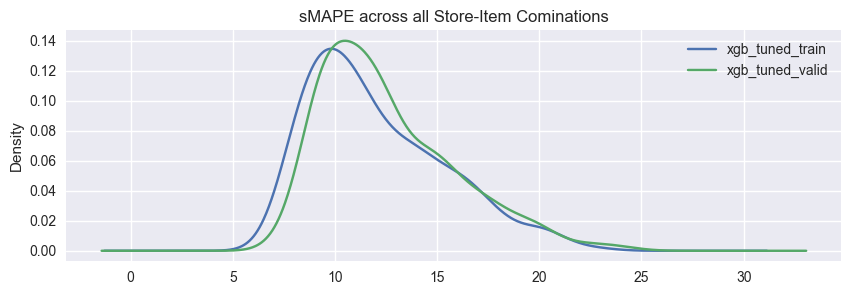

In [255]:
utils.plot_smape(si_scores_df, 'xgb_tuned')

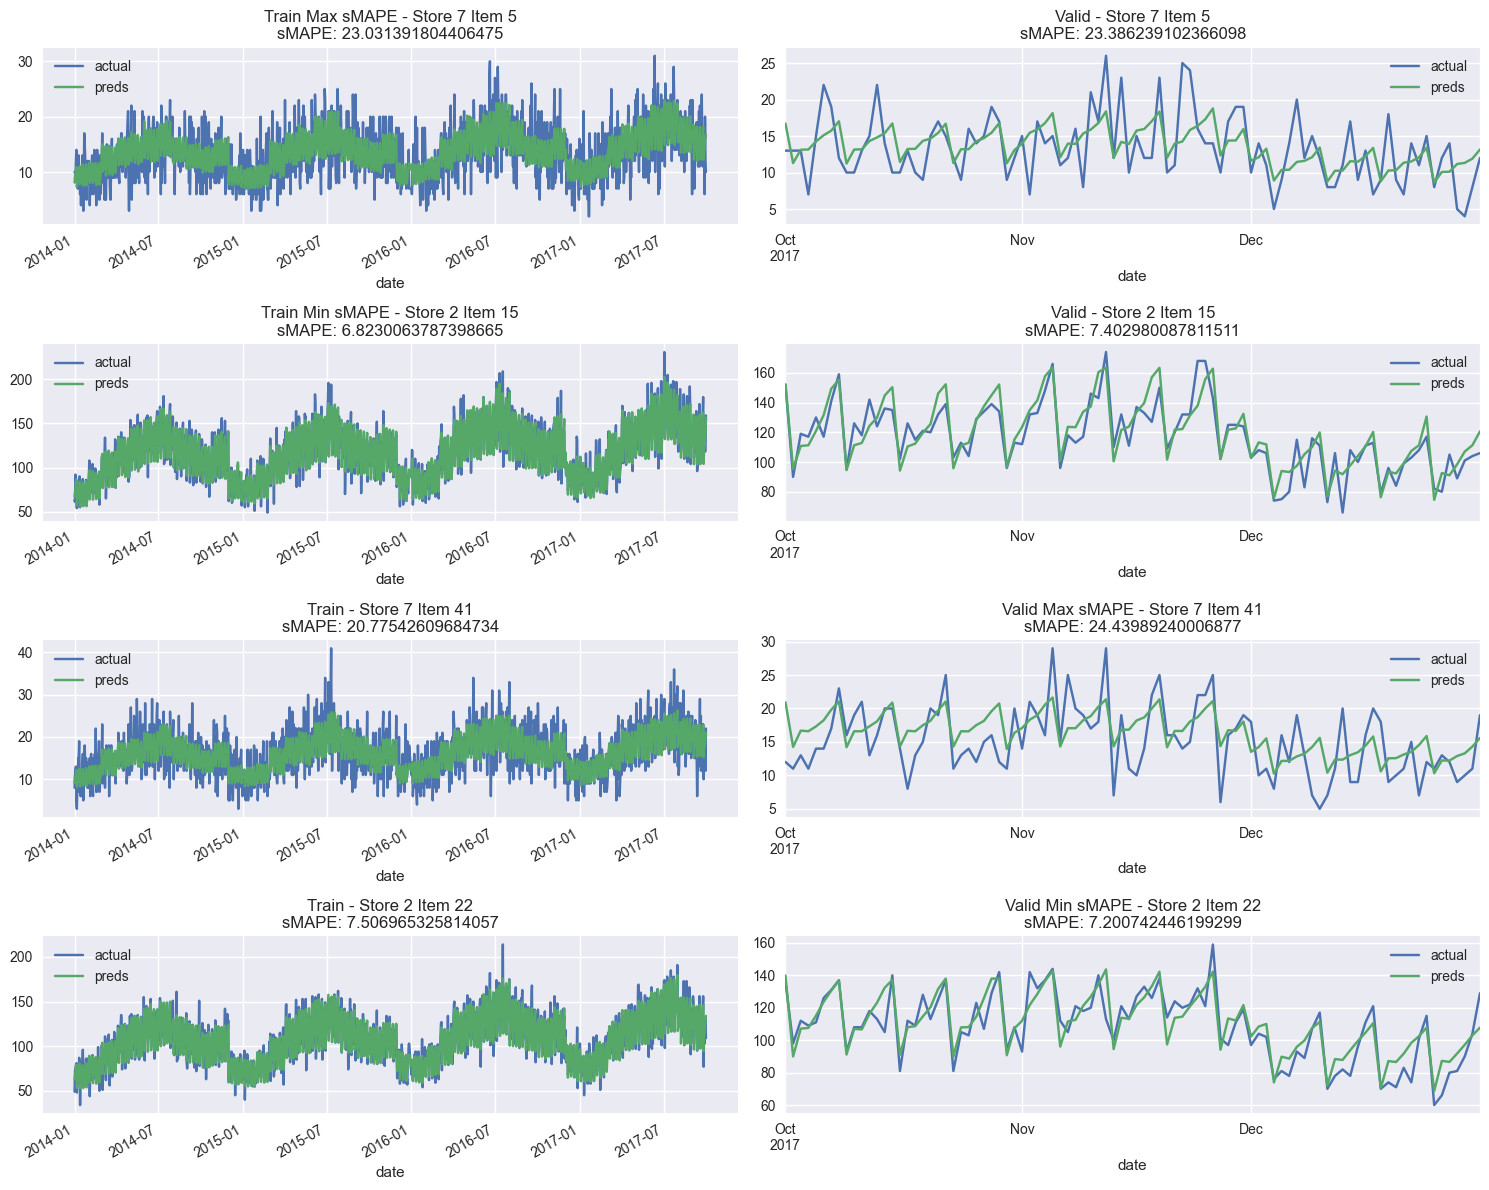

In [256]:
utils.plot_min_max_smape(train_res, valid_res,
                         si_scores_df, 'xgb_tuned')

In [257]:
add_scores(train_res, valid_res, scores_df, 'xgb_tuned')

In [258]:
scores_df

train      valid
dtree                    12.437039  13.493780
dtree_indiv              13.871189  14.834892
rf                       13.558214  14.490352
rf_indiv                 10.470880  12.712571
xgb                      12.190373  12.385719
xgb_indiv                11.348260  12.764159
dtree_selected_features  12.485182  13.600973
rf_selected_features     13.732469  14.813128
xgb_selected_features    12.869439  13.205482
xgb_tuned                12.062680  12.592438